In [ ]:
# @title
# prompt: Instaall dependencies #HYBRID EGFR


!pip install pandas chembl_webresource_client rdkit

In [ ]:
import pandas as pd
import numpy as np

# Load your saved CSV
df = pd.read_csv("egfr_BF_high_qed.csv")

def convert_to_pIC50(value, units):
    """
    Converts IC50/Ki/Kd/EC50 values into molar units
    and then pIC50 = -log10(M).
    """
    if pd.isna(value) or pd.isna(units):
        return None
    units = units.lower().strip()
    try:
        if units in ["nm", "nanomolar"]:
            molar = value * 1e-9
        elif units in ["um", "µm", "micromolar"]:
            molar = value * 1e-6
        elif units in ["mm", "millimolar"]:
            molar = value * 1e-3
        elif units in ["m", "molar"]:
            molar = value
        elif units in ["pm", "picomolar"]:
            molar = value * 1e-12
        else:
            return None
        if molar <= 0:
            return None
        return -np.log10(molar)
    except:
        return None

def classify_activity(pIC50):
    """
    Classify into High / Moderate / Low.
    """
    if pIC50 is None:
        return None
    if pIC50 >= 8:      # ≤10 nM
        return "High"
    elif pIC50 >= 6:    # 10 nM – 1 µM
        return "Moderate"
    else:               # >1 µM
        return "Low"

# Step 1: Compute pIC50
df["pIC50"] = df.apply(
    lambda row: convert_to_pIC50(row["standard_value"], row["standard_units"]), axis=1
)

# Step 2: Drop missing
df = df.dropna(subset=["pIC50"])

# Step 3: Classify activity
df["Activity_Class"] = df["pIC50"].apply(classify_activity)

# Save new dataset
df.to_csv("egfr_BF_with_pIC50.csv", index=False)

print(df[["molecule_chembl_id", "standard_type", "standard_value", "standard_units", "pIC50", "Activity_Class"]].head(10))

# Step 4: Filter only High and Moderate activity molecules
df_refined = df[df["Activity_Class"].isin(["High", "Moderate"])]

# Save refined dataset
df_refined.to_csv("egfr_BF_refined_high_moderate.csv", index=False)

print("Total molecules after refinement:", len(df_refined))
print(df_refined[["molecule_chembl_id", "standard_type", "standard_value",
                  "standard_units", "pIC50", "Activity_Class"]].head(10))



  molecule_chembl_id standard_type  standard_value standard_units     pIC50  \
0       CHEMBL306988          IC50        500000.0             nM  3.301030   
1        CHEMBL66879          IC50       3000000.0             nM  2.522879   
2        CHEMBL76979          IC50        264000.0             nM  3.578396   
3        CHEMBL77724          IC50       1250000.0             nM  2.903090   
4       CHEMBL420385          IC50        625000.0             nM  3.204120   
5       CHEMBL421877          IC50        850000.0             nM  3.070581   
6        CHEMBL76983          IC50       1250000.0             nM  2.903090   
7       CHEMBL336113          IC50          1000.0             nM  6.000000   
8        CHEMBL78174          IC50        430000.0             nM  3.366532   
9        CHEMBL78302          IC50        250000.0             nM  3.602060   

  Activity_Class  
0            Low  
1            Low  
2            Low  
3            Low  
4            Low  
5            Low

In [ ]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, QED

# 1. Setup search keywords for EGFR mutants
mutations = ["T790M", "C797S", "exon20"]

# 2. Initialize ChEMBL clients
assay = new_client.assay
activity = new_client.activity
molecule = new_client.molecule

all_results = []

# 3. Loop over each mutant and fetch assays
for mut in mutations:
    assays = assay.filter(description__icontains=mut, target_chembl_id="CHEMBL203")  # EGFR target CHEMBL ID
    for a in assays:
        acts = activity.filter(assay_chembl_id=a["assay_chembl_id"])
        for act in acts:
            if act.get("standard_value") and act.get("standard_type") in ["IC50", "Ki", "Kd", "EC50"]:
                mol = molecule.get(act["molecule_chembl_id"])
                if mol and "molecule_structures" in mol and mol["molecule_structures"]:
                    smiles = mol["molecule_structures"]["canonical_smiles"]
                    all_results.append({
                        "molecule_chembl_id": act["molecule_chembl_id"],
                        "canonical_smiles": smiles,
                        "assay_id": a["assay_chembl_id"],
                        "assay_description": a.get("description", ""),
                        "mutation": mut,
                        "standard_type": act["standard_type"],
                        "standard_value": act["standard_value"],
                        "standard_units": act["standard_units"]
                    })

# 4. Convert to DataFrame
df = pd.DataFrame(all_results)

# 5. Convert to molar pIC50
def to_pIC50(row):
    try:
        val = float(row["standard_value"])
        units = row["standard_units"]
        # Normalize units to Molar
        if units == "nM":
            molar = val * 1e-9
        elif units == "µM":
            molar = val * 1e-6
        elif units == "mM":
            molar = val * 1e-3
        elif units == "pM":
            molar = val * 1e-12
        else:
            return None
        return -pd.np.log10(molar)
    except:
        return None

df["pIC50"] = df.apply(to_pIC50, axis=1)

# 6. Add RDKit Descriptors
def compute_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [None]*7
        return [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumRotatableBonds(mol),
            QED.qed(mol)
        ]
    except:
        return [None]*7

desc_cols = ["MolWt", "LogP", "TPSA", "HBD", "HBA", "RotB", "QED"]
df[desc_cols] = df["canonical_smiles"].apply(lambda x: pd.Series(compute_descriptors(x)))

# 7. Save ready-to-train dataset
df.to_csv("EGFR_mutants_ready.csv", index=False)

print("✅ Final dataset saved as EGFR_mutants_ready.csv")
print(df.head())


✅ Final dataset saved as EGFR_mutants_ready.csv
  molecule_chembl_id                                   canonical_smiles  \
0        CHEMBL91867            CC#CC(=O)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1   
1          CHEMBL939     COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1   
2       CHEMBL571040  C=CC(=O)N1CCC[C@H]1C(=O)Nc1cc2c(Nc3cccc(Cl)c3F...   
3          CHEMBL553         C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1   
4       CHEMBL569880  C=CC(=O)N1CCC[C@H]1C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)...   

        assay_id                                  assay_description mutation  \
0   CHEMBL976908  Inhibition of EGFR L858R/T790M mutant by cellu...    T790M   
1  CHEMBL1015943   Binding affinity to EGFR with L858R/T790M mutant    T790M   
2  CHEMBL1044057  Inhibition of Her1 T790M mutant by fluorescenc...    T790M   
3  CHEMBL1044057  Inhibition of Her1 T790M mutant by fluorescenc...    T790M   
4  CHEMBL1044057  Inhibition of Her1 T790M mutant by fluorescenc...    T790M   

  standard_type stan

In [ ]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski, rdMolDescriptors, QED
import numpy as np

# -------------------------------
# 1. Helper functions
# -------------------------------

def convert_to_pIC50(value, units):
    """
    Convert IC50/Ki/Kd/EC50 values into molar units
    then compute pIC50 = -log10(M).
    """
    if pd.isna(value) or pd.isna(units):
        return None

    units = units.lower()
    try:
        value = float(value)
    except:
        return None

    # Convert to molar
    if units in ["nm", "nanomolar"]:
        molar = value * 1e-9
    elif units in ["um", "micromolar"]:
        molar = value * 1e-6
    elif units in ["mm", "millimolar"]:
        molar = value * 1e-3
    elif units in ["pm", "picomolar"]:
        molar = value * 1e-12
    elif units in ["m", "mol/l"]:
        molar = value
    else:
        return None

    if molar <= 0:
        return None

    return -np.log10(molar)


def classify_activity(pIC50):
    """Classify activity into High / Moderate / Low"""
    if pIC50 is None or np.isnan(pIC50):
        return "Unknown"
    if pIC50 >= 8:
        return "High"
    elif pIC50 >= 6:
        return "Moderate"
    else:
        return "Low"


def calculate_descriptors(smiles):
    """Compute RDKit descriptors (QED, MW, LogP, etc.)"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None, None, None, None, None, None, None
    return (
        QED.qed(mol),
        Descriptors.MolWt(mol),
        Crippen.MolLogP(mol),
        Lipinski.NumHDonors(mol),
        Lipinski.NumHAcceptors(mol),
        rdMolDescriptors.CalcTPSA(mol),
        Lipinski.NumRotatableBonds(mol),
    )


def classify_egfr(description):
    """Label as Wild-Type or Mutant EGFR based on assay/target description"""
    if pd.isna(description):
        return "Unknown"

    desc = description.upper()
    if any(mut in desc for mut in ["T790M", "C797S", "EXON20", "EXON 20", "L858R", "DEL19", "DEL 19", "MUTANT"]):
        return "Mutant"
    else:
        return "Wild-Type"


# -------------------------------
# 2. Fetch EGFR inhibitors from ChEMBL
# -------------------------------

activity = new_client.activity
target = new_client.target

# Get EGFR target IDs
egfr_targets = target.filter(target_synonym__icontains="EGFR")
egfr_ids = [t['target_chembl_id'] for t in egfr_targets]

all_data = []

for t_id in egfr_ids:
    res = activity.filter(target_chembl_id=t_id, standard_type__in=["IC50","Ki","Kd","EC50"]).only(
        ['molecule_chembl_id','canonical_smiles','standard_type','standard_value','standard_units','assay_description']
    )
    all_data.extend(res)

# Convert to DataFrame
df = pd.DataFrame(all_data).dropna(subset=["canonical_smiles"])

# -------------------------------
# 3. Compute descriptors and labels
# -------------------------------

df["pIC50"] = df.apply(lambda row: convert_to_pIC50(row["standard_value"], row["standard_units"]), axis=1)
df["Activity_Class"] = df["pIC50"].apply(classify_activity)

desc_results = df["canonical_smiles"].apply(calculate_descriptors)
df["QED"], df["MW"], df["LogP"], df["HBD"], df["HBA"], df["TPSA"], df["NumRotatableBonds"] = zip(*desc_results)

df["EGFR_Type"] = df["assay_description"].apply(classify_egfr)

# -------------------------------
# 4. Save final dataset
# -------------------------------
df.to_csv("EGFR_inhibitors_full.csv", index=False)

print("✅ Final dataset saved as EGFR_inhibitors_full.csv")
print(df.head(10))


✅ Final dataset saved as EGFR_inhibitors_full.csv
                                   assay_description  \
0  Inhibitory activity towards tyrosine phosphory...   
1  Inhibition of autophosphorylation of human epi...   
2  Inhibition of ligand-induced proliferation in ...   
3  Inhibitory activity towards tyrosine phosphory...   
4  Inhibition of autophosphorylation of human epi...   
5  Inhibition of ligand-induced proliferation in ...   
6  In vitro inhibition of Epidermal growth factor...   
7  Inhibitory concentration of EGF dependent auto...   
8  Inhibition of EGF-dependent epidermal growth f...   
9  Inhibitory concentration of EGF dependent auto...   

                                    canonical_smiles molecule_chembl_id  \
0  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
1  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
2  Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...        CHEMBL68920   
3  Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C

In [ ]:
import pandas as pd
import numpy as np

# ==========================
# Step 1: Load dataset
# ==========================
df = pd.read_csv("EGFR_inhibitors_full.csv")

# ==========================
# Step 2: Convert to molar and pIC50
# ==========================
def to_molar(value, unit):
    if pd.isna(value) or pd.isna(unit):
        return None
    try:
        value = float(value)
    except:
        return None

    unit = unit.lower().strip()
    if unit == "m":       return value
    elif unit == "mm":    return value * 1e-3
    elif unit == "um":    return value * 1e-6
    elif unit == "µm":    return value * 1e-6
    elif unit == "nm":    return value * 1e-9
    elif unit == "pm":    return value * 1e-12
    else: return None

def calc_pIC50(row):
    molar = to_molar(row["standard_value"], row["standard_units"])
    if molar and molar > 0:
        return -np.log10(molar)
    return None

df["pIC50"] = df.apply(calc_pIC50, axis=1)

# ==========================
# Step 3: Define mutant keywords
# ==========================
mutant_keywords = [
    "T790M", "C797S", "L858R", "exon20", "exon 20",
    "del19", "ΔE746_A750", "E746_A750del", "G719S", "L861Q"
]

# ==========================
# Step 4: Label rows
# ==========================
def classify_target(desc):
    if pd.isna(desc):
        return "Wild-type"
    for kw in mutant_keywords:
        if kw.lower() in desc.lower():
            return "Mutant"
    return "Wild-type"

df["Target_Type"] = df["assay_description"].apply(classify_target)

# ==========================
# Step 5: Save single annotated file
# ==========================
df.to_csv("EGFR_inhibitors_labeled.csv", index=False)

print("✅ Processing complete!")
print(f"Total molecules: {len(df)}")
print(df["Target_Type"].value_counts())


✅ Processing complete!
Total molecules: 44867
Target_Type
Wild-type    39769
Mutant        5098
Name: count, dtype: int64


In [ ]:
# To be run in your local environment
import pandas as pd
from rdkit import Chem

# Load the file
df = pd.read_csv('EGFR_inhibitors_not_low_and_no_missing_smiles.csv')


# Create a new list to store the processed SMILES
canonical_smiles_list = []
invalid_smiles_count = 0

for smiles in df['canonical_smiles']:
    try:
        # Step 1 & 2: Validation and Canonicalization
        # This converts a SMILES string to a canonical molecule object.
        mol = Chem.MolFromSmiles(smiles)

        if mol is not None:
            # If valid, convert back to a canonical SMILES string
            canonical_smiles_list.append(Chem.MolToSmiles(mol))
        else:
            # If the SMILES is invalid, skip it
            invalid_smiles_count += 1
            canonical_smiles_list.append(None)

    except Exception as e:
        # Handle any other potential errors
        invalid_smiles_count += 1
        canonical_smiles_list.append(None)

# Create a new DataFrame with only the valid and canonicalized molecules
processed_df = pd.DataFrame({'canonical_smiles_clean': canonical_smiles_list})
processed_df = processed_df.dropna(subset=['canonical_smiles_clean'])

# Merge with the original data to keep other columns
final_df = pd.merge(df, processed_df, left_index=True, right_index=True)

print(f"Initial molecules: {len(df)}")
print(f"Invalid or uncanonicalized molecules: {invalid_smiles_count}")
print(f"Final valid molecules: {len(final_df)}")

# Save the preprocessed data
final_df.to_csv('EGFR_preprocessed_file.csv', index=False)

Initial molecules: 18094
Invalid or uncanonicalized molecules: 0
Final valid molecules: 18094


In [ ]:
# ais_tokenize_with_padding.py
import json
import pandas as pd
from rdkit import Chem

# --------------------------
# AIS tokenizer
# --------------------------
BOND_MAP = {
    Chem.BondType.SINGLE: "-",
    Chem.BondType.DOUBLE: "=",
    Chem.BondType.TRIPLE: "#",
    Chem.BondType.AROMATIC: ":",
}

def _bond_char(bond):
    if bond is None:
        return "~"
    return BOND_MAP.get(bond.GetBondType(), "~")

def _atom_core(atom):
    sym = atom.GetSymbol()
    return sym.lower() if atom.GetIsAromatic() else sym

def _chiral_tag(atom):
    tag = atom.GetChiralTag()
    if tag == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
        return "chi@"
    if tag == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
        return "chi@@"
    return None

def _neighbor_entries(atom):
    entries = []
    for nbr in atom.GetNeighbors():
        bond = atom.GetOwningMol().GetBondBetweenAtoms(atom.GetIdx(), nbr.GetIdx())
        bch = _bond_char(bond)
        nsym = nbr.GetSymbol().lower() if nbr.GetIsAromatic() else nbr.GetSymbol()
        entries.append((bch, nsym, -bond.GetBondTypeAsDouble(), nsym.islower()))
    entries.sort(key=lambda x: (x[2], x[1], x[3]))
    return [f"{b}:{e}" for (b, e, *_rest) in entries]

def atom_to_ais(atom):
    core = _atom_core(atom)
    neigh = _neighbor_entries(atom)
    props = []
    props.append(f"H{atom.GetTotalNumHs()}")
    props.append(f"deg{len(atom.GetNeighbors())}")
    if atom.IsInRing():
        props.append("r")
    chg = atom.GetFormalCharge()
    if chg:
        props.append(f"chg{chg:+d}")
    iso = atom.GetIsotope()
    if iso:
        props.append(f"iso{iso}")
    chi = _chiral_tag(atom)
    if chi:
        props.append(chi)
    return f"{core}[{','.join(neigh)}]{{{'|'.join(props)}}}"

def smiles_to_ais(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        Chem.Kekulize(mol, clearAromaticFlags=False)
    except Exception:
        pass
    return [atom_to_ais(a) for a in mol.GetAtoms()]

# --------------------------
# Apply to dataset
# --------------------------
final_df = pd.read_csv("EGFR_preprocessed_file.csv")

ais_tokens = []
for s in final_df["canonical_smiles_clean"]:
    toks = smiles_to_ais(s)
    ais_tokens.append(toks if toks else None)

final_df["ais_tokens"] = ais_tokens
final_df = final_df.dropna(subset=["ais_tokens"]).reset_index(drop=True)

# --------------------------
# Vocab
# --------------------------
SPECIAL_TOKENS = ["<pad>", "<unk>", "<bos>", "<eos>"]

vocab = {}
for row in final_df["ais_tokens"]:
    for t in row:
        vocab[t] = vocab.get(t, 0) + 1

sorted_tokens = sorted(vocab.items(), key=lambda x: (-x[1], x[0]))
token_list = SPECIAL_TOKENS + [t for t, _ in sorted_tokens]
token_to_id = {t: i for i, t in enumerate(token_list)}

# --------------------------
# Map tokens -> ids with padding
# --------------------------
def map_to_ids(toks, token_to_id, max_len=128, use_bos_eos=True):
    ids = []
    if use_bos_eos:
        ids.append(token_to_id["<bos>"])
    ids.extend([token_to_id.get(t, token_to_id["<unk>"]) for t in toks])
    if use_bos_eos:
        ids.append(token_to_id["<eos>"])
    # pad or truncate
    if len(ids) < max_len:
        ids.extend([token_to_id["<pad>"]] * (max_len - len(ids)))
    else:
        ids = ids[:max_len]
    return ids

MAX_LEN = max(len(row) + 2 for row in final_df["ais_tokens"])  # +2 for bos/eos
print(f"Max AIS sequence length in dataset (with bos/eos): {MAX_LEN}")

final_df["ais_ids"] = final_df["ais_tokens"].apply(lambda ts: map_to_ids(ts, token_to_id, max_len=MAX_LEN))
final_df["ais_ids_len"] = final_df["ais_tokens"].apply(lambda ts: min(len(ts) + 2, MAX_LEN))

# --------------------------
# Save
# --------------------------
final_df.to_csv("EGFR_preprocessed_with_AIS_padded.csv", index=False)
with open("ais_vocab.json", "w", encoding="utf-8") as f:
    json.dump({"token_to_id": token_to_id, "special_tokens": SPECIAL_TOKENS}, f, indent=2)

print("Saved padded AIS dataset -> EGFR_preprocessed_with_AIS_padded.csv")

Max AIS sequence length in dataset (with bos/eos): 130
Saved padded AIS dataset -> EGFR_preprocessed_with_AIS_padded.csv


In [ ]:
!pip install selfies


In [ ]:
# selfies_tokenize_with_padding.py
import pandas as pd
import json
import selfies as sf
from rdkit import Chem

# --------------------------
# Convert SMILES → SELFIES safely
# --------------------------
def smiles_to_selfies(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        sf_str = sf.encoder(smiles)
        return sf_str
    except Exception:
        return None

# --------------------------
# Tokenize SELFIES (split into symbols)
# --------------------------
def selfies_to_tokens(selfies_str):
    try:
        return list(sf.split_selfies(selfies_str))
    except Exception:
        return None

# --------------------------
# Load dataset
# --------------------------
df = pd.read_csv("EGFR_preprocessed_file.csv")

# convert SMILES to SELFIES and tokens
selfies_list, selfies_tokens = [], []

for smi in df["canonical_smiles_clean"]:
    sf_str = smiles_to_selfies(smi)
    if sf_str:
        toks = selfies_to_tokens(sf_str)
        selfies_list.append(sf_str)
        selfies_tokens.append(toks)
    else:
        selfies_list.append(None)
        selfies_tokens.append(None)

df["selfies"] = selfies_list
df["selfies_tokens"] = selfies_tokens
df = df.dropna(subset=["selfies_tokens"]).reset_index(drop=True)

print(f"✅ Converted {len(df)} molecules to SELFIES")

# --------------------------
# Build vocabulary
# --------------------------
SPECIAL_TOKENS = ["<pad>", "<unk>", "<bos>", "<eos>"]

vocab = {}
for tokens in df["selfies_tokens"]:
    for t in tokens:
        vocab[t] = vocab.get(t, 0) + 1

sorted_tokens = sorted(vocab.items(), key=lambda x: (-x[1], x[0]))
token_list = SPECIAL_TOKENS + [t for t, _ in sorted_tokens]
token_to_id = {t: i for i, t in enumerate(token_list)}

# --------------------------
# Map tokens → IDs with padding
# --------------------------
def map_to_ids(tokens, token_to_id, max_len=128, use_bos_eos=True):
    ids = []
    if use_bos_eos:
        ids.append(token_to_id["<bos>"])
    ids.extend([token_to_id.get(t, token_to_id["<unk>"]) for t in tokens])
    if use_bos_eos:
        ids.append(token_to_id["<eos>"])
    # pad or truncate
    if len(ids) < max_len:
        ids.extend([token_to_id["<pad>"]] * (max_len - len(ids)))
    else:
        ids = ids[:max_len]
    return ids

MAX_LEN = max(len(row) + 2 for row in df["selfies_tokens"])  # +2 for bos/eos
print(f"📏 Max SELFIES sequence length (with bos/eos): {MAX_LEN}")

df["selfies_ids"] = df["selfies_tokens"].apply(lambda ts: map_to_ids(ts, token_to_id, max_len=MAX_LEN))
df["selfies_ids_len"] = df["selfies_tokens"].apply(lambda ts: min(len(ts) + 2, MAX_LEN))

# --------------------------
# Save processed dataset and vocab
# --------------------------
df.to_csv("EGFR_preprocessed_with_SELFIES_padded.csv", index=False)
with open("selfies_vocab.json", "w", encoding="utf-8") as f:
    json.dump({"token_to_id": token_to_id, "special_tokens": SPECIAL_TOKENS}, f, indent=2)

print("✅ Saved padded SELFIES dataset -> EGFR_preprocessed_with_SELFIES_padded.csv")
print("✅ Saved vocab -> selfies_vocab.json")


✅ Converted 18094 molecules to SELFIES
📏 Max SELFIES sequence length (with bos/eos): 216
✅ Saved padded SELFIES dataset -> EGFR_preprocessed_with_SELFIES_padded.csv
✅ Saved vocab -> selfies_vocab.json


In [ ]:
# scaffold_split_and_loaders.py
import ast, json, numpy as np, pandas as pd
from collections import defaultdict
from typing import Tuple, Dict, List

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

import torch
from torch.utils.data import Dataset, DataLoader

# =========================
# CONFIG
# =========================
CSV_IN = "EGFR_preprocessed_with_AIS_padded.csv"   # must have columns: canonical_smiles_clean, ais_ids
SMI_COL = "canonical_smiles_clean"
AIS_COL = "ais_ids"
VAL_FRAC = 0.1
TEST_FRAC = 0.1
SEED = 42
MAX_SMI_LEN = 128
BATCH = 64

# =========================
# SCAFFOLD SPLIT
# =========================
def murcko_scaffold(smiles: str) -> str:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return ""
    try:
        scaf = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaf, isomericSmiles=True)
    except Exception:
        return ""

def scaffold_split_indices(df: pd.DataFrame, smiles_col: str,
                           val_frac: float, test_frac: float,
                           seed: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    scaff2idxs = defaultdict(list)
    smiles_list = df[smiles_col].tolist()

    for i, s in enumerate(smiles_list):
        scaff = murcko_scaffold(s)
        scaff2idxs[scaff].append(i)

    # shuffle groups for randomness, then sort by size (big -> small) for stable filling
    groups = list(scaff2idxs.items())
    rng.shuffle(groups)
    groups.sort(key=lambda kv: len(kv[1]), reverse=True)

    n = len(df)
    n_val = int(round(n * val_frac))
    n_test = int(round(n * test_frac))

    train_idx, val_idx, test_idx = [], [], []
    for scaff, idxs in groups:
        if len(val_idx) < n_val:
            val_idx.extend(idxs)
        elif len(test_idx) < n_test:
            test_idx.extend(idxs)
        else:
            train_idx.extend(ids for ids in idxs)

    # safety trims (if slight overfill)
    val_idx = val_idx[:n_val]
    test_idx = test_idx[:n_test]
    train_mask = np.ones(n, dtype=bool)
    train_mask[val_idx] = False
    train_mask[test_idx] = False
    train_idx = np.where(train_mask)[0]

    return np.array(train_idx), np.array(val_idx), np.array(test_idx)

# =========================
# SMILES CHAR VOCAB (train-only)
# =========================
SPECIAL = ["<pad>", "<unk>", "<bos>", "<eos>"]

def build_smiles_vocab(train_smiles: List[str]) -> Dict[str, int]:
    chars = set()
    for s in train_smiles:
        chars.update(list(s))
    itos = SPECIAL + sorted(chars)
    stoi = {c: i for i, c in enumerate(itos)}
    return {"stoi": stoi, "itos": itos}

def encode_smiles(s: str, stoi: Dict[str, int], max_len: int) -> List[int]:
    ids = [stoi["<bos>"]] + [stoi.get(ch, stoi["<unk>"]) for ch in s] + [stoi["<eos>"]]
    if len(ids) < max_len:
        ids += [stoi["<pad>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

def shift_targets(inp_ids: List[int], pad_id: int, eos_id: int) -> List[int]:
    tgt = inp_ids[1:] + [eos_id]
    if len(tgt) > len(inp_ids):
        tgt = tgt[:len(inp_ids)]
    return tgt

# =========================
# DATASETS
# =========================
class HybridGenDataset(Dataset):
    """
    For hybrid generation:
      X: padded SMILES ids (char-level)
      Y: next-token targets (shifted X)
      C: AIS ids (already padded from your preprocessing)
    """
    def __init__(self, df: pd.DataFrame, smi_col: str, ais_col: str, stoi: Dict[str, int], max_len: int):
        self.smi = df[smi_col].tolist()
        self.ais = [ast.literal_eval(x) for x in df[ais_col].tolist()]
        self.stoi = stoi
        self.max_len = max_len
        self.pad_id = stoi["<pad>"]
        self.eos_id = stoi["<eos>"]

    def __len__(self):
        return len(self.smi)

    def __getitem__(self, idx):
        s = self.smi[idx]
        a = self.ais[idx]
        x = encode_smiles(s, self.stoi, self.max_len)
        y = shift_targets(x, self.pad_id, self.eos_id)
        return (
            torch.tensor(x, dtype=torch.long),
            torch.tensor(y, dtype=torch.long),
            torch.tensor(a, dtype=torch.long)
        )

# =========================
# MAIN: split + save + loaders
# =========================
def main():
    df = pd.read_csv(CSV_IN)
    assert SMI_COL in df.columns and AIS_COL in df.columns, "CSV must have SMILES and AIS columns."

    # Split
    tr_idx, va_idx, te_idx = scaffold_split_indices(df, SMI_COL, VAL_FRAC, TEST_FRAC, SEED)
    print(f"Split sizes -> train {len(tr_idx)}, val {len(va_idx)}, test {len(te_idx)}")

    tr_df, va_df, te_df = df.iloc[tr_idx].reset_index(drop=True), df.iloc[va_idx].reset_index(drop=True), df.iloc[te_idx].reset_index(drop=True)

    tr_df.to_csv("train.csv", index=False)
    va_df.to_csv("val.csv", index=False)
    te_df.to_csv("test.csv", index=False)
    print("Saved: train.csv, val.csv, test.csv")

    # Build SMILES vocab from TRAIN ONLY
    vocab = build_smiles_vocab(tr_df[SMI_COL].tolist())
    with open("smiles_vocab.json", "w", encoding="utf-8") as f:
        json.dump(vocab, f, indent=2, ensure_ascii=False)
    print("Saved: smiles_vocab.json")

    # Example: create DataLoaders (you can import this file and reuse below)
    stoi = vocab["stoi"]

    tr_ds = HybridGenDataset(tr_df, SMI_COL, AIS_COL, stoi, MAX_SMI_LEN)
    va_ds = HybridGenDataset(va_df, SMI_COL, AIS_COL, stoi, MAX_SMI_LEN)
    te_ds = HybridGenDataset(te_df, SMI_COL, AIS_COL, stoi, MAX_SMI_LEN)

    tr_loader = DataLoader(tr_ds, batch_size=BATCH, shuffle=True)
    va_loader = DataLoader(va_ds, batch_size=BATCH, shuffle=False)
    te_loader = DataLoader(te_ds, batch_size=BATCH, shuffle=False)

    # quick sanity check batch
    xb, yb, cb = next(iter(tr_loader))
    print(f"Batch shapes -> X (SMI): {xb.shape}, Y (tgt): {yb.shape}, C (AIS): {cb.shape}")

if __name__ == "__main__":
    main()



Split sizes -> train 14476, val 1809, test 1809
Saved: train.csv, val.csv, test.csv
Saved: smiles_vocab.json
Batch shapes -> X (SMI): torch.Size([64, 128]), Y (tgt): torch.Size([64, 128]), C (AIS): torch.Size([64, 130])


In [ ]:
# scaffold_split_and_loaders_selfies.py  # SELFIES FORMATE
import ast, json, numpy as np, pandas as pd
from collections import defaultdict
from typing import Tuple, Dict, List

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
import selfies as sf  # ✅ SELFIES library

import torch
from torch.utils.data import Dataset, DataLoader

# =========================
# CONFIG
# =========================
CSV_IN = "EGFR_preprocessed_with_SELFIES_padded.csv"   # must have columns: canonical_smiles_clean, selfies_ids
SMI_COL = "canonical_smiles_clean"
SELFIES_COL = "selfies_ids"
VAL_FRAC = 0.1
TEST_FRAC = 0.1
SEED = 42
MAX_SMI_LEN = 128
BATCH = 64

# =========================
# SCAFFOLD SPLIT
# =========================
def murcko_scaffold(smiles: str) -> str:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return ""
    try:
        scaf = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaf, isomericSmiles=True)
    except Exception:
        return ""

def scaffold_split_indices(df: pd.DataFrame, smiles_col: str,
                           val_frac: float, test_frac: float,
                           seed: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    scaff2idxs = defaultdict(list)
    smiles_list = df[smiles_col].tolist()

    for i, s in enumerate(smiles_list):
        scaff = murcko_scaffold(s)
        scaff2idxs[scaff].append(i)

    groups = list(scaff2idxs.items())
    rng.shuffle(groups)
    groups.sort(key=lambda kv: len(kv[1]), reverse=True)

    n = len(df)
    n_val = int(round(n * val_frac))
    n_test = int(round(n * test_frac))

    train_idx, val_idx, test_idx = [], [], []
    for scaff, idxs in groups:
        if len(val_idx) < n_val:
            val_idx.extend(idxs)
        elif len(test_idx) < n_test:
            test_idx.extend(idxs)
        else:
            train_idx.extend(idxs)

    val_idx = val_idx[:n_val]
    test_idx = test_idx[:n_test]
    train_mask = np.ones(n, dtype=bool)
    train_mask[val_idx] = False
    train_mask[test_idx] = False
    train_idx = np.where(train_mask)[0]

    return np.array(train_idx), np.array(val_idx), np.array(test_idx)

# =========================
# SELFIES VOCAB
# =========================
SPECIAL = ["<pad>", "<unk>", "<bos>", "<eos>"]

def build_selfies_vocab(train_selfies: List[str]) -> Dict[str, int]:
    symbols = set()
    for s in train_selfies:
        try:
            toks = list(sf.split_selfies(s))
            symbols.update(toks)
        except Exception:
            continue
    itos = SPECIAL + sorted(symbols)
    stoi = {c: i for i, c in enumerate(itos)}
    return {"stoi": stoi, "itos": itos}

def encode_selfies(s: str, stoi: Dict[str, int], max_len: int) -> List[int]:
    try:
        tokens = list(sf.split_selfies(s))
    except Exception:
        tokens = []
    ids = [stoi["<bos>"]] + [stoi.get(tok, stoi["<unk>"]) for tok in tokens] + [stoi["<eos>"]]
    if len(ids) < max_len:
        ids += [stoi["<pad>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

def shift_targets(inp_ids: List[int], pad_id: int, eos_id: int) -> List[int]:
    tgt = inp_ids[1:] + [eos_id]
    if len(tgt) > len(inp_ids):
        tgt = tgt[:len(inp_ids)]
    return tgt

# =========================
# DATASET
# =========================
class HybridGenDataset(Dataset):
    """
    For hybrid generation:
      X: padded SELFIES ids (token-level)
      Y: next-token targets (shifted X)
      C: SELFIES embedding/padded IDs (same as AIS previously)
    """
    def __init__(self, df: pd.DataFrame, smi_col: str, selfies_col: str, stoi: Dict[str, int], max_len: int):
        self.smi = df[smi_col].tolist()
        self.selfies_ids = [ast.literal_eval(x) for x in df[selfies_col].tolist()]
        self.stoi = stoi
        self.max_len = max_len
        self.pad_id = stoi["<pad>"]
        self.eos_id = stoi["<eos>"]

    def __len__(self):
        return len(self.smi)

    def __getitem__(self, idx):
        s = self.smi[idx]
        c = self.selfies_ids[idx]
        x = encode_selfies(sf.encoder(s), self.stoi, self.max_len)
        y = shift_targets(x, self.pad_id, self.eos_id)
        return (
            torch.tensor(x, dtype=torch.long),
            torch.tensor(y, dtype=torch.long),
            torch.tensor(c, dtype=torch.long)
        )

# =========================
# MAIN
# =========================
def main():
    df = pd.read_csv(CSV_IN)
    assert SMI_COL in df.columns and SELFIES_COL in df.columns, "CSV must have SMILES and SELFIES columns."

    tr_idx, va_idx, te_idx = scaffold_split_indices(df, SMI_COL, VAL_FRAC, TEST_FRAC, SEED)
    print(f"Split sizes -> train {len(tr_idx)}, val {len(va_idx)}, test {len(te_idx)}")

    tr_df, va_df, te_df = df.iloc[tr_idx].reset_index(drop=True), df.iloc[va_idx].reset_index(drop=True), df.iloc[te_idx].reset_index(drop=True)
    tr_df.to_csv("train.csv", index=False)
    va_df.to_csv("val.csv", index=False)
    te_df.to_csv("test.csv", index=False)
    print("Saved: train.csv, val.csv, test.csv")

    vocab = build_selfies_vocab(tr_df[SMI_COL].apply(sf.encoder).tolist())
    with open("selfies_vocab.json", "w", encoding="utf-8") as f:
        json.dump(vocab, f, indent=2, ensure_ascii=False)
    print("Saved: selfies_vocab.json")

    stoi = vocab["stoi"]

    tr_ds = HybridGenDataset(tr_df, SMI_COL, SELFIES_COL, stoi, MAX_SMI_LEN)
    va_ds = HybridGenDataset(va_df, SMI_COL, SELFIES_COL, stoi, MAX_SMI_LEN)
    te_ds = HybridGenDataset(te_df, SMI_COL, SELFIES_COL, stoi, MAX_SMI_LEN)

    tr_loader = DataLoader(tr_ds, batch_size=BATCH, shuffle=True)
    va_loader = DataLoader(va_ds, batch_size=BATCH, shuffle=False)
    te_loader = DataLoader(te_ds, batch_size=BATCH, shuffle=False)

    xb, yb, cb = next(iter(tr_loader))
    print(f"Batch shapes -> X (SELFIES): {xb.shape}, Y (target): {yb.shape}, C (SELFIES padded): {cb.shape}")

if __name__ == "__main__":
    main()


Split sizes -> train 14476, val 1809, test 1809
Saved: train.csv, val.csv, test.csv
Saved: selfies_vocab.json
Batch shapes -> X (SELFIES): torch.Size([64, 128]), Y (target): torch.Size([64, 128]), C (SELFIES padded): torch.Size([64, 216])


In [ ]:
# selfies_tokenize_with_padding.py
import json
import pandas as pd
import selfies as sf
from rdkit import Chem

# --------------------------
# SETTINGS
# --------------------------
INPUT_CSV = "EGFR_preprocessed_file.csv"   # must have canonical_smiles_clean column
OUTPUT_CSV = "EGFR_preprocessed_with_SELFIES_padded.csv"
VOCAB_FILE = "selfies_vocab.json"
MAX_LEN_DEFAULT = 128

# --------------------------
# STEP 1: Convert SMILES → SELFIES
# --------------------------
def smiles_to_selfies(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        selfies_str = sf.encoder(smiles)
        return selfies_str
    except Exception:
        return None

# --------------------------
# STEP 2: Tokenize SELFIES
# --------------------------
def tokenize_selfies(selfies_str: str):
    try:
        return list(sf.split_selfies(selfies_str))
    except Exception:
        return None

# --------------------------
# STEP 3: Build Vocabulary
# --------------------------
SPECIAL_TOKENS = ["<pad>", "<unk>", "<bos>", "<eos>"]

def build_selfies_vocab(all_tokens):
    vocab = {}
    for toks in all_tokens:
        if toks is None:
            continue
        for t in toks:
            vocab[t] = vocab.get(t, 0) + 1

    sorted_tokens = sorted(vocab.items(), key=lambda x: (-x[1], x[0]))
    token_list = SPECIAL_TOKENS + [t for t, _ in sorted_tokens]
    token_to_id = {t: i for i, t in enumerate(token_list)}
    return token_to_id

# --------------------------
# STEP 4: Map SELFIES tokens → IDs with padding
# --------------------------
def map_to_ids(toks, token_to_id, max_len=MAX_LEN_DEFAULT, use_bos_eos=True):
    ids = []
    if use_bos_eos:
        ids.append(token_to_id["<bos>"])
    ids.extend([token_to_id.get(t, token_to_id["<unk>"]) for t in toks])
    if use_bos_eos:
        ids.append(token_to_id["<eos>"])
    # pad or truncate
    if len(ids) < max_len:
        ids.extend([token_to_id["<pad>"]] * (max_len - len(ids)))
    else:
        ids = ids[:max_len]
    return ids

# --------------------------
# STEP 5: Apply to dataset
# --------------------------
def main():
    df = pd.read_csv(INPUT_CSV)
    assert "canonical_smiles_clean" in df.columns, "Missing canonical_smiles_clean column!"

    selfies_strs, selfies_tokens = [], []
    for s in df["canonical_smiles_clean"]:
        sf_str = smiles_to_selfies(s)
        toks = tokenize_selfies(sf_str) if sf_str else None
        selfies_strs.append(sf_str)
        selfies_tokens.append(toks)

    df["selfies"] = selfies_strs
    df["selfies_tokens"] = selfies_tokens

    df = df.dropna(subset=["selfies_tokens"]).reset_index(drop=True)

    # --------------------------
    # Build vocab
    # --------------------------
    token_to_id = build_selfies_vocab(df["selfies_tokens"])
    MAX_LEN = max(len(row) + 2 for row in df["selfies_tokens"])  # +2 for <bos>, <eos>
    print(f"Max SELFIES sequence length (with bos/eos): {MAX_LEN}")

    df["selfies_ids"] = df["selfies_tokens"].apply(lambda ts: map_to_ids(ts, token_to_id, max_len=MAX_LEN))
    df["selfies_ids_len"] = df["selfies_tokens"].apply(lambda ts: min(len(ts) + 2, MAX_LEN))

    # --------------------------
    # Save files
    # --------------------------
    df.to_csv(OUTPUT_CSV, index=False)
    with open(VOCAB_FILE, "w", encoding="utf-8") as f:
        json.dump({"token_to_id": token_to_id, "special_tokens": SPECIAL_TOKENS}, f, indent=2)

    print(f"✅ Saved preprocessed dataset -> {OUTPUT_CSV}")
    print(f"✅ Saved vocabulary -> {VOCAB_FILE}")

if __name__ == "__main__":
    main()


Max SELFIES sequence length (with bos/eos): 216
✅ Saved preprocessed dataset -> EGFR_preprocessed_with_SELFIES_padded.csv
✅ Saved vocabulary -> selfies_vocab.json


In [ ]:
# verify_selfies_validity.py
import pandas as pd
import selfies as sf
from rdkit import Chem

# --------------------------
# SETTINGS
# --------------------------
CSV_FILE = "EGFR_preprocessed_with_SELFIES_padded.csv"
NUM_SAMPLES = 99  # how many molecules to test visually

# --------------------------
# LOAD DATA
# --------------------------
df = pd.read_csv(CSV_FILE)
assert "selfies" in df.columns, "Missing 'selfies' column! Run the preprocessing script first."

# --------------------------
# TEST DECODING + VALIDATION
# --------------------------
valid_count, invalid_count = 0, 0
samples_checked = []

for idx, sf_str in enumerate(df["selfies"].tolist()[:NUM_SAMPLES]):
    decoded = sf.decoder(sf_str)
    mol = Chem.MolFromSmiles(decoded)

    print(f"\n🧬 Example {idx+1}")
    print("SELFIES :", sf_str)
    print("Decoded :", decoded)

    if mol is None:
        print("❌ Invalid SMILES after decoding")
        invalid_count += 1
    else:
        valid_count += 1
        print("✅ Valid molecule!")

    samples_checked.append((sf_str, decoded))

# --------------------------
# SUMMARY
# --------------------------
total = valid_count + invalid_count
print("\n-----------------------------")
print(f"Checked {total} molecules")
print(f"✅ Valid: {valid_count}")
print(f"❌ Invalid: {invalid_count}")
print("-----------------------------")

# Optional: visualize first few valid ones
try:
    from rdkit.Chem import Draw
    valid_mols = [Chem.MolFromSmiles(sm) for _, sm in samples_checked if Chem.MolFromSmiles(sm) is not None]
    if valid_mols:
        img = Draw.MolsToGridImage(valid_mols[:5], molsPerRow=5, subImgSize=(200,200))
        img.show()  # in Colab or Jupyter this will display directly
except Exception as e:
    print



🧬 Example 1
SELFIES : [C][C][=C][C][Branch1][C][C][=C][Branch2][Ring2][Ring2][/C][=C][\C][=Branch1][C][=O][N][C][=N][C][=N][C][Branch1][S][N][C][=C][C][=C][Branch1][C][F][C][Branch1][C][Cl][=C][Ring1][Branch2][=C][Ring1][#C][Ring2][Ring1][Ring1][NH1][Ring2][Ring1][#Branch2]
Decoded : CC1=CC(C)=C(/C=C2\C(=O)NC3=NC=NC(NC4=CC=C(F)C(Cl)=C4)=C32)[NH1]1
✅ Valid molecule!

🧬 Example 2
SELFIES : [C][C][C][=C][Branch1][=N][C][=Branch1][C][=O][N][C][C][O][C][C][Ring1][=Branch1][NH1][C][=Ring1][=N][/C][=C][\C][=Branch1][C][=O][N][C][=N][C][=N][C][Branch1][S][N][C][=C][C][=C][Branch1][C][F][C][Branch1][C][Cl][=C][Ring1][Branch2][=C][Ring1][#C][Ring2][Ring1][Ring1]
Decoded : CC=1C=C(C(=O)N2CCOCC2)[NH1]C=1/C=C3\C(=O)NC4=NC=NC(NC5=CC=C(F)C(Cl)=C5)=C43
✅ Valid molecule!

🧬 Example 3
SELFIES : [C][C][C][=C][Branch1][=N][C][=Branch1][C][=O][N][C][C][O][C][C][Ring1][=Branch1][NH1][C][=Ring1][=N][/C][=C][\C][=Branch1][C][=O][N][C][=N][C][=N][C][Branch1][S][N][C][=C][C][=C][Branch1][C][F][C][Branch1][C][C

In [ ]:
# train_hybrid_gen_with_plots.py
import ast, json, math, numpy as np, pandas as pd
from typing import List, Dict
import os

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# ------------------ CONFIG ------------------
TRAIN_CSV, VAL_CSV, TEST_CSV = "train.csv", "val.csv", "test.csv"
SMILES_VOCAB_JSON = "smiles_vocab.json"
AIS_VOCAB_JSON = "ais_vocab.json"

SMI_COL = "canonical_smiles_clean"
AIS_COL = "ais_ids"

MAX_SMI_LEN = 128
BATCH = 64
EPOCHS = 15
LR = 3e-4
D_MODEL = 384
N_LAYERS = 4
N_HEADS = 6
FF_DIM = 768
DROPOUT = 0.10

# Sampling knobs (increase novelty carefully)
SAMPLE_TOP_K = 150
SAMPLE_TOP_P = 0.90
SAMPLE_TEMPERATURE = 1.2
NUM_SAMPLES = 100
MAX_RETRIES_PER_SAMPLE = 30
ENFORCE_SCAFFOLD_NOVELTY = True

AUG_PROB = 0.50  # probability to randomize SMILES in training dataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("artifacts", exist_ok=True)

# ------------------ UTILS ------------------
def randomize_smiles(smi: str, attempts: int = 1) -> str:
    """Return a randomized SMILES if possible, else the original."""
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return smi
        best = smi
        for _ in range(attempts):
            r = Chem.MolToSmiles(mol, doRandom=True, canonical=False)
            if r:
                best = r
        return best
    except Exception:
        return smi

def bemis_murcko_scaffold(smi: str) -> str:
    m = Chem.MolFromSmiles(smi)
    if not m:
        return ""
    scaf = MurckoScaffold.GetScaffoldForMol(m)
    return Chem.MolToSmiles(scaf, isomericSmiles=True)

# ------------------ DATA ------------------
class HybridGenDataset(Dataset):
    """
    For hybrid generation:
      X: padded SMILES ids (char-level)
      Y: next-token targets (shifted X)
      C: AIS ids (already padded from your preprocessing)
    """
    def __init__(self, df: pd.DataFrame, stoi: Dict[str,int], max_len: int,
                 training: bool = False, aug_prob: float = 0.0):
        self.smi = df[SMI_COL].tolist()
        self.ais = [ast.literal_eval(x) for x in df[AIS_COL].tolist()]
        self.stoi = stoi
        self.max_len = max_len
        self.pad = stoi["<pad>"]; self.bos = stoi["<bos>"]; self.eos = stoi["<eos>"]
        self.training = training
        self.aug_prob = aug_prob

    def _encode(self, smi: str) -> List[int]:
        if self.training and np.random.rand() < self.aug_prob:
            smi = randomize_smiles(smi, attempts=1)
        ids = [self.bos] + [self.stoi.get(ch, self.stoi["<unk>"]) for ch in smi] + [self.eos]
        if len(ids) < self.max_len:
            ids += [self.pad] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return ids

    def _shift(self, ids: List[int]) -> List[int]:
        tgt = ids[1:] + [self.eos]
        return tgt[:len(ids)]

    def __len__(self): return len(self.smi)
    def __getitem__(self, i):
        x = self._encode(self.smi[i])
        y = self._shift(x)
        ais = self.ais[i]
        return (torch.tensor(x, dtype=torch.long),
                torch.tensor(y, dtype=torch.long),
                torch.tensor(ais, dtype=torch.long))

def load_data():
    with open(SMILES_VOCAB_JSON, "r", encoding="utf-8") as f:
        smiles_vocab = json.load(f)
    stoi, itos = smiles_vocab["stoi"], smiles_vocab["itos"]
    with open(AIS_VOCAB_JSON, "r", encoding="utf-8") as f:
        ais_vocab = json.load(f)["token_to_id"]

    tr = pd.read_csv(TRAIN_CSV)
    va = pd.read_csv(VAL_CSV)
    te = pd.read_csv(TEST_CSV)

    tr_ds = HybridGenDataset(tr, stoi, MAX_SMI_LEN, training=True, aug_prob=AUG_PROB)
    va_ds = HybridGenDataset(va, stoi, MAX_SMI_LEN, training=False)
    te_ds = HybridGenDataset(te, stoi, MAX_SMI_LEN, training=False)

    tr_ld = DataLoader(tr_ds, batch_size=BATCH, shuffle=True, num_workers=0)
    va_ld = DataLoader(va_ds, batch_size=BATCH, shuffle=False, num_workers=0)
    te_ld = DataLoader(te_ds, batch_size=BATCH, shuffle=False, num_workers=0)
    return tr_ld, va_ld, te_ld, stoi, itos, len(stoi), len(ais_vocab)

# ------------------ MODEL ------------------
class CausalHybridLM(nn.Module):
    def __init__(self, smi_vocab, ais_vocab, smi_pad_id, ais_pad_id,
                 d=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS, ff=FF_DIM, p=DROPOUT):
        super().__init__()
        self.smi_pad = smi_pad_id
        self.smi_emb = nn.Embedding(smi_vocab, d, padding_idx=smi_pad_id)
        self.pos_emb = nn.Embedding(1024, d)
        self.ais_emb = nn.Embedding(ais_vocab, d, padding_idx=ais_pad_id)
        self.cond = nn.Linear(d, d)

        layer = nn.TransformerEncoderLayer(d_model=d, nhead=n_heads, dim_feedforward=ff,
                                           dropout=p, activation="gelu", batch_first=True)
        self.tr = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.ln = nn.LayerNorm(d)
        self.head = nn.Linear(d, smi_vocab, bias=False)

    def forward(self, x_ids, ais_ids):
        B, L = x_ids.size()
        pos = torch.arange(L, device=x_ids.device).unsqueeze(0).expand(B, L)
        x = self.smi_emb(x_ids) + self.pos_emb(pos)

        # AIS conditioning vector (mean-pooled AIS embeddings)
        ais_vec = self.ais_emb(ais_ids)                                 # (B, L_ais, d)
        ais_mask = (ais_ids != self.ais_emb.padding_idx).unsqueeze(-1).float()
        ais_mean = (ais_vec * ais_mask).sum(1) / ais_mask.sum(1).clamp(min=1.0)
        cond = self.cond(ais_mean).unsqueeze(1)                         # (B,1,d)
        x = x + cond                                                    # FiLM-style bias

        # Causal mask + key padding
        causal = torch.triu(torch.ones(L, L, device=x_ids.device), diagonal=1).bool()
        key_pad = (x_ids == self.smi_pad)

        h = self.tr(x, mask=causal, src_key_padding_mask=key_pad)
        h = self.ln(h)
        return self.head(h)                                             # (B,L,V)

# ------------------ METRICS ------------------
def token_accuracy(logits, targets, pad_id):
    with torch.no_grad():
        preds = logits.argmax(dim=-1)         # (B,L)
        mask = (targets != pad_id)
        correct = (preds == targets) & mask
        return correct.sum().item(), mask.sum().item()

def run_epoch(model, loader, stoi, optimizer=None):
    train = optimizer is not None
    model.train(train)
    loss_fn = nn.CrossEntropyLoss(ignore_index=stoi["<pad>"])
    tot_loss, tot_tok = 0.0, 0
    tot_corr, tot_cnt = 0, 0

    for xb, yb, ab in loader:
        xb, yb, ab = xb.to(DEVICE), yb.to(DEVICE), ab.to(DEVICE)
        logits = model(xb, ab)                   # (B,L,V)

        B, L, V = logits.shape
        loss = loss_fn(logits.view(B*L, V), yb.view(B*L))

        if train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # token-weighted loss
        valid = (yb != stoi["<pad>"]).sum().item()
        tot_loss += loss.item() * valid
        tot_tok  += valid

        # token accuracy
        corr, cnt = token_accuracy(logits, yb, pad_id=stoi["<pad>"])
        tot_corr += corr; tot_cnt += cnt

    avg_loss = tot_loss / max(tot_tok, 1)
    avg_acc  = 100.0 * tot_corr / max(tot_cnt, 1)
    avg_pp   = math.exp(min(20, avg_loss))  # clamp exp for stability
    return avg_loss, avg_acc, avg_pp

@torch.no_grad()
def sample_one(model, stoi, itos, ais_ids, max_len=128, top_k=50, top_p=0.95, temperature=1.0):
    bos, eos, pad = stoi["<bos>"], stoi["<eos>"], stoi["<pad>"]
    x = torch.tensor([[bos]], dtype=torch.long, device=DEVICE)
    ais = torch.tensor([ais_ids], dtype=torch.long, device=DEVICE)
    for _ in range(max_len-1):
        logits = model(x, ais)[:, -1, :] / max(temperature, 1e-6)
        probs = torch.softmax(logits, dim=-1)

        # top-k
        if top_k:
            k = min(top_k, probs.size(-1))
            topv, topi = torch.topk(probs, k)
            mask = torch.zeros_like(probs).scatter_(1, topi, 1.0).bool()
            probs = torch.where(mask, probs, torch.zeros_like(probs))
            probs = probs / probs.sum()

        # top-p
        if top_p and top_p < 1.0:
            sp, si = torch.sort(probs, descending=True)
            cum = torch.cumsum(sp, dim=-1)
            cutoff = cum > top_p
            cutoff[..., 0] = False
            sp[cutoff] = 0.0
            probs = torch.zeros_like(probs).scatter(1, si, sp)
            probs = probs / probs.sum()

        nxt = torch.multinomial(probs, 1)
        x = torch.cat([x, nxt], dim=1)
        if nxt.item() == eos:
            break
    ids = x[0].tolist()
    chars = [itos[i] for i in ids if i not in (bos, eos, pad)]
    return "".join(chars)

def sample_valid_novel(model, stoi, itos, ais_pool, n_needed=100, max_retries=20,
                       top_k=100, top_p=0.9, temperature=1.2, enforce_scaffold_novelty=True,
                       train_canon=None, train_scaffolds=None):
    out = []
    rng = np.random.default_rng(1234)
    tried = 0
    while len(out) < n_needed and tried < n_needed * max_retries:
        tried += 1
        cond = ais_pool[int(rng.integers(0, len(ais_pool)))]
        smi = sample_one(model, stoi, itos, cond, max_len=MAX_SMI_LEN,
                         top_k=top_k, top_p=top_p, temperature=temperature)
        m = Chem.MolFromSmiles(smi)
        if not m:
            continue
        can = Chem.MolToSmiles(m)
        if train_canon is not None and can in train_canon:
            continue
        if enforce_scaffold_novelty and train_scaffolds is not None:
            sc = bemis_murcko_scaffold(can)
            if sc in train_scaffolds:
                continue
        out.append(can)
    return out

def plot_curves(history, out_loss="artifacts/loss_curve.png", out_acc="artifacts/accuracy_curve.png"):
    # Loss curve
    plt.figure()
    plt.title("Train vs Val NLL")
    plt.xlabel("Epoch")
    plt.ylabel("NLL (token-wise)")
    plt.plot(history["epoch"], history["train_loss"], label="train")
    plt.plot(history["epoch"], history["val_loss"], label="val")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_loss, dpi=150)
    plt.close()

    # Accuracy curve
    plt.figure()
    plt.title("Train vs Val Token Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.plot(history["epoch"], history["train_acc"], label="train")
    plt.plot(history["epoch"], history["val_acc"], label="val")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_acc, dpi=150)
    plt.close()

# ------------------ RUN ------------------
if __name__ == "__main__":
    tr_ld, va_ld, te_ld, stoi, itos, SMI_V, AIS_V = load_data()

    # If your AIS pad id isn't 0, change here:
    AIS_PAD_ID = 0

    model = CausalHybridLM(
        smi_vocab=SMI_V,
        ais_vocab=AIS_V,
        smi_pad_id=stoi["<pad>"],
        ais_pad_id=AIS_PAD_ID,
        d=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS, ff=FF_DIM, p=DROPOUT
    ).to(DEVICE)

    opt = torch.optim.AdamW(model.parameters(), lr=LR)

    # Track history
    history = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "train_pp": [], "val_pp": []}

    for e in range(1, EPOCHS+1):
        tr_loss, tr_acc, tr_pp = run_epoch(model, tr_ld, stoi, opt)
        va_loss, va_acc, va_pp = run_epoch(model, va_ld, stoi, None)

        history["epoch"].append(e)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        history["train_pp"].append(tr_pp)
        history["val_pp"].append(va_pp)

        print(f"Epoch {e:02d} | "
              f"train NLL {tr_loss:.4f} | PP {tr_pp:.2f} | Acc {tr_acc:.2f}%  ||  "
              f"val NLL {va_loss:.4f} | PP {va_pp:.2f} | Acc {va_acc:.2f}%")

    # Test evaluation
    te_loss, te_acc, te_pp = run_epoch(model, te_ld, stoi, None)
    print(f"TEST  | NLL {te_loss:.4f} | PP {te_pp:.2f} | Acc {te_acc:.2f}%")

    # Save model
    torch.save({"state_dict": model.state_dict(), "stoi": stoi, "itos": itos},
               "artifacts/hybrid_ais_cond_smiles_decoder.pt")
    print("Saved model -> artifacts/hybrid_ais_cond_smiles_decoder.pt")

    # Save history + curves
    hist_df = pd.DataFrame(history)
    hist_df.to_csv("artifacts/metrics_history.csv", index=False)
    plot_curves(history, out_loss="artifacts/loss_curve.png", out_acc="artifacts/accuracy_curve.png")
    print("Saved curves -> artifacts/loss_curve.png, artifacts/accuracy_curve.png")
    print("Saved metrics -> artifacts/metrics_history.csv")

    # --------- Sample & evaluate (validity + scaffold novelty) ----------
    tr_df = pd.read_csv(TRAIN_CSV)
    ais_pool = [ast.literal_eval(x) for x in tr_df[AIS_COL].tolist()]
    train_canon = set(Chem.MolToSmiles(Chem.MolFromSmiles(s)) for s in tr_df[SMI_COL].tolist() if Chem.MolFromSmiles(s))
    train_scaffolds = set(bemis_murcko_scaffold(s) for s in train_canon)

    generated = sample_valid_novel(
        model, stoi, itos, ais_pool,
        n_needed=NUM_SAMPLES,
        max_retries=MAX_RETRIES_PER_SAMPLE,
        top_k=SAMPLE_TOP_K, top_p=SAMPLE_TOP_P, temperature=SAMPLE_TEMPERATURE,
        enforce_scaffold_novelty=ENFORCE_SCAFFOLD_NOVELTY,
        train_canon=train_canon, train_scaffolds=train_scaffolds
    )

    stats = {
        "valid_pct": 100.0,  # by construction we only keep RDKit-parseable SMILES
        "unique_valid": len(set(generated)),
        "novel_valid": len([c for c in set(generated) if c not in train_canon])
    }
    print(f"Generation metrics (post-filter): {stats}")

    pd.DataFrame({"generated_smiles": generated}).to_csv("artifacts/generated_smiles.csv", index=False)
    print("Saved -> artifacts/generated_smiles.csv")

Epoch 01 | train NLL 1.3969 | PP 4.04 | Acc 53.48%  ||  val NLL 0.7021 | PP 2.02 | Acc 76.82%
Epoch 02 | train NLL 0.9596 | PP 2.61 | Acc 66.62%  ||  val NLL 0.4544 | PP 1.58 | Acc 86.47%
Epoch 03 | train NLL 0.8012 | PP 2.23 | Acc 71.83%  ||  val NLL 0.3651 | PP 1.44 | Acc 88.41%
Epoch 04 | train NLL 0.7140 | PP 2.04 | Acc 74.64%  ||  val NLL 0.3086 | PP 1.36 | Acc 91.19%
Epoch 05 | train NLL 0.6481 | PP 1.91 | Acc 76.74%  ||  val NLL 0.2533 | PP 1.29 | Acc 92.82%
Epoch 06 | train NLL 0.5987 | PP 1.82 | Acc 78.33%  ||  val NLL 0.2288 | PP 1.26 | Acc 93.11%
Epoch 07 | train NLL 0.5571 | PP 1.75 | Acc 79.73%  ||  val NLL 0.2111 | PP 1.24 | Acc 93.91%
Epoch 08 | train NLL 0.5235 | PP 1.69 | Acc 80.86%  ||  val NLL 0.2032 | PP 1.23 | Acc 94.03%
Epoch 09 | train NLL 0.4975 | PP 1.64 | Acc 81.70%  ||  val NLL 0.1839 | PP 1.20 | Acc 94.73%
Epoch 10 | train NLL 0.4742 | PP 1.61 | Acc 82.50%  ||  val NLL 0.1754 | PP 1.19 | Acc 94.86%
Epoch 11 | train NLL 0.4557 | PP 1.58 | Acc 83.06%  ||  val 

[08:15:40] SMILES Parse Error: unclosed ring for input: 'CC(C)(O)c1ccccc1CCc1nc(Nc2ccc(CCc3cccc(C(F)(F)F)c3)nc2)CN1CCCC1'
[08:15:40] SMILES Parse Error: extra close parentheses while parsing: c1(Nc2nc(c(cn2)Cl)CCc2ccccc2CCc2c(C(N)=O)cccnc2)C)c1
[08:15:40] SMILES Parse Error: check for mistakes around position 50:
[08:15:40] Cc2c(C(N)=O)cccnc2)C)c1
[08:15:40] ~~~~~~~~~~~~~~~~~~~~^
[08:15:40] SMILES Parse Error: Failed parsing SMILES 'c1(Nc2nc(c(cn2)Cl)CCc2ccccc2CCc2c(C(N)=O)cccnc2)C)c1' for input: 'c1(Nc2nc(c(cn2)Cl)CCc2ccccc2CCc2c(C(N)=O)cccnc2)C)c1'
[08:15:41] Can't kekulize mol.  Unkekulized atoms: 0 31 32 33 34
[08:15:41] SMILES Parse Error: unclosed ring for input: 'Brc1cccc(Nc2ncnc3cc4c(cc23)OCCOCC2)c1'
[08:15:42] SMILES Parse Error: unclosed ring for input: 'O=C(Nc1ccc2ncnc(Nc3cccc(Cl)c3)c2c1)C1CCC2(CC1)OCC1(O2)C2CC3CC2CC(CC2)CC1'
[08:15:42] SMILES Parse Error: extra close parentheses while parsing: c1cc(ccc1-c1c2c(ncn1)cc(N1CCC(C)N2CCN(CC2)C)c2c(c1)[nH]ccc2)=O)OCC
[08:15:42] SMI

Generation metrics (post-filter): {'valid_pct': 100.0, 'unique_valid': 99, 'novel_valid': 99}
Saved -> artifacts/generated_smiles.csv


[08:17:47] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 44


In [ ]:
# train_hybrid_gen_selfies.py
import ast, json, math, numpy as np, pandas as pd
from typing import List, Dict
import os
import selfies as sf

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# ------------------ CONFIG ------------------
TRAIN_CSV, VAL_CSV, TEST_CSV = "train.csv", "val.csv", "test.csv"
SELFIES_VOCAB_JSON = "selfies_vocab.json"   # produced by preprocessing
AIS_VOCAB_JSON = "ais_vocab.json"           # optional (conditioning)

SELFIES_COL = "selfies"       # column with SELFIES string (optional)
SELFIES_IDS_COL = "selfies_ids"  # column with padded SELFIES ids (preferred)
AIS_COL = "ais_ids"           # column with AIS padded ids (optional)

MAX_SEQ_LEN = 128
BATCH = 64
EPOCHS = 15
LR = 3e-4
D_MODEL = 384
N_LAYERS = 4
N_HEADS = 6
FF_DIM = 768
DROPOUT = 0.10

# Sampling knobs
SAMPLE_TOP_K = 150
SAMPLE_TOP_P = 0.90
SAMPLE_TEMPERATURE = 1.2
NUM_SAMPLES = 100
MAX_RETRIES_PER_SAMPLE = 30
ENFORCE_SCAFFOLD_NOVELTY = True

AUG_PROB = 0.0  # not randomizing SELFIES

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("artifacts", exist_ok=True)

# ------------------ UTILS ------------------
def bemis_murcko_scaffold(smi: str) -> str:
    m = Chem.MolFromSmiles(smi)
    if not m:
        return ""
    scaf = MurckoScaffold.GetScaffoldForMol(m)
    return Chem.MolToSmiles(scaf, isomericSmiles=True)

# ------------------ DATA ------------------
class SelfiesHybridDataset(Dataset):
    """
    X: padded SELFIES ids (token-level)
    Y: next-token targets (shifted X)
    C: AIS ids (padded), optional (if AIS present)
    """
    def __init__(self, df: pd.DataFrame, stoi: Dict[str,int], max_len: int,
                 selfies_ids_col: str = SELFIES_IDS_COL, selfies_col: str = SELFIES_COL,
                 ais_col: str = AIS_COL, training: bool = False, aug_prob: float = 0.0):
        self.df = df.reset_index(drop=True)
        self.stoi = stoi
        self.max_len = max_len
        self.pad = stoi["<pad>"]; self.bos = stoi["<bos>"]; self.eos = stoi["<eos>"]
        self.training = training
        self.aug_prob = aug_prob

        # Pre-load token ids if available; else will encode from SELFIES string on the fly
        if selfies_ids_col in df.columns:
            self.selfies_ids = [ast.literal_eval(x) if not isinstance(x, list) else x for x in df[selfies_ids_col].tolist()]
        elif selfies_col in df.columns:
            # encode selfies strings to ids
            self.selfies_ids = [self._encode_selfies_str(s) for s in df[selfies_col].tolist()]
        else:
            raise ValueError(f"Dataset must contain either '{selfies_ids_col}' or '{selfies_col}' column")

        # AIS (optional)
        if ais_col in df.columns:
            self.ais = [ast.literal_eval(x) if not isinstance(x, list) else x for x in df[ais_col].tolist()]
        else:
            self.ais = None

    def _encode_selfies_str(self, s: str) -> List[int]:
        if s is None or (isinstance(s, float) and np.isnan(s)):
            toks = []
        else:
            toks = list(sf.split_selfies(s))
        ids = [self.bos] + [self.stoi.get(t, self.stoi["<unk>"]) for t in toks] + [self.eos]
        if len(ids) < self.max_len:
            ids += [self.pad] * (self.max_len - len(ids))
        else:
            ids = ids[:self.max_len]
        return ids

    def _shift(self, ids: List[int]) -> List[int]:
        tgt = ids[1:] + [self.eos]
        return tgt[:len(ids)]

    def __len__(self):
        return len(self.selfies_ids)

    def __getitem__(self, i):
        x = self.selfies_ids[i]
        if len(x) < self.max_len:
            x = x + [self.pad] * (self.max_len - len(x))
        else:
            x = x[:self.max_len]
        y = self._shift(x)
        if self.ais is not None:
            ais = self.ais[i]
            return (torch.tensor(x, dtype=torch.long),
                    torch.tensor(y, dtype=torch.long),
                    torch.tensor(ais, dtype=torch.long))
        else:
            # provide a zero-length AIS (or zeros) so model code can handle missing AIS by passing zeros
            ais_dummy = [0]  # model will handle embedding padding id 0
            return (torch.tensor(x, dtype=torch.long),
                    torch.tensor(y, dtype=torch.long),
                    torch.tensor(ais_dummy, dtype=torch.long))

def load_data():
    # Load SELFIES vocab (token_to_id)
    with open(SELFIES_VOCAB_JSON, "r", encoding="utf-8") as f:
        sv = json.load(f)
    token_to_id = sv.get("token_to_id") or sv.get("stoi")  # accept either format
    # build itos (list) where index -> token
    itos = [None] * (max(token_to_id.values()) + 1)
    for tok, idx in token_to_id.items():
        itos[idx] = tok
    stoi = token_to_id

    # Load AIS vocab if present
    ais_vocab = None
    if os.path.exists(AIS_VOCAB_JSON):
        with open(AIS_VOCAB_JSON, "r", encoding="utf-8") as f:
            ais_vocab = json.load(f).get("token_to_id")

    tr = pd.read_csv(TRAIN_CSV)
    va = pd.read_csv(VAL_CSV)
    te = pd.read_csv(TEST_CSV)

    tr_ds = SelfiesHybridDataset(tr, stoi, MAX_SEQ_LEN, training=True, aug_prob=AUG_PROB)
    va_ds = SelfiesHybridDataset(va, stoi, MAX_SEQ_LEN, training=False)
    te_ds = SelfiesHybridDataset(te, stoi, MAX_SEQ_LEN, training=False)

    tr_ld = DataLoader(tr_ds, batch_size=BATCH, shuffle=True, num_workers=0)
    va_ld = DataLoader(va_ds, batch_size=BATCH, shuffle=False, num_workers=0)
    te_ld = DataLoader(te_ds, batch_size=BATCH, shuffle=False, num_workers=0)
    return tr_ld, va_ld, te_ld, stoi, itos, len(stoi), (len(ais_vocab) if ais_vocab else 1)

# ------------------ MODEL ------------------
class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, cond_vocab_size, smi_pad_id, ais_pad_id,
                 d=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS, ff=FF_DIM, p=DROPOUT):
        super().__init__()
        self.smi_pad = smi_pad_id
        self.smi_emb = nn.Embedding(vocab_size, d, padding_idx=smi_pad_id)
        self.pos_emb = nn.Embedding(1024, d)
        self.ais_emb = nn.Embedding(cond_vocab_size, d, padding_idx=ais_pad_id)
        self.cond = nn.Linear(d, d)

        layer = nn.TransformerEncoderLayer(d_model=d, nhead=n_heads, dim_feedforward=ff,
                                           dropout=p, activation="gelu", batch_first=True)
        self.tr = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.ln = nn.LayerNorm(d)
        self.head = nn.Linear(d, vocab_size, bias=False)

    def forward(self, x_ids, ais_ids):
        B, L = x_ids.size()
        pos = torch.arange(L, device=x_ids.device).unsqueeze(0).expand(B, L)
        x = self.smi_emb(x_ids) + self.pos_emb(pos)

        # AIS conditioning (mean-pooled)
        # if ais_ids is length==1 dummy, embedding will be zero (pad idx)
        ais_vec = self.ais_emb(ais_ids)                                 # (B, L_ais, d)
        ais_mask = (ais_ids != self.ais_emb.padding_idx).unsqueeze(-1).float()
        ais_mean = (ais_vec * ais_mask).sum(1) / ais_mask.sum(1).clamp(min=1.0)
        cond = self.cond(ais_mean).unsqueeze(1)                         # (B,1,d)
        x = x + cond

        causal = torch.triu(torch.ones(L, L, device=x_ids.device), diagonal=1).bool()
        key_pad = (x_ids == self.smi_pad)

        h = self.tr(x, mask=causal, src_key_padding_mask=key_pad)
        h = self.ln(h)
        return self.head(h)

# ------------------ METRICS & TRAIN ------------------
def token_accuracy(logits, targets, pad_id):
    with torch.no_grad():
        preds = logits.argmax(dim=-1)
        mask = (targets != pad_id)
        correct = (preds == targets) & mask
        return correct.sum().item(), mask.sum().item()

def run_epoch(model, loader, stoi, optimizer=None):
    train = optimizer is not None
    model.train(train)
    loss_fn = nn.CrossEntropyLoss(ignore_index=stoi["<pad>"])
    tot_loss, tot_tok = 0.0, 0
    tot_corr, tot_cnt = 0, 0

    for xb, yb, ab in loader:
        xb, yb, ab = xb.to(DEVICE), yb.to(DEVICE), ab.to(DEVICE)
        logits = model(xb, ab)                   # (B,L,V)

        B, L, V = logits.shape
        loss = loss_fn(logits.view(B*L, V), yb.view(B*L))

        if train:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        valid = (yb != stoi["<pad>"]).sum().item()
        tot_loss += loss.item() * valid
        tot_tok  += valid

        corr, cnt = token_accuracy(logits, yb, pad_id=stoi["<pad>"])
        tot_corr += corr; tot_cnt += cnt

    avg_loss = tot_loss / max(tot_tok, 1)
    avg_acc  = 100.0 * tot_corr / max(tot_cnt, 1)
    avg_pp   = math.exp(min(20, avg_loss))
    return avg_loss, avg_acc, avg_pp

@torch.no_grad()
def sample_one(model, stoi, itos, ais_ids, max_len=MAX_SEQ_LEN, top_k=50, top_p=0.95, temperature=1.0):
    bos, eos, pad = stoi["<bos>"], stoi["<eos>"], stoi["<pad>"]
    x = torch.tensor([[bos]], dtype=torch.long, device=DEVICE)
    ais = torch.tensor([ais_ids], dtype=torch.long, device=DEVICE)
    for _ in range(max_len-1):
        logits = model(x, ais)[:, -1, :] / max(temperature, 1e-6)
        probs = torch.softmax(logits, dim=-1)

        # top-k
        if top_k:
            k = min(top_k, probs.size(-1))
            topv, topi = torch.topk(probs, k)
            mask = torch.zeros_like(probs).scatter_(1, topi, 1.0).bool()
            probs = torch.where(mask, probs, torch.zeros_like(probs))
            probs = probs / probs.sum()

        # top-p
        if top_p and top_p < 1.0:
            sp, si = torch.sort(probs, descending=True)
            cum = torch.cumsum(sp, dim=-1)
            cutoff = cum > top_p
            cutoff[..., 0] = False
            sp[cutoff] = 0.0
            probs = torch.zeros_like(probs).scatter(1, si, sp)
            probs = probs / probs.sum()

        nxt = torch.multinomial(probs, 1)
        x = torch.cat([x, nxt], dim=1)
        if nxt.item() == eos:
            break
    ids = x[0].tolist()
    tokens = [itos[i] for i in ids if i not in (bos, eos, pad)]
    selfies_str = "".join(tokens)  # SELFIES tokens are concatenated (they include bracketed symbols)
    try:
        smiles = sf.decoder(selfies_str)
    except Exception:
        smiles = ""  # decoding failed
    return selfies_str, smiles

def sample_valid_novel(model, stoi, itos, ais_pool, n_needed=100, max_retries=20,
                       top_k=100, top_p=0.9, temperature=1.2, enforce_scaffold_novelty=True,
                       train_canon=None, train_scaffolds=None):
    out = []
    rng = np.random.default_rng(1234)
    tried = 0
    while len(out) < n_needed and tried < n_needed * max_retries:
        tried += 1
        cond = ais_pool[int(rng.integers(0, len(ais_pool)))]
        selfies_str, smi = sample_one(model, stoi, itos, cond, max_len=MAX_SEQ_LEN,
                                      top_k=top_k, top_p=top_p, temperature=temperature)
        if not smi:
            continue
        m = Chem.MolFromSmiles(smi)
        if not m:
            continue
        can = Chem.MolToSmiles(m)
        if train_canon is not None and can in train_canon:
            continue
        if enforce_scaffold_novelty and train_scaffolds is not None:
            sc = bemis_murcko_scaffold(can)
            if sc in train_scaffolds:
                continue
        out.append(can)
    return out

def plot_curves(history, out_loss="artifacts/loss_curve.png", out_acc="artifacts/accuracy_curve.png"):
    plt.figure()
    plt.title("Train vs Val NLL")
    plt.xlabel("Epoch"); plt.ylabel("NLL (token-wise)")
    plt.plot(history["epoch"], history["train_loss"], label="train")
    plt.plot(history["epoch"], history["val_loss"], label="val")
    plt.legend(); plt.tight_layout(); plt.savefig(out_loss, dpi=150); plt.close()

    plt.figure()
    plt.title("Train vs Val Token Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
    plt.plot(history["epoch"], history["train_acc"], label="train")
    plt.plot(history["epoch"], history["val_acc"], label="val")
    plt.legend(); plt.tight_layout(); plt.savefig(out_acc, dpi=150); plt.close()

# ------------------ RUN ------------------
if __name__ == "__main__":
    tr_ld, va_ld, te_ld, stoi, itos, SMI_V, AIS_V = load_data()

    # If your AIS pad id isn't 0, change here:
    AIS_PAD_ID = 0

    model = CausalHybridLM(
        vocab_size=SMI_V,
        cond_vocab_size=AIS_V,
        smi_pad_id=stoi["<pad>"],
        ais_pad_id=AIS_PAD_ID,
        d=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS, ff=FF_DIM, p=DROPOUT
    ).to(DEVICE)

    opt = torch.optim.AdamW(model.parameters(), lr=LR)

    history = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], "train_pp": [], "val_pp": []}

    for e in range(1, EPOCHS+1):
        tr_loss, tr_acc, tr_pp = run_epoch(model, tr_ld, stoi, opt)
        va_loss, va_acc, va_pp = run_epoch(model, va_ld, stoi, None)

        history["epoch"].append(e)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(va_acc)
        history["train_pp"].append(tr_pp)
        history["val_pp"].append(va_pp)

        print(f"Epoch {e:02d} | train NLL {tr_loss:.4f} | PP {tr_pp:.2f} | Acc {tr_acc:.2f}%  ||  val NLL {va_loss:.4f} | PP {va_pp:.2f} | Acc {va_acc:.2f}%")

    te_loss, te_acc, te_pp = run_epoch(model, te_ld, stoi, None)
    print(f"TEST  | NLL {te_loss:.4f} | PP {te_pp:.2f} | Acc {te_acc:.2f}%")

    torch.save({"state_dict": model.state_dict(), "stoi": stoi, "itos": itos}, "artifacts/hybrid_selfies_decoder.pt")
    print("Saved model -> artifacts/hybrid_selfies_decoder.pt")

    hist_df = pd.DataFrame(history)
    hist_df.to_csv("artifacts/metrics_history_selfies.csv", index=False)
    plot_curves(history, out_loss="artifacts/loss_curve_selfies.png", out_acc="artifacts/accuracy_curve_selfies.png")
    print("Saved curves & metrics.")

    # --------- Sample & evaluate ----------
    tr_df = pd.read_csv(TRAIN_CSV)
    # prepare ais_pool (if ais present) else create dummy pool of zeros
    if AIS_COL in tr_df.columns:
        ais_pool = [ast.literal_eval(x) for x in tr_df[AIS_COL].tolist()]
    else:
        ais_pool = [[0] for _ in range(len(tr_df))]

    train_canon = set()
    for s in tr_df[SMILES_COL].tolist() if "SMILES_COL" in globals() else tr_df.get("canonical_smiles_clean", pd.Series()).tolist():
        try:
            m = Chem.MolFromSmiles(s)
            if m:
                train_canon.add(Chem.MolToSmiles(m))
        except Exception:
            pass
    train_scaffolds = set(bemis_murcko_scaffold(s) for s in train_canon)

    generated = sample_valid_novel(
        model, stoi, itos, ais_pool,
        n_needed=NUM_SAMPLES,
        max_retries=MAX_RETRIES_PER_SAMPLE,
        top_k=SAMPLE_TOP_K, top_p=SAMPLE_TOP_P, temperature=SAMPLE_TEMPERATURE,
        enforce_scaffold_novelty=ENFORCE_SCAFFOLD_NOVELTY,
        train_canon=train_canon, train_scaffolds=train_scaffolds
    )

    stats = {
        "valid": len(generated),
        "unique_valid": len(set(generated)),
        "novel_valid": len([c for c in set(generated) if c not in train_canon])
    }
    print(f"Generation metrics (post-filter): {stats}")

    pd.DataFrame({"generated_smiles": generated}).to_csv("artifacts/generated_smiles_selfies.csv", index=False)
    print("Saved -> artifacts/generated_smiles_selfies.csv")


Epoch 01 | train NLL 1.5470 | PP 4.70 | Acc 52.77%  ||  val NLL 0.9580 | PP 2.61 | Acc 68.74%
Epoch 02 | train NLL 1.0633 | PP 2.90 | Acc 65.64%  ||  val NLL 0.7348 | PP 2.09 | Acc 78.26%
Epoch 03 | train NLL 0.8834 | PP 2.42 | Acc 71.31%  ||  val NLL 0.6584 | PP 1.93 | Acc 79.99%
Epoch 04 | train NLL 0.7701 | PP 2.16 | Acc 74.90%  ||  val NLL 0.6057 | PP 1.83 | Acc 80.83%
Epoch 05 | train NLL 0.6902 | PP 1.99 | Acc 77.42%  ||  val NLL 0.6097 | PP 1.84 | Acc 81.13%
Epoch 06 | train NLL 0.6276 | PP 1.87 | Acc 79.38%  ||  val NLL 0.5664 | PP 1.76 | Acc 82.84%
Epoch 07 | train NLL 0.5797 | PP 1.79 | Acc 80.89%  ||  val NLL 0.5521 | PP 1.74 | Acc 83.03%
Epoch 08 | train NLL 0.5401 | PP 1.72 | Acc 82.11%  ||  val NLL 0.5609 | PP 1.75 | Acc 83.18%
Epoch 09 | train NLL 0.5064 | PP 1.66 | Acc 83.14%  ||  val NLL 0.5384 | PP 1.71 | Acc 83.62%
Epoch 10 | train NLL 0.4787 | PP 1.61 | Acc 84.03%  ||  val NLL 0.5478 | PP 1.73 | Acc 83.59%
Epoch 11 | train NLL 0.4555 | PP 1.58 | Acc 84.75%  ||  val 

In [ ]:
#!/usr/bin/env python3
"""
Classify-then-Regress IC50 pipeline
- Input: /content/train.csv  (must contain SMILES and pIC50 or IC50)
- Input: /content/generated_smiles_selfies.csv  (must contain generated_smiles column)
- Output: artifacts/generated_ic50_predictions.csv
- Saves models and scalers in artifacts/
"""

import os
import math
import json
import joblib
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
os.makedirs("artifacts", exist_ok=True)

# ----------------- CONFIG -----------------
TRAIN_CSV = "/content/train.csv"
GENERATED_CSV = "/content/generated_smiles_selfies.csv"
OUT_PRED_CSV = "artifacts/generated_ic50_predictions.csv"

FP_BITS = 1024
FP_RADIUS = 2

MIN_CLUSTER = 2
MAX_CLUSTER = 8
RANDOM_STATE = 42

MIN_SAMPLES_PER_CLUSTER = 30  # if cluster smaller, we'll fallback to global model
TEST_SIZE = 0.2

# Model hyperparams (simple defaults)
RF_PARAMS = {"n_estimators": 300, "max_depth": 12, "random_state": RANDOM_STATE, "n_jobs": -1}
XGB_PARAMS = {"n_estimators": 500, "learning_rate": 0.05, "max_depth": 6, "subsample": 0.8, "random_state": RANDOM_STATE, "n_jobs": 4}

# ----------------- UTIL -----------------
def mol_from_smiles(smi):
    if pd.isna(smi):
        return None
    try:
        return Chem.MolFromSmiles(smi)
    except Exception:
        return None

def canonicalize(smiles):
    m = mol_from_smiles(smiles)
    if m:
        try:
            return Chem.MolToSmiles(m)
        except Exception:
            return smiles
    return ""

def compute_ecfp_bits(smiles_list, nbits=FP_BITS, radius=FP_RADIUS):
    """Return numpy array shape (N, nbits) of ECFP bits (0/1 ints)."""
    fps = []
    for s in smiles_list:
        m = mol_from_smiles(s)
        if m:
            arr = np.zeros((nbits,), dtype=np.uint8)
            fp = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=nbits)
            AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
        else:
            fps.append(np.zeros((nbits,), dtype=np.uint8))
    return np.vstack(fps)

def compute_simple_descriptors(smiles_list):
    rows = []
    for s in smiles_list:
        m = mol_from_smiles(s)
        if m:
            rows.append({
                "MolWt": Descriptors.MolWt(m),
                "LogP": Descriptors.MolLogP(m),
                "TPSA": Descriptors.TPSA(m),
                "HBA": Descriptors.NumHAcceptors(m),
                "HBD": Descriptors.NumHDonors(m),
                "RotB": Descriptors.NumRotatableBonds(m)
            })
        else:
            rows.append({"MolWt":np.nan, "LogP":np.nan, "TPSA":np.nan, "HBA":np.nan, "HBD":np.nan, "RotB":np.nan})
    return pd.DataFrame(rows)

def safe_load_train(path):
    df = pd.read_csv(path)
    # identify SMILES column
    if "canonical_smiles_clean" in df.columns:
        smiles_col = "canonical_smiles_clean"
    elif "canonical_smiles" in df.columns:
        smiles_col = "canonical_smiles"
    elif "SMILES" in df.columns:
        smiles_col = "SMILES"
    else:
        # try common names
        for c in df.columns:
            if "smiles" in c.lower():
                smiles_col = c
                break
        else:
            raise ValueError("No SMILES column found in train csv.")
    # identify target: prefer pIC50, else IC50 -> convert to pIC50
    if "pIC50" in df.columns:
        target_col = "pIC50"
    elif "IC50" in df.columns:
        target_col = "IC50"
    elif "standard_value" in df.columns:
        target_col = "standard_value"
    else:
        # try to find numeric column labeled like ic50
        candidates = [c for c in df.columns if "ic50" in c.lower() or "pIC50".lower() in c.lower()]
        if candidates:
            target_col = candidates[0]
        else:
            raise ValueError("No IC50/pIC50 target column found in train csv.")
    # If target is IC50, convert to pIC50 (log10)
    if target_col.lower() in ("ic50", "standard_value", "value") and "pIC50" not in df.columns:
        df = df.rename(columns={smiles_col: "SMILES", target_col: "IC50"})
        # Remove invalid or zero IC50s
        df = df[df["IC50"] > 0].copy()
        df["pIC50"] = -np.log10(df["IC50"])
        smiles_col = "SMILES"
        target_col = "pIC50"
    else:
        df = df.rename(columns={smiles_col: "SMILES"})
        if target_col != "pIC50":
            df = df.rename(columns={target_col: "pIC50"})
    # drop rows without smiles or target
    df = df[~df["SMILES"].isna() & ~df["pIC50"].isna()].copy()
    df["SMILES"] = df["SMILES"].astype(str)
    # canonicalize smiles (best-effort)
    df["SMILES_CANONICAL"] = df["SMILES"].apply(canonicalize)
    return df[["SMILES", "SMILES_CANONICAL", "pIC50"]].reset_index(drop=True)

# ----------------- MAIN FLOW -----------------
def main():
    print("Loading train data...")
    train_df = safe_load_train(TRAIN_CSV)
    print(f"Train: {len(train_df)} rows")

    # compute features
    print("Computing ECFP4 fingerprints...")
    fps = compute_ecfp_bits(train_df["SMILES_CANONICAL"].tolist(), nbits=FP_BITS, radius=FP_RADIUS)
    print("Computing simple descriptors...")
    desc = compute_simple_descriptors(train_df["SMILES_CANONICAL"].tolist())
    desc.fillna(desc.mean(), inplace=True)

    # optionally combine fingerprints + scaled descriptors for clustering
    print("Preparing clustering input (FP + PCA on descriptors)...")
    # We'll cluster on fingerprints directly (binary vectors). To reduce noise, do a PCA-like reduction using sklearn's randomized PCA on floats.
    try:
        from sklearn.decomposition import TruncatedSVD
        svd = TruncatedSVD(n_components=64, random_state=RANDOM_STATE)
        fps_reduced = svd.fit_transform(fps.astype(float))
    except Exception:
        fps_reduced = fps.astype(float)

    # choose best k by silhouette
    best_k, best_score, best_model = None, -1.0, None
    print("Selecting number of clusters by silhouette (k from %d to %d)..." % (MIN_CLUSTER, MAX_CLUSTER))
    for k in range(MIN_CLUSTER, MAX_CLUSTER + 1):
        if k >= len(train_df):
            break
        # use MiniBatchKMeans for speed
        model = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, batch_size=512)
        labels = model.fit_predict(fps_reduced)
        # silhouette requires at least 2 clusters with >1 samples each
        try:
            score = silhouette_score(fps_reduced, labels, random_state=RANDOM_STATE)
        except Exception:
            score = -1.0
        print(f"  k={k} -> silhouette={score:.4f}")
        if score > best_score:
            best_score = score
            best_k = k
            best_model = model

    if best_model is None:
        print("Clustering failed — defaulting to k=2")
        best_k = 2
        best_model = MiniBatchKMeans(n_clusters=2, random_state=RANDOM_STATE)
        labels = best_model.fit_predict(fps_reduced)
    else:
        labels = best_model.predict(fps_reduced)

    train_df["chem_cluster"] = labels
    print(f"Chosen clusters: k={best_k} (silhouette={best_score:.4f})")
    print("Cluster sizes:")
    print(train_df["chem_cluster"].value_counts().sort_index())

    # Save clustering model and svd
    joblib.dump(best_model, "artifacts/kmeans_fp_model.joblib")
    try:
        joblib.dump(svd, "artifacts/fp_svd_reducer.joblib")
    except Exception:
        pass

    # Build per-cluster regression models
    print("Training regressors per cluster (RandomForest + XGBoost ensemble)...")
    cluster_models = {}
    global_models = {}  # fallback global models
    X_all = np.hstack([fps, desc.fillna(0).values])  # combine fp bits + descriptors for modeling
    scaler_X = StandardScaler().fit(X_all)
    joblib.dump(scaler_X, "artifacts/global_feature_scaler.joblib")
    X_all_scaled = scaler_X.transform(X_all)
    y_all = train_df["pIC50"].values

    # Train a global ensemble (fallback for tiny clusters)
    print("Training global ensemble models (fallback)...")
    Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_all_scaled, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    rf_global = RandomForestRegressor(**RF_PARAMS)
    rf_global.fit(Xg_train, yg_train)
    xgb_global = XGBRegressor(**XGB_PARAMS, objective="reg:squarederror")
    xgb_global.fit(Xg_train, yg_train)
    global_models["rf"] = rf_global
    global_models["xgb"] = xgb_global
    # Evaluate global
    preds_rf = rf_global.predict(Xg_test)
    preds_xgb = xgb_global.predict(Xg_test)
    preds_ensemble = (preds_rf + preds_xgb) / 2.0
    print("Global ensemble eval | R2: %.4f | RMSE: %.4f" % (r2_score(yg_test, preds_ensemble), math.sqrt(mean_squared_error(yg_test, preds_ensemble))))
    joblib.dump(global_models, "artifacts/global_ensemble_models.joblib")

    # Per-cluster training
    per_cluster_info = {}
    for c in sorted(train_df["chem_cluster"].unique()):
        idx = train_df.index[train_df["chem_cluster"] == c].tolist()
        Xc = X_all_scaled[idx]
        yc = y_all[idx]
        print(f"Cluster {c} | size={len(idx)}")
        if len(idx) < MIN_SAMPLES_PER_CLUSTER:
            print(f"  - small cluster (<{MIN_SAMPLES_PER_CLUSTER}), will use global models as fallback")
            per_cluster_info[c] = {"use_global": True}
            continue

        Xtr, Xte, ytr, yte = train_test_split(Xc, yc, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        rf = RandomForestRegressor(**RF_PARAMS)
        rf.fit(Xtr, ytr)
        xgb = XGBRegressor(**XGB_PARAMS, objective="reg:squarederror")
        xgb.fit(Xtr, ytr)
        # eval
        prf = rf.predict(Xte)
        pxgb = xgb.predict(Xte)
        pen = (prf + pxgb) / 2.0
        r2 = r2_score(yte, pen)
        rmse = math.sqrt(mean_squared_error(yte, pen))
        print(f"  - cluster_eval | R2: {r2:.4f} | RMSE: {rmse:.4f}")
        # save models for this cluster
        cluster_models[c] = {"rf": rf, "xgb": xgb}
        joblib.dump(rf, f"artifacts/rf_cluster_{c}.joblib")
        joblib.dump(xgb, f"artifacts/xgb_cluster_{c}.joblib")
        per_cluster_info[c] = {"use_global": False, "r2": r2, "rmse": rmse, "size": len(idx)}

    # persist metadata
    meta = {
        "fingerprint_bits": FP_BITS,
        "fp_radius": FP_RADIUS,
        "chosen_k": best_k,
        "silhouette": best_score,
        "cluster_info": per_cluster_info
    }
    with open("artifacts/pipeline_meta.json", "w") as wf:
        json.dump(meta, wf, indent=2)

    # ---------------- Apply to generated molecules ----------------
    print("Loading generated molecules...")
    gen_df = pd.read_csv(GENERATED_CSV)
    if "generated_smiles" not in gen_df.columns:
        # try to find a smiles-like column
        cs = [c for c in gen_df.columns if "smiles" in c.lower()]
        if cs:
            gen_df = gen_df.rename(columns={cs[0]: "generated_smiles"})
        else:
            raise ValueError("generated_smiles column not found in generated csv")

    gen_df["SMILES_CANONICAL"] = gen_df["generated_smiles"].astype(str).apply(canonicalize)
    print(f"Generated molecules: {len(gen_df)}")

    # compute features for generated
    fps_gen = compute_ecfp_bits(gen_df["SMILES_CANONICAL"].tolist(), nbits=FP_BITS, radius=FP_RADIUS)
    desc_gen = compute_simple_descriptors(gen_df["SMILES_CANONICAL"].tolist()).fillna(0)
    Xgen = np.hstack([fps_gen, desc_gen.values])
    Xgen_scaled = scaler_X.transform(Xgen)

    # get cluster assignment via saved clustering model (best_model expects reduced fps)
    try:
        # if we saved svd reducer
        svd_loaded = joblib.load("artifacts/fp_svd_reducer.joblib")
        fps_gen_reduced = svd_loaded.transform(fps_gen.astype(float))
    except Exception:
        # fall back to using fps directly or the reduced shape used earlier
        fps_gen_reduced = fps_gen.astype(float)
    kmeans_loaded = joblib.load("artifacts/kmeans_fp_model.joblib")
    gen_clusters = kmeans_loaded.predict(fps_gen_reduced)
    gen_df["chem_cluster"] = gen_clusters

    # predict per molecule
    preds = []
    which_model = []
    for i, row in gen_df.iterrows():
        c = int(row["chem_cluster"])
        x = Xgen_scaled[i].reshape(1, -1)
        if str(c) in map(str, cluster_models.keys()):
            models = cluster_models[c]
            prf = models["rf"].predict(x)[0]
            pxgb = models["xgb"].predict(x)[0]
            pred = (prf + pxgb) / 2.0
            which_model.append(f"cluster_{c}")
        else:
            # fallback to global ensemble
            prf = global_models["rf"].predict(x)[0]
            pxgb = global_models["xgb"].predict(x)[0]
            pred = (prf + pxgb) / 2.0
            which_model.append("global_ensemble")
        preds.append(pred)

    gen_df["pred_pIC50"] = preds
    # convert pIC50 back to IC50 (uM or same units as original?) - original IC50 could be in M; keep as pIC50 by default
    # If you want IC50 in nM: IC50 (nM) = 10^( -pIC50 ) * 1e9
    gen_df["pred_IC50_M"] = 10 ** (-gen_df["pred_pIC50"])
    gen_df["pred_IC50_nM"] = gen_df["pred_IC50_M"] * 1e9
    gen_df["model_used"] = which_model

    # save
    gen_df.to_csv(OUT_PRED_CSV, index=False)
    print(f"Saved predictions -> {OUT_PRED_CSV}")
    print("Summary of predictions by model used:")
    print(gen_df["model_used"].value_counts())

if __name__ == "__main__":
    main()


Loading train data...
Train: 14476 rows
Computing ECFP4 fingerprints...


Streaming output truncated to the last 5000 lines.
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:13:08] DEPRECATION WARNING: please use MorganGenerator
[05:1

Computing simple descriptors...
Preparing clustering input (FP + PCA on descriptors)...
Selecting number of clusters by silhouette (k from 2 to 8)...
  k=2 -> silhouette=0.0827
  k=3 -> silhouette=0.0913
  k=4 -> silhouette=0.0775
  k=5 -> silhouette=0.0794
  k=6 -> silhouette=0.0826
  k=7 -> silhouette=0.0803
  k=8 -> silhouette=0.0925
Chosen clusters: k=8 (silhouette=0.0925)
Cluster sizes:
chem_cluster
0    1770
1    4145
2    2483
3    2219
4     446
5     899
6    1680
7     834
Name: count, dtype: int64
Training regressors per cluster (RandomForest + XGBoost ensemble)...
Training global ensemble models (fallback)...
Global ensemble eval | R2: 0.4436 | RMSE: 0.7174
Cluster 0 | size=1770
  - cluster_eval | R2: 0.2341 | RMSE: 0.9235
Cluster 1 | size=4145
  - cluster_eval | R2: 0.5037 | RMSE: 0.6749
Cluster 2 | size=2483
  - cluster_eval | R2: 0.3107 | RMSE: 0.8385
Cluster 3 | size=2219
  - cluster_eval | R2: 0.3710 | RMSE: 0.6745
Cluster 4 | size=446
  - cluster_eval | R2: -0.0583 | 

TypeError: keys must be str, int, float, bool or None, not int32

In [ ]:
!pip install xgboost lightgbm


In [ ]:
!pip install rdkit-pypi scikit-learn xgboost lightgbm joblib pandas numpy matplotlib seaborn


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


In [ ]:
# Colab-compatible installation
!pip install -q scikit-learn xgboost lightgbm joblib pandas numpy matplotlib seaborn tqdm
!apt-get install -y -qq python3-rdkit librdkit1 rdkit-data


Selecting previously unselected package fonts-freefont-ttf.
(Reading database ... 121235 files and directories currently installed.)
Preparing to unpack .../0-fonts-freefont-ttf_20120503-10build1_all.deb ...
Unpacking fonts-freefont-ttf (20120503-10build1) ...
Selecting previously unselected package libboost-iostreams1.74.0:amd64.
Preparing to unpack .../1-libboost-iostreams1.74.0_1.74.0-14ubuntu3_amd64.deb ...
Unpacking libboost-iostreams1.74.0:amd64 (1.74.0-14ubuntu3) ...
Selecting previously unselected package libboost-python1.74.0.
Preparing to unpack .../2-libboost-python1.74.0_1.74.0-14ubuntu3_amd64.deb ...
Unpacking libboost-python1.74.0 (1.74.0-14ubuntu3) ...
Selecting previously unselected package libboost-serialization1.74.0:amd64.
Preparing to unpack .../3-libboost-serialization1.74.0_1.74.0-14ubuntu3_amd64.deb ...
Unpacking libboost-serialization1.74.0:amd64 (1.74.0-14ubuntu3) ...
Selecting previously unselected package libcoordgen3:amd64.
Preparing to unpack .../4-libcoord

In [ ]:
#!/usr/bin/env python3
"""
Stacking QSAR pipeline:
- Inputs: /content/train.csv (must contain SMILES and pIC50 or IC50)
          /content/generated_smiles_selfies.csv (must contain generated_smiles)
- Outputs:
    /content/model_metrics.csv
    /content/pic50_predictions.csv
    artifacts/* (models, plots)
"""
import os
import math
import joblib
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
os.makedirs("artifacts", exist_ok=True)

# ---------- CONFIG ----------
TRAIN_CSV = "/content/train.csv"
GENERATED_CSV = "/content/generated_smiles_selfies.csv"
OUT_METRICS_CSV = "/content/model_metrics.csv"
OUT_PRED_CSV = "/content/pic50_predictions.csv"

FP_BITS = 1024
FP_RADIUS = 2
N_PCA = 128        # set to None to disable PCA
N_SELECTED_FEATURES = 400  # after PCA/concatenation do SelectKBest to this many features

N_FOLDS = 5
RANDOM_STATE = 42

RF_PARAMS = {"n_estimators": 300, "max_depth": 12, "random_state": RANDOM_STATE, "n_jobs": -1}
XGB_PARAMS = {"n_estimators": 500, "learning_rate": 0.05, "max_depth": 6, "subsample": 0.8, "random_state": RANDOM_STATE, "n_jobs": 4}
LGB_PARAMS = {"n_estimators": 500, "learning_rate": 0.05, "num_leaves": 31, "subsample": 0.8, "random_state": RANDOM_STATE, "n_jobs": -1}

# ---------- HELPERS ----------
def mol_from_smiles(smi):
    if pd.isna(smi):
        return None
    try:
        return Chem.MolFromSmiles(smi)
    except Exception:
        return None

def canonicalize(smiles):
    m = mol_from_smiles(smiles)
    if m:
        try:
            return Chem.MolToSmiles(m)
        except:
            return smiles
    return ""

def compute_ecfp(smiles_list, nbits=FP_BITS, radius=FP_RADIUS):
    arrs = []
    for smi in smiles_list:
        m = mol_from_smiles(smi)
        if m:
            fp = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=nbits)
            a = np.zeros((nbits,), dtype=np.uint8)
            AllChem.DataStructs.ConvertToNumpyArray(fp, a)
            arrs.append(a)
        else:
            arrs.append(np.zeros((nbits,), dtype=np.uint8))
    return np.vstack(arrs)

def compute_descriptors(smiles_list):
    rows = []
    for s in smiles_list:
        m = mol_from_smiles(s)
        if m:
            rows.append({
                "MolWt": Descriptors.MolWt(m),
                "LogP": Descriptors.MolLogP(m),
                "TPSA": Descriptors.TPSA(m),
                "HBA": Descriptors.NumHAcceptors(m),
                "HBD": Descriptors.NumHDonors(m),
                "RotB": Descriptors.NumRotatableBonds(m),
                "AromaticRings": sum(1 for r in m.GetRingInfo().AtomRings() if any(atom.GetIsAromatic() for atom in m.GetAtoms()))
            })
        else:
            rows.append({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "HBA": np.nan, "HBD": np.nan, "RotB": np.nan, "AromaticRings": np.nan})
    df = pd.DataFrame(rows)
    df.fillna(df.mean(), inplace=True)
    return df

def safe_load_train(path):
    df = pd.read_csv(path)
    # find smiles column
    if "canonical_smiles_clean" in df.columns:
        smiles_col = "canonical_smiles_clean"
    elif "canonical_smiles" in df.columns:
        smiles_col = "canonical_smiles"
    elif "SMILES" in df.columns:
        smiles_col = "SMILES"
    else:
        sm_cols = [c for c in df.columns if "smiles" in c.lower()]
        if sm_cols:
            smiles_col = sm_cols[0]
        else:
            raise ValueError("No SMILES column found in train csv.")
    # find target
    if "pIC50" in df.columns:
        target_col = "pIC50"
    elif "IC50" in df.columns:
        target_col = "IC50"
    elif "standard_value" in df.columns:
        target_col = "standard_value"
    else:
        cand = [c for c in df.columns if "ic50" in c.lower() or "pic50" in c.lower()]
        if cand:
            target_col = cand[0]
        else:
            raise ValueError("No IC50/pIC50 column found.")
    # prepare
    df = df.rename(columns={smiles_col: "SMILES"})
    if target_col != "pIC50":
        # convert IC50 to pIC50 if necessary
        df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
        if df[target_col].isnull().any():
            df = df.dropna(subset=[target_col])
        df = df[df[target_col] > 0]
        df["pIC50"] = -np.log10(df[target_col])
    else:
        df["pIC50"] = pd.to_numeric(df["pIC50"], errors="coerce")
        df = df.dropna(subset=["pIC50"])
    df["SMILES"] = df["SMILES"].astype(str)
    df["SMILES_CANONICAL"] = df["SMILES"].apply(canonicalize)
    df = df[~df["SMILES_CANONICAL"].isna()].reset_index(drop=True)
    return df[["SMILES", "SMILES_CANONICAL", "pIC50"]].reset_index(drop=True)

# ---------- MAIN ----------
def main():
    print("Loading training data...")
    train = safe_load_train(TRAIN_CSV)
    print(f"Train rows: {len(train)}")

    # compute features
    print("Computing ECFP4 fingerprints...")
    fps = compute_ecfp(train["SMILES_CANONICAL"].tolist(), nbits=FP_BITS, radius=FP_RADIUS)
    print("Computing RDKit descriptors...")
    desc = compute_descriptors(train["SMILES_CANONICAL"].tolist()).reset_index(drop=True)

    # combine
    X_raw = np.hstack([fps, desc.values])
    feature_names = [f"FP_{i}" for i in range(fps.shape[1])] + list(desc.columns)

    # scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)
    joblib.dump(scaler, "artifacts/feature_scaler.joblib")

    # optional PCA
    if N_PCA and N_PCA > 0 and N_PCA < X_scaled.shape[1]:
        pca = PCA(n_components=N_PCA, random_state=RANDOM_STATE)
        X_reduced = pca.fit_transform(X_scaled)
        joblib.dump(pca, "artifacts/pca_reducer.joblib")
        print(f"PCA reduced to {N_PCA} components")
    else:
        X_reduced = X_scaled

    # feature selection (SelectKBest)
    if N_SELECTED_FEATURES and N_SELECTED_FEATURES < X_reduced.shape[1]:
        selector = SelectKBest(score_func=f_regression, k=N_SELECTED_FEATURES)
        selector.fit(X_reduced, train["pIC50"].values)
        X_sel = selector.transform(X_reduced)
        # store selected feature indices
        joblib.dump(selector, "artifacts/feature_selector.joblib")
        print(f"Selected top {N_SELECTED_FEATURES} features")
    else:
        X_sel = X_reduced

    y = train["pIC50"].values

    # Prepare CV
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    # containers for OOF predictions
    oof_preds = np.zeros_like(y, dtype=float)
    fold_metrics = []

    # store per-fold fitted base models to later create a final stacked model on whole data
    base_models_per_fold = []

    fold_idx = 0
    for train_idx, val_idx in kf.split(X_sel):
        fold_idx += 1
        print(f"\nFOLD {fold_idx}")
        X_tr, X_val = X_sel[train_idx], X_sel[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # train base learners
        rf = RandomForestRegressor(**RF_PARAMS)
        rf.fit(X_tr, y_tr)
        xg = xgb.XGBRegressor(**XGB_PARAMS, objective="reg:squarederror")
        xg.fit(X_tr, y_tr)
        lg = lgb.LGBMRegressor(**LGB_PARAMS)
        lg.fit(X_tr, y_tr)

        # base predictions on validation
        p_rf = rf.predict(X_val)
        p_xg = xg.predict(X_val)
        p_lg = lg.predict(X_val)

        # stack features (meta)
        meta_train = np.vstack([p_rf, p_xg, p_lg]).T

        # meta learner
        meta = LinearRegression()
        # train meta on validation predictions using a holdout approach: we actually train meta on X_tr predictions
        # so create predictions of base models on X_tr for meta training
        meta_tr = np.vstack([rf.predict(X_tr), xg.predict(X_tr), lg.predict(X_tr)]).T
        meta.fit(meta_tr, y_tr)

        # meta predict on val
        p_meta = meta.predict(meta_train)

        # store OOF
        oof_preds[val_idx] = p_meta

        # metrics
        r2 = r2_score(y_val, p_meta)
        rmse = math.sqrt(mean_squared_error(y_val, p_meta))
        mae = mean_absolute_error(y_val, p_meta)
        print(f"Fold {fold_idx} | R2: {r2:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")
        fold_metrics.append({"fold": fold_idx, "R2": r2, "RMSE": rmse, "MAE": mae})

        base_models_per_fold.append({"rf": rf, "xg": xg, "lg": lg, "meta": meta})

    # overall OOF metrics
    overall_r2 = r2_score(y, oof_preds)
    overall_rmse = math.sqrt(mean_squared_error(y, oof_preds))
    overall_mae = mean_absolute_error(y, oof_preds)
    print(f"\nOOF Overall | R2: {overall_r2:.4f} | RMSE: {overall_rmse:.4f} | MAE: {overall_mae:.4f}")

    # save metrics CSV
    df_metrics = pd.DataFrame(fold_metrics)
    summary = {"fold": "mean", "R2": overall_r2, "RMSE": overall_rmse, "MAE": overall_mae}
    df_metrics = df_metrics.append(summary, ignore_index=True)
    df_metrics.to_csv(OUT_METRICS_CSV, index=False)
    print(f"Saved CV metrics -> {OUT_METRICS_CSV}")

    # Plot pred vs actual (OOF)
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y, y=oof_preds, alpha=0.5, s=10)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], "--", color="red")
    plt.xlabel("Actual pIC50")
    plt.ylabel("OOF Predicted pIC50")
    plt.title(f"OOF: R2={overall_r2:.3f} RMSE={overall_rmse:.3f}")
    plt.tight_layout()
    plt.savefig("artifacts/pred_vs_actual.png", dpi=200)
    plt.close()

    # compute feature importances using RandomForest trained on whole data
    print("Training final base learners on full data for final model...")
    rf_final = RandomForestRegressor(**RF_PARAMS).fit(X_sel, y)
    xg_final = xgb.XGBRegressor(**XGB_PARAMS, objective="reg:squarederror").fit(X_sel, y)
    lg_final = lgb.LGBMRegressor(**LGB_PARAMS).fit(X_sel, y)

    # Prepare meta training set (stack base preds)
    bp_rf = rf_final.predict(X_sel)
    bp_xg = xg_final.predict(X_sel)
    bp_lg = lg_final.predict(X_sel)
    meta_X_full = np.vstack([bp_rf, bp_xg, bp_lg]).T
    meta_final = LinearRegression().fit(meta_X_full, y)

    # save final models
    joblib.dump({"rf": rf_final, "xg": xg_final, "lg": lg_final, "meta": meta_final}, "artifacts/final_ensemble.joblib")
    joblib.dump({"feature_names": feature_names}, "artifacts/feature_names.joblib")

    # feature importance (RF)
    importances = rf_final.feature_importances_
    idxs = np.argsort(importances)[-30:][::-1]
    top_feats = [(i, feature_names[i], importances[i]) for i in idxs]
    feat_df = pd.DataFrame(top_feats, columns=["idx", "feature", "importance"])
    feat_df.to_csv("artifacts/top_feature_importances.csv", index=False)

    plt.figure(figsize=(8,6))
    sns.barplot(x="importance", y="feature", data=feat_df, orient="h")
    plt.title("Top 30 feature importances (RF final)")
    plt.tight_layout()
    plt.savefig("artifacts/feature_importance.png", dpi=200)
    plt.close()
    print("Saved feature importance plot.")

    # ------------------- Predict on generated molecules -------------------
    print("Loading generated molecules...")
    gen_df = pd.read_csv(GENERATED_CSV)
    if "generated_smiles" not in gen_df.columns:
        smcols = [c for c in gen_df.columns if "smiles" in c.lower()]
        if smcols:
            gen_df = gen_df.rename(columns={smcols[0]: "generated_smiles"})
        else:
            raise ValueError("generated_smiles column not found in generated csv.")
    gen_df["SMILES_CANONICAL"] = gen_df["generated_smiles"].astype(str).apply(canonicalize)

    fps_gen = compute_ecfp(gen_df["SMILES_CANONICAL"].tolist(), nbits=FP_BITS, radius=FP_RADIUS)
    desc_gen = compute_descriptors(gen_df["SMILES_CANONICAL"].tolist()).reset_index(drop=True)
    Xgen_raw = np.hstack([fps_gen, desc_gen.values])
    Xgen_scaled = scaler.transform(Xgen_raw)
    if N_PCA and N_PCA > 0 and N_PCA < Xgen_scaled.shape[1]:
        pca = joblib.load("artifacts/pca_reducer.joblib")
        Xgen_reduced = pca.transform(Xgen_scaled)
    else:
        Xgen_reduced = Xgen_scaled
    if N_SELECTED_FEATURES and N_SELECTED_FEATURES < Xgen_reduced.shape[1]:
        selector = joblib.load("artifacts/feature_selector.joblib")
        Xgen_sel = selector.transform(Xgen_reduced)
    else:
        Xgen_sel = Xgen_reduced

    # final ensemble predict
    p_rf_gen = rf_final.predict(Xgen_sel)
    p_xg_gen = xg_final.predict(Xgen_sel)
    p_lg_gen = lg_final.predict(Xgen_sel)
    meta_in = np.vstack([p_rf_gen, p_xg_gen, p_lg_gen]).T
    p_meta_gen = meta_final.predict(meta_in)

    gen_df["pred_pIC50"] = p_meta_gen
    gen_df["pred_IC50_M"] = 10 ** (-gen_df["pred_pIC50"])
    gen_df["pred_IC50_nM"] = gen_df["pred_IC50_M"] * 1e9

    # Save both OOF preds for train and generated preds
    out_train = train.copy()
    out_train["pred_pIC50_oof"] = oof_preds
    out_train.to_csv("/content/train_with_oof_preds.csv", index=False)
    gen_df.to_csv(OUT_PRED_CSV, index=False)
    print(f"Saved generated predictions -> {OUT_PRED_CSV}")

    print("Done. Artifacts in ./artifacts/")

if __name__ == "__main__":
    main()


ImportError: cannot import name 'rdBase' from partially initialized module 'rdkit' (most likely due to a circular import) (/usr/lib/python3/dist-packages/rdkit/__init__.py)

In [ ]:
# run once in Colab / terminal
!pip install -q rdkit-pypi scikit-learn xgboost joblib pandas numpy matplotlib seaborn


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


In [ ]:
#!/usr/bin/env python3
"""
Classify-then-Regress pipeline (Butina clustering + per-cluster RF+XGB ensemble)

Inputs (required):
 - /content/train.csv              (must contain SMILES and IC50 or pIC50)
 - /content/generated_smiles_selfies.csv   (must contain generated_smiles)

Outputs:
 - /content/model_metrics.csv               (fold / cluster metrics + overall)
 - artifacts/  -> saved models, scalers, plots
 - /content/pic50_predictions.csv           (predicted pIC50/IC50 for generated molecules)
"""

import os, math, json, warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Cluster import Butina
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
os.makedirs("artifacts", exist_ok=True)

# ---------- CONFIG ----------
TRAIN_CSV = "/content/train.csv"
GENERATED_CSV = "/content/generated_smiles_selfies.csv"
OUT_METRICS_CSV = "/content/model_metrics.csv"
OUT_PRED_CSV = "/content/pic50_predictions.csv"

FP_BITS = 1024
FP_RADIUS = 2
BUTINA_CUTOFF = 0.25   # Tanimoto cutoff for Butina clustering (adjustable: 0.2-0.35)
MIN_CLUSTER_SIZE = 30  # clusters smaller than this will use global models
RANDOM_STATE = 42

RF_PARAMS = {"n_estimators": 300, "max_depth": 12, "random_state": RANDOM_STATE, "n_jobs": -1}
XGB_PARAMS = {"n_estimators": 500, "learning_rate": 0.05, "max_depth": 6, "subsample": 0.8, "random_state": RANDOM_STATE, "n_jobs": 4}

# ---------- helpers ----------
def mol_from_smiles(smi):
    if pd.isna(smi):
        return None
    try:
        return Chem.MolFromSmiles(smi)
    except Exception:
        return None

def canonicalize(smiles):
    m = mol_from_smiles(smiles)
    if m:
        try:
            return Chem.MolToSmiles(m)
        except:
            return smiles
    return ""

def compute_ecfp_bits(smiles_list, nbits=FP_BITS, radius=FP_RADIUS):
    """Return list of rdkit ExplicitBitVect and numpy array of bits (N x nbits)."""
    bitvecs = []
    arrs = []
    for s in smiles_list:
        m = mol_from_smiles(s)
        if m:
            bv = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=nbits)
            bitvecs.append(bv)
            a = np.zeros((nbits,), dtype=np.uint8)
            DataStructs.ConvertToNumpyArray(bv, a)
            arrs.append(a)
        else:
            bitvecs.append(None)
            arrs.append(np.zeros((nbits,), dtype=np.uint8))
    return bitvecs, np.vstack(arrs)

def compute_simple_descriptors(smiles_list):
    rows = []
    for s in smiles_list:
        m = mol_from_smiles(s)
        if m:
            rows.append({
                "MolWt": Descriptors.MolWt(m),
                "LogP": Descriptors.MolLogP(m),
                "TPSA": Descriptors.TPSA(m),
                "HBA": Descriptors.NumHAcceptors(m),
                "HBD": Descriptors.NumHDonors(m),
                "RotB": Descriptors.NumRotatableBonds(m)
            })
        else:
            rows.append({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "HBA": np.nan, "HBD": np.nan, "RotB": np.nan})
    df = pd.DataFrame(rows)
    df.fillna(df.mean(), inplace=True)
    return df

def butina_cluster_from_bitvecs(bitvecs, cutoff=0.25):
    """
    Perform Butina clustering on RDKit ExplicitBitVect list.
    cutoff = Tanimoto cutoff (0..1) — larger means stricter clustering (fewer, bigger clusters)
    Returns: list of clusters; each cluster is list of indices
    """
    # Build distance matrix (upper triangular) as 1 - Tanimoto
    n = len(bitvecs)
    # prepare only indices where bitvec not None
    idx_map = [i for i, bv in enumerate(bitvecs) if bv is not None]
    npts = len(idx_map)
    if npts == 0:
        return []
    dists = []
    for i in range(npts):
        bv_i = bitvecs[idx_map[i]]
        for j in range(i+1, npts):
            bv_j = bitvecs[idx_map[j]]
            sim = DataStructs.TanimotoSimilarity(bv_i, bv_j)
            dists.append(1.0 - sim)
    # Butina expects distance cutoff -> convert similarity cutoff to distance cutoff
    dcutoff = 1.0 - cutoff
    clusters_rel = Butina.ClusterData(dists, npts, dcutoff, isDistData=True)
    # clusters_rel gives indices in idx_map; convert back to original indices
    clusters = [[idx_map[i] for i in c] for c in clusters_rel]
    # Singletons (molecules whose bitvec was None) become their own clusters
    none_indices = [i for i, bv in enumerate(bitvecs) if bv is None]
    for ni in none_indices:
        clusters.append([ni])
    return clusters

def safe_load_train(path):
    df = pd.read_csv(path)
    # detect smiles column
    if "canonical_smiles_clean" in df.columns:
        smiles_col = "canonical_smiles_clean"
    elif "canonical_smiles" in df.columns:
        smiles_col = "canonical_smiles"
    elif "SMILES" in df.columns:
        smiles_col = "SMILES"
    else:
        sm_cols = [c for c in df.columns if "smiles" in c.lower()]
        if sm_cols:
            smiles_col = sm_cols[0]
        else:
            raise ValueError("No SMILES column found in train csv.")
    # detect target
    if "pIC50" in df.columns:
        target_col = "pIC50"
    elif "IC50" in df.columns:
        target_col = "IC50"
    elif "standard_value" in df.columns:
        target_col = "standard_value"
    else:
        cand = [c for c in df.columns if "ic50" in c.lower() or "pic50" in c.lower()]
        if cand:
            target_col = cand[0]
        else:
            raise ValueError("No IC50/pIC50 column found.")
    # prepare dataframe
    df = df.rename(columns={smiles_col: "SMILES"})
    if target_col != "pIC50":
        df[target_col] = pd.to_numeric(df[target_col], errors="coerce")
        df = df.dropna(subset=[target_col])
        df = df[df[target_col] > 0]
        df["pIC50"] = -np.log10(df[target_col])
    else:
        df["pIC50"] = pd.to_numeric(df["pIC50"], errors="coerce")
        df = df.dropna(subset=["pIC50"])
    df["SMILES"] = df["SMILES"].astype(str)
    df["SMILES_CANONICAL"] = df["SMILES"].apply(canonicalize)
    df = df[~df["SMILES_CANONICAL"].isna()].reset_index(drop=True)
    return df[["SMILES", "SMILES_CANONICAL", "pIC50"]].reset_index(drop=True)

def numpy_safe(x):
    """Convert numpy types to python native for JSON."""
    if isinstance(x, (np.integer,)):
        return int(x)
    if isinstance(x, (np.floating,)):
        return float(x)
    if isinstance(x, np.ndarray):
        return x.tolist()
    raise TypeError("Unserializable object {}".format(type(x)))

# ---------- Main pipeline ----------
def main():
    # Load training data
    print("Loading training data from:", TRAIN_CSV)
    train = safe_load_train(TRAIN_CSV)
    print("Training rows:", len(train))

    # Compute fingerprints + descriptors
    print("Computing ECFP4 fingerprints and descriptors...")
    bitvecs, fps = compute_ecfp_bits(train["SMILES_CANONICAL"].tolist(), nbits=FP_BITS, radius=FP_RADIUS)
    desc = compute_simple_descriptors(train["SMILES_CANONICAL"].tolist())
    X = np.hstack([fps, desc.values])
    feature_names = [f"FP_{i}" for i in range(fps.shape[1])] + list(desc.columns)

    # Standard scaling
    print("Scaling features...")
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    joblib.dump(scaler, "artifacts/scaler.joblib")

    # Classify by chemical diversity using Butina clustering on bitvecs
    print(f"Clustering with Butina (Tanimoto cutoff={BUTINA_CUTOFF}) ...")
    clusters = butina_cluster_from_bitvecs(bitvecs, cutoff=BUTINA_CUTOFF)
    # Create cluster assignment array
    cluster_assign = np.full(len(bitvecs), -1, dtype=int)
    for cid, cl in enumerate(clusters):
        for idx in cl:
            cluster_assign[idx] = cid
    # Some molecules may not be in any cluster if bitvecs None -> they were appended as singleton clusters
    train["chem_cluster"] = cluster_assign.tolist()
    cluster_counts = train["chem_cluster"].value_counts().sort_index()
    print("Number of clusters:", len(clusters))
    print("Cluster sizes (first 20):")
    print(cluster_counts.head(20))

    # Save simple cluster summary
    cluster_summary = [{"cluster": int(k), "size": int(v)} for k, v in cluster_counts.items()]
    with open("artifacts/cluster_summary.json", "w") as wf:
        json.dump(cluster_summary, wf)

    # Train a global fallback ensemble (RF + XGB) for clusters that are too small
    print("Training global fallback models...")
    X_all = X_scaled
    y_all = train["pIC50"].values
    Xg_tr, Xg_te, yg_tr, yg_te = train_test_split(X_all, y_all, test_size=0.2, random_state=RANDOM_STATE)
    rf_global = RandomForestRegressor(**RF_PARAMS).fit(Xg_tr, yg_tr)
    xgb_global = XGBRegressor(**XGB_PARAMS, objective="reg:squarederror").fit(Xg_tr, yg_tr)
    preds_global = 0.5 * (rf_global.predict(Xg_te) + xgb_global.predict(Xg_te))
    print("Global fallback eval | R2: {:.4f} | RMSE: {:.4f}".format(r2_score(yg_te, preds_global), math.sqrt(mean_squared_error(yg_te, preds_global))))
    joblib.dump({"rf": rf_global, "xgb": xgb_global}, "artifacts/global_ensemble.joblib")

    # Per-cluster training: for each cluster train RF + XGB and evaluate (train/test split inside cluster)
    per_cluster_models = {}
    cluster_metrics = []
    for cid in sorted(np.unique(cluster_assign)):
        idxs = np.where(cluster_assign == cid)[0].tolist()
        size = len(idxs)
        if size == 0:
            continue
        Xc = X_all[idxs]
        yc = y_all[idxs]
        print(f"Cluster {cid} | size={size}")
        if size < MIN_CLUSTER_SIZE:
            print(f"  Cluster {cid} too small -> will use global fallback.")
            per_cluster_models[cid] = {"use_global": True}
            cluster_metrics.append({"cluster": int(cid), "size": int(size), "R2": None, "RMSE": None, "MAE": None, "note": "fallback_global"})
            continue
        # train/test split inside cluster
        Xtr, Xte, ytr, yte = train_test_split(Xc, yc, test_size=0.2, random_state=RANDOM_STATE)
        rf = RandomForestRegressor(**RF_PARAMS).fit(Xtr, ytr)
        xgb = XGBRegressor(**XGB_PARAMS, objective="reg:squarederror").fit(Xtr, ytr)
        pred = 0.5 * (rf.predict(Xte) + xgb.predict(Xte))
        r2 = float(r2_score(yte, pred))
        rmse = float(math.sqrt(mean_squared_error(yte, pred)))
        mae = float(mean_absolute_error(yte, pred))
        print(f"  cluster {cid} eval | R2={r2:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f}")
        per_cluster_models[cid] = {"use_global": False, "rf": rf, "xgb": xgb}
        # Save models
        joblib.dump(rf, f"artifacts/rf_cluster_{cid}.joblib")
        joblib.dump(xgb, f"artifacts/xgb_cluster_{cid}.joblib")
        cluster_metrics.append({"cluster": int(cid), "size": int(size), "R2": r2, "RMSE": rmse, "MAE": mae, "note": "trained"})

    # Save per-cluster metadata
    meta = {
        "n_clusters": int(len(clusters)),
        "butina_cutoff": float(BUTINA_CUTOFF),
        "min_cluster_size": int(MIN_CLUSTER_SIZE),
        "cluster_metrics": cluster_metrics
    }
    # Ensure JSON serializable types:
    meta_serializable = json.loads(json.dumps(meta, default=lambda o: numpy_safe(o) if isinstance(o, (np.ndarray, np.integer, np.floating)) else str(o)))
    with open("artifacts/pipeline_meta.json", "w") as wf:
        json.dump(meta_serializable, wf, indent=2)

    # --------------- Predict on generated molecules ----------------
    print("Loading generated molecules from:", GENERATED_CSV)
    gen = pd.read_csv(GENERATED_CSV)
    if "generated_smiles" not in gen.columns:
        smcols = [c for c in gen.columns if "smiles" in c.lower()]
        if smcols:
            gen = gen.rename(columns={smcols[0]: "generated_smiles"})
        else:
            raise ValueError("generated_smiles column not found in generated csv")
    gen["SMILES_CANONICAL"] = gen["generated_smiles"].astype(str).apply(canonicalize)

    # compute features
    print("Computing features for generated molecules...")
    _, fps_gen = compute_ecfp_bits(gen["SMILES_CANONICAL"].tolist(), nbits=FP_BITS, radius=FP_RADIUS)
    desc_gen = compute_simple_descriptors(gen["SMILES_CANONICAL"].tolist())
    Xgen = np.hstack([fps_gen, desc_gen.values])
    Xgen_scaled = scaler.transform(Xgen)

    # assign cluster for each generated molecule by nearest neighbor Tanimoto to cluster medoid
    # Build cluster medoids (take molecule with highest average similarity to cluster members)
    print("Assigning generated molecules to nearest cluster (by Tanimoto to medoid)...")
    cluster_medoids = {}
    for cid in sorted(np.unique(cluster_assign)):
        idxs = np.where(cluster_assign == cid)[0].tolist()
        if len(idxs) == 0:
            continue
        # compute pairwise sims inside cluster on bitvecs
        bvs = [bitvecs[i] for i in idxs]
        if len(bvs) == 1:
            medoid_idx = idxs[0]
        else:
            # compute average similarity per candidate
            simsums = []
            for i, bv_i in enumerate(bvs):
                ssum = 0.0
                for j, bv_j in enumerate(bvs):
                    if i == j: continue
                    ssum += DataStructs.TanimotoSimilarity(bv_i, bv_j)
                simsums.append(ssum)
            best_local = int(np.argmax(simsums))
            medoid_idx = idxs[best_local]
        cluster_medoids[cid] = bitvecs[medoid_idx]

    # for each generated molecule compute similarity to each medoid, pick highest -> assign cluster
    gen_assign = []
    for i in range(len(gen)):
        bv = AllChem.GetMorganFingerprintAsBitVect(mol_from_smiles(gen.loc[i,"SMILES_CANONICAL"]) or Chem.MolFromSmiles("C"), FP_RADIUS, nBits=FP_BITS)
        best_c = None
        best_sim = -1.0
        for cid, med_bv in cluster_medoids.items():
            if med_bv is None:
                continue
            sim = DataStructs.TanimotoSimilarity(bv, med_bv)
            if sim > best_sim:
                best_sim = sim
                best_c = cid
        # if no medoid (empty), fallback to -1
        gen_assign.append(int(best_c) if best_c is not None else -1)
    gen["chem_cluster"] = gen_assign

    # predict per generated molecule using per-cluster models or global fallback
    preds_pIC50 = []
    used_model = []
    for i in range(len(gen)):
        cid = gen.loc[i, "chem_cluster"]
        x = Xgen_scaled[i].reshape(1, -1)
        if int(cid) in per_cluster_models and per_cluster_models[int(cid)].get("use_global") is False:
            mdl = per_cluster_models[int(cid)]
            prf = mdl["rf"].predict(x)[0]
            pxgb = mdl["xgb"].predict(x)[0]
            p = 0.5 * (prf + pxgb)
            used_model.append(f"cluster_{cid}")
        else:
            # global fallback
            prf = rf_global.predict(x)[0]
            pxgb = xgb_global.predict(x)[0]
            p = 0.5 * (prf + pxgb)
            used_model.append("global_fallback")
        preds_pIC50.append(float(p))

    gen["pred_pIC50"] = preds_pIC50
    gen["pred_IC50_M"] = (10 ** (-gen["pred_pIC50"]))
    gen["pred_IC50_nM"] = gen["pred_IC50_M"] * 1e9
    gen["model_used"] = used_model

    gen.to_csv(OUT_PRED_CSV, index=False)
    print("Saved generated predictions ->", OUT_PRED_CSV)

    # --------------- Save summary metrics and plots ---------------
    # Summarize cluster metrics (convert numpy types)
    cm_df = pd.DataFrame(cluster_metrics)
    if cm_df.empty:
        cm_df = pd.DataFrame(columns=["cluster","size","R2","RMSE","MAE","note"])
    # create global summary row
    global_row = {"cluster": "global", "size": int(len(train)), "R2": float(r2_score(y_all, 0.5*(rf_global.predict(X_all)+xgb_global.predict(X_all)))), "RMSE": float(math.sqrt(mean_squared_error(y_all, 0.5*(rf_global.predict(X_all)+xgb_global.predict(X_all))))), "MAE": float(mean_absolute_error(y_all, 0.5*(rf_global.predict(X_all)+xgb_global.predict(X_all)))), "note": "global_on_all"}
    df_metrics = pd.concat([cm_df, pd.DataFrame([global_row])], ignore_index=True)
    df_metrics.to_csv(OUT_METRICS_CSV, index=False)
    print("Saved cluster metrics ->", OUT_METRICS_CSV)

    # Plot cluster size distribution
    plt.figure(figsize=(8,4))
    cluster_counts = train["chem_cluster"].value_counts().sort_index()
    sns.barplot(x=cluster_counts.index.astype(str), y=cluster_counts.values)
    plt.xticks(rotation=90)
    plt.title("Cluster sizes")
    plt.tight_layout()
    plt.savefig("artifacts/cluster_sizes.png", dpi=200)
    plt.close()

    # Plot Predicted vs Actual for global fallback (quick global diagnostic)
    plt.figure(figsize=(6,6))
    preds_all = 0.5*(rf_global.predict(X_all) + xgb_global.predict(X_all))
    sns.scatterplot(x=y_all, y=preds_all, alpha=0.4, s=15)
    plt.plot([min(y_all), max(y_all)], [min(y_all), max(y_all)], "--", color="red")
    plt.xlabel("Actual pIC50")
    plt.ylabel("Predicted pIC50 (global)")
    plt.title("Global model pred vs actual")
    plt.tight_layout()
    plt.savefig("artifacts/pred_vs_actual_global.png", dpi=200)
    plt.close()

    # Feature importance (from global RF)
    if hasattr(rf_global, "feature_importances_"):
        importances = rf_global.feature_importances_
        topk = min(30, len(importances))
        idxs = np.argsort(importances)[-topk:][::-1]
        feat_names = [f"FP_{i}" for i in idxs]
        vals = importances[idxs]
        fi_df = pd.DataFrame({"feature": feat_names, "importance": vals})
        fi_df.to_csv("artifacts/global_rf_top_importances.csv", index=False)
        plt.figure(figsize=(8,6))
        sns.barplot(x="importance", y="feature", data=fi_df, orient="h")
        plt.title("Top feature importances (global RF)")
        plt.tight_layout()
        plt.savefig("artifacts/feature_importance_global.png", dpi=200)
        plt.close()

    print("Artifacts saved in ./artifacts/ . Pipeline complete.")

if __name__ == "__main__":
    main()


In [ ]:
# ---------------------------
# RandomForest + Descriptors + ECFP4
# Colab-ready end-to-end pipeline
# ---------------------------

# 0) Install required packages (run once in a fresh Colab runtime)
!pip install -q rdkit-pypi joblib scikit-learn pandas numpy

# 1) Imports
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, QED, AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")

# ---------------------------
# 2) Paths (update if needed)
# ---------------------------
train_path = "train.csv"   # your uploaded training file
gen_path = "artifacts/generated_smiles_selfies.csv"               # generated molecules (optional)
os.makedirs("artifacts", exist_ok=True)

# ---------------------------
# 3) Utility functions
# ---------------------------
def compute_physchem(smiles):
    """Return a dict of phys-chem descriptors for a SMILES string, or None if invalid."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "RotatableBonds": Descriptors.NumRotatableBonds(mol),
        "QED": QED.qed(mol)
    }

def compute_ecfp4_bits(smiles, n_bits=2048, radius=2):
    """Return numpy array of ECFP4 bits (0/1) for a SMILES string, or None if invalid."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((n_bits,), dtype=np.uint8)
    AllChem.DataStructs.ConvertToNumpyArray(bitvect, arr)
    return arr

def build_feature_df(smiles_series, n_bits=2048):
    """Given a pandas Series of SMILES, return DataFrame with physchem descriptors + fp bits."""
    phys_list = smiles_series.apply(compute_physchem)
    phys_df = pd.DataFrame(phys_list.tolist())
    # fingerprints
    fp_list = smiles_series.apply(lambda s: compute_ecfp4_bits(s, n_bits=n_bits))
    # drop molecules where any of the features is None
    valid_mask = phys_df.notna().all(axis=1) & fp_list.notna()
    phys_df = phys_df[valid_mask].reset_index(drop=True)
    fp_list = fp_list[valid_mask].reset_index(drop=True)
    # convert fp_list (Series of arrays) to DataFrame with columns fp_0...fp_{n_bits-1}
    fp_arr = np.stack(fp_list.values, axis=0)  # shape (N, n_bits)
    fp_cols = [f"fp_{i}" for i in range(n_bits)]
    fp_df = pd.DataFrame(fp_arr, columns=fp_cols, dtype=np.uint8)
    # concat
    feat_df = pd.concat([phys_df, fp_df], axis=1)
    return feat_df, valid_mask

# ---------------------------
# 4) Load training data
# ---------------------------
assert os.path.exists(train_path), f"Training file not found at {train_path}"
data = pd.read_csv(train_path)
print("Columns in training file:", list(data.columns))

# verify necessary columns
if "canonical_smiles" not in data.columns:
    raise ValueError("Training CSV must contain a 'canonical_smiles' column.")
if "pIC50" not in data.columns:
    raise ValueError("Training CSV must contain a 'pIC50' column (your target).")

# we'll use the canonical_smiles column
smiles_train = data["canonical_smiles"].astype(str)
print(f"Total molecules in training file: {len(smiles_train)}")

# ---------------------------
# 5) Build features for training set
# ---------------------------
print("Computing descriptors and ECFP4 (this may take a moment)...")
X_full, valid_mask_train = build_feature_df(smiles_train, n_bits=2048)

# align y with valid molecules
y_full = data.loc[valid_mask_train, "pIC50"].reset_index(drop=True).astype(float)

print(f"After filtering invalid molecules: {X_full.shape[0]} usable molecules")
print(f"Feature matrix shape: {X_full.shape}  (physchem + 2048-bit ECFP4)")

# ---------------------------
# 6) Train/validation split
# ---------------------------
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
print(f"Train: {len(X_train)}  |  Val: {len(X_val)}")

# ---------------------------
# 7) Train RandomForest
# ---------------------------
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("Training RandomForestRegressor...")
rf.fit(X_train, y_train)
print("Training finished.")

# Save model and feature column order
model_path = "artifacts/rf_pIC50_model.joblib"
dump(rf, model_path)
print(f"Saved RandomForest model -> {model_path}")

# Also save the feature column order for later use
feature_cols = X_full.columns.tolist()
featcols_path = "artifacts/feature_columns.txt"
with open(featcols_path, "w") as f:
    for c in feature_cols:
        f.write(c + "\n")
print(f"Saved feature column list -> {featcols_path}")

# ---------------------------
# 8) Evaluate on validation set
# ---------------------------
y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print("\n===== Validation Performance =====")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:.3f}  (pIC50 units)")
print(f"MAE  : {mae:.3f}")

# Show a small table of observed vs predicted
df_compare = pd.DataFrame({
    "SMILES": data.loc[valid_mask_train].reset_index(drop=True).loc[X_val.index, "canonical_smiles"].values,
    "pIC50_true": y_val.values,
    "pIC50_pred": y_pred
})
print("\nSample predictions (first 8):")
print(df_compare.head(8))

# ---------------------------
# 9) Feature importance (top 20)
# ---------------------------
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
print("\nTop 20 feature importances:")
print(feat_imp.head(20))

# ---------------------------
# 10) Predict for generated molecules (if file exists)
# ---------------------------
if os.path.exists(gen_path):
    print(f"\nFound generated molecules file: {gen_path}. Computing features and predicting...")
    gen_df = pd.read_csv(gen_path)
    if "generated_smiles" not in gen_df.columns and "canonical_smiles" in gen_df.columns:
        gen_df = gen_df.rename(columns={"canonical_smiles": "generated_smiles"})
    if "generated_smiles" not in gen_df.columns:
        raise ValueError("Generated molecules CSV must contain a 'generated_smiles' column (or 'canonical_smiles').")

    gen_smiles = gen_df["generated_smiles"].astype(str)
    gen_X_df, valid_mask_gen = build_feature_df(gen_smiles, n_bits=2048)
    print(f"Generated molecules usable for prediction: {gen_X_df.shape[0]} / {len(gen_smiles)}")

    # Ensure column order matches training feature columns
    gen_X_df = gen_X_df[feature_cols]

    # Predict
    gen_preds = rf.predict(gen_X_df)
    out_df = gen_df.loc[valid_mask_gen].reset_index(drop=True).copy()
    out_df["Predicted_pIC50"] = gen_preds
    out_path = "artifacts/generated_RF_pIC50_predictions.csv"
    out_df.to_csv(out_path, index=False)
    print(f"Saved generated molecule predictions -> {out_path}")
else:
    print(f"\nNo generated molecules file found at '{gen_path}'. Skipping prediction step.")
    print("If you have generated molecules, upload them as CSV with a 'generated_smiles' column to:", gen_path)

# ---------------------------
# 11) Done
# ---------------------------
print("\nPipeline complete. Artifacts folder contains model and outputs.")


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
Columns in training file: ['assay_description', 'canonical_smiles', 'molecule_chembl_id', 'standard_type', 'standard_units', 'standard_value', 'type', 'units', 'value', 'pIC50', 'Activity_Class', 'QED', 'MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'NumRotatableBonds', 'EGFR_Type', 'canonical_smiles_clean', 'selfies', 'selfies_tokens', 'selfies_ids', 'selfies_ids_len']
Total molecules in training file: 14476
Computing descriptors and ECFP4 (this may take a moment)...


Streaming output truncated to the last 5000 lines.
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:58:58] DEPRECATION WARNING: please use MorganGenerator
[19:5

After filtering invalid molecules: 14476 usable molecules
Feature matrix shape: (14476, 2055)  (physchem + 2048-bit ECFP4)
Train: 11580  |  Val: 2896
Training RandomForestRegressor...
Training finished.
Saved RandomForest model -> artifacts/rf_pIC50_model.joblib
Saved feature column list -> artifacts/feature_columns.txt

===== Validation Performance =====
R²   : 0.427
RMSE : 0.728  (pIC50 units)
MAE  : 0.541

Sample predictions (first 8):
                                              SMILES  pIC50_true  pIC50_pred
0  Cc1cc2ncnc(Nc3ccc(Oc4cccc(C(F)(F)F)c4)c(Cl)c3)...    7.420216    7.329890
1  C/C=C(\C)[C@H](O)[C@H](C)/C=C(C)/C=C/CC(C)/C=C...    6.327902    6.340399
2  O=C(Nc1ccc(Oc2ccnc3[nH]ccc23)c(F)c1)c1nnn(-c2c...    6.234950    6.679660
3  Cc1cc(C(=O)Nc2cccc(Oc3ccc4nc(NC(=O)C5CC5)cn4n3...    8.920819    8.569395
4            O=C(Nc1cccc(NC(=O)c2ccccn2)c1)NC1CCCCC1    7.060481    6.795036
5  CN1CCC(n2cc(Nc3ncc(Cl)c(CCc4ccccc4C4(C(N)=O)CC...    7.853872    7.709352
6  CNC(=O)Nc1ccc(C

In [ ]:
# ==========================================
# 📦 AI-Driven QSAR: RF + LightGBM + Descriptors + ECFP4 + PCA
# ==========================================
!pip install rdkit-pypi lightgbm pandas scikit-learn -q

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib, os

# ==========================================
# 1️⃣ Load Dataset
# ==========================================
path = "train.csv"
data = pd.read_csv(path)
print("✅ Data Loaded Successfully!")
print("Columns:", list(data.columns))

# Use canonical_smiles and pIC50
if 'canonical_smiles' not in data.columns or 'pIC50' not in data.columns:
    raise KeyError("❌ Dataset must contain 'canonical_smiles' and 'pIC50' columns!")

# Drop missing
data = data.dropna(subset=['canonical_smiles', 'pIC50']).reset_index(drop=True)

# ==========================================
# 2️⃣ Compute RDKit Descriptors (~200)
# ==========================================
desc_names = [desc_name for desc_name, _ in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)

def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return calc.CalcDescriptors(mol)
    else:
        return [np.nan] * len(desc_names)

desc_data = data['canonical_smiles'].apply(compute_descriptors)
desc_df = pd.DataFrame(desc_data.tolist(), columns=desc_names)

# ==========================================
# 3️⃣ Compute ECFP4 Fingerprints (2048 bits)
# ==========================================
def mol_to_ecfp4(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
        arr = np.zeros((1,), dtype=int)
        AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return np.zeros((n_bits,))

fps = np.array([mol_to_ecfp4(smi) for smi in data['canonical_smiles']])
fps_df = pd.DataFrame(fps, columns=[f'FP_{i}' for i in range(fps.shape[1])])

# ==========================================
# 4️⃣ Combine Features
# ==========================================
X = pd.concat([desc_df, fps_df], axis=1)
y = data['pIC50']

print(f"✅ Final feature matrix: {X.shape[0]} molecules × {X.shape[1]} features")

# ==========================================
# 5️⃣ Scale + PCA
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.fillna(0))

# PCA to reduce noise, keep 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"🔹 PCA reduced features to {X_pca.shape[1]} components")

# ==========================================
# 6️⃣ Train-Test Split
# ==========================================
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# ==========================================
# 7️⃣ Train Models
# ==========================================
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
lgb = LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=-1, random_state=42)

print("🚀 Training Random Forest...")
rf.fit(X_train, y_train)
print("🚀 Training LightGBM...")
lgb.fit(X_train, y_train)

# ==========================================
# 8️⃣ Evaluate Models
# ==========================================
def evaluate(model, X_val, y_val, name):
    preds = model.predict(X_val)
    r2 = r2_score(y_val, preds)
    rmse = mean_squared_error(y_val, preds, squared=False)
    mae = mean_absolute_error(y_val, preds)
    print(f"\n===== {name} Performance =====")
    print(f"R²   : {r2:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"MAE  : {mae:.3f}")
    return r2, rmse, mae

evaluate(rf, X_val, y_val, "Random Forest")
evaluate(lgb, X_val, y_val, "LightGBM")

# ==========================================
# 9️⃣ Cross-Validation (5-fold)
# ==========================================
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv = cross_val_score(rf, X_pca, y, cv=cv, scoring='r2', n_jobs=-1)
lgb_cv = cross_val_score(lgb, X_pca, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"\n📊 RF mean CV R²: {rf_cv.mean():.3f} ± {rf_cv.std():.3f}")
print(f"📊 LGBM mean CV R²: {lgb_cv.mean():.3f} ± {lgb_cv.std():.3f}")

# ==========================================
# 🔟 Save Models
# ==========================================
os.makedirs("artifacts", exist_ok=True)
joblib.dump(rf, "artifacts/random_forest_model.pkl")
joblib.dump(lgb, "artifacts/lightgbm_model.pkl")
joblib.dump(pca, "artifacts/pca_model.pkl")
joblib.dump(scaler, "artifacts/scaler.pkl")
print("✅ Models saved in /artifacts")

# ==========================================
# 11️⃣ Predict Generated Molecules
# ==========================================
gen_path = "/content/artifacts/generated_smiles_selfies.csv"  # adjust path
if os.path.exists(gen_path):
    gen = pd.read_csv(gen_path)
    print(f"\n✅ Loaded generated molecules: {len(gen)}")

    gen_desc = pd.DataFrame(gen["generated_smiles"].apply(compute_descriptors).tolist(), columns=desc_names)
    gen_fps = np.array([mol_to_ecfp4(smi) for smi in gen["generated_smiles"]])
    gen_fps_df = pd.DataFrame(gen_fps, columns=[f'FP_{i}' for i in range(gen_fps.shape[1])])

    gen_X = pd.concat([gen_desc, gen_fps_df], axis=1).fillna(0)
    gen_X_scaled = scaler.transform(gen_X)
    gen_X_pca = pca.transform(gen_X_scaled)

    gen_preds = rf.predict(gen_X_pca)
    gen["Predicted_pIC50_RF"] = gen_preds
    gen.to_csv("artifacts/generated_RF_predictions.csv", index=False)
    print("💾 Saved predictions -> artifacts/generated_RF_predictions.csv")
else:
    print("⚠️ No generated molecule file found — skipping prediction.")


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
✅ Data Loaded Successfully!
Columns: ['assay_description', 'canonical_smiles', 'molecule_chembl_id', 'standard_type', 'standard_units', 'standard_value', 'type', 'units', 'value', 'pIC50', 'Activity_Class', 'QED', 'MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'NumRotatableBonds', 'EGFR_Type', 'canonical_smiles_clean', 'selfies', 'selfies_tokens', 'selfies_ids', 'selfies_ids_len']


Streaming output truncated to the last 5000 lines.
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:35:15] DEPRECATION WARNING: please use MorganGenerator
[20:3

✅ Final feature matrix: 14476 molecules × 2265 features
🔹 PCA reduced features to 1141 components
🚀 Training Random Forest...


In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, QED
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor

# ---------- 1. Load Data ----------
data = pd.read_csv("test.csv")  # known molecules with IC50

# ---------- 2. Compute Descriptors ----------
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "RotatableBonds": Descriptors.NumRotatableBonds(mol),
        "QED": QED.qed(mol)
    }

desc_data = data["canonical_smiles"].apply(compute_descriptors)
desc_df = pd.DataFrame(desc_data.tolist())
final_df = pd.concat([desc_df, data["IC50"]], axis=1).dropna()

X = final_df.drop(columns=["IC50"])
y = final_df["IC50"]

# ---------- 3. Split Data ----------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------- 4. Choose Model ----------
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    verbose=200
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))

# ---------- 5. Evaluate ----------
y_pred = cat_model.predict(X_val)

r2 = r2_score(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# ---------- 6. Predict IC50 for Generated Molecules ----------
gen = pd.read_csv("artifacts/generated_smiles_selfies.csv")

gen_desc = gen["generated_smiles"].apply(compute_descriptors)
gen_desc_df = pd.DataFrame(gen_desc.tolist()).dropna()

predicted_ic50 = cat_model.predict(gen_desc_df)
gen_desc_df["Predicted_IC50"] = predicted_ic50
gen_desc_df.to_csv("artifacts/generated_ic50_predictions.csv", index=False)

print("Saved IC50 predictions -> artifacts/generated_ic50_predictions.csv")


KeyError: 'IC50'

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, QED
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor

# ---------- 1. Load Data ----------
data = pd.read_csv("test.csv")

# ---------- 2. Compute Descriptors ----------
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "RotatableBonds": Descriptors.NumRotatableBonds(mol),
        "QED": QED.qed(mol)
    }

desc_data = data["canonical_smiles"].apply(compute_descriptors)
desc_df = pd.DataFrame(desc_data.tolist())

# Use pIC50 as target (instead of IC50)
final_df = pd.concat([desc_df, data["pIC50"]], axis=1).dropna()

X = final_df.drop(columns=["pIC50"])
y = final_df["pIC50"]

# ---------- 3. Split Data ----------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------- 4. Model ----------
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    verbose=200
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val))

# ---------- 5. Evaluate ----------
y_pred = cat_model.predict(X_val)

r2 = r2_score(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# ---------- 6. Predict IC50 for Generated Molecules ----------
gen = pd.read_csv("artifacts/generated_smiles_selfies.csv")

gen_desc = gen["generated_smiles"].apply(compute_descriptors)
gen_desc_df = pd.DataFrame(gen_desc.tolist()).dropna()

predicted_pIC50 = cat_model.predict(gen_desc_df)
gen_desc_df["Predicted_pIC50"] = predicted_pIC50
gen_desc_df.to_csv("artifacts/generated_pIC50_predictions.csv", index=False)

print("Saved predictions -> artifacts/generated_pIC50_predictions.csv")


0:	learn: 0.9904158	test: 1.0324516	best: 1.0324516 (0)	total: 69.1ms	remaining: 1m 9s
200:	learn: 0.7327346	test: 0.9049287	best: 0.9028885 (144)	total: 1.27s	remaining: 5.06s
400:	learn: 0.6891318	test: 0.9110263	best: 0.9028885 (144)	total: 2.72s	remaining: 4.07s
600:	learn: 0.6720341	test: 0.9171416	best: 0.9028885 (144)	total: 3.85s	remaining: 2.56s
800:	learn: 0.6639773	test: 0.9220232	best: 0.9028885 (144)	total: 4.97s	remaining: 1.23s
999:	learn: 0.6595864	test: 0.9262662	best: 0.9028885 (144)	total: 5.73s	remaining: 0us

bestTest = 0.9028884651
bestIteration = 144

Shrink model to first 145 iterations.


TypeError: got an unexpected keyword argument 'squared'

In [ ]:
# ================================================
# 📦 1. Install Required Packages
# ================================================
!pip install rdkit-pypi catboost scikit-learn pandas numpy

# ================================================
# 📚 2. Import Libraries
# ================================================
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, QED
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

# ================================================
# 📂 3. Load Dataset
# ================================================
# Replace with your actual file path or upload manually in Colab:
# from google.colab import files
# uploaded = files.upload()  # then pick test.csv

data = pd.read_csv("test.csv")  # ensure test.csv is in the working directory

print("✅ Data Loaded Successfully!")
print("Columns in dataset:", list(data.columns))

# ================================================
# 🧮 4. Compute RDKit Descriptors
# ================================================
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "RotatableBonds": Descriptors.NumRotatableBonds(mol),
        "QED": QED.qed(mol)
    }

desc_data = data["canonical_smiles"].apply(compute_descriptors)
desc_df = pd.DataFrame(desc_data.tolist())

# 👉 Use pIC50 (since IC50 not present)
final_df = pd.concat([desc_df, data["pIC50"]], axis=1).dropna()
print(f"✅ Final dataset ready: {final_df.shape[0]} molecules")

X = final_df.drop(columns=["pIC50"])
y = final_df["pIC50"]

# ================================================
# ✂️ 5. Split Train/Test
# ================================================
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)} | Validation samples: {len(X_val)}")

# ================================================
# 🤖 6. Train CatBoost Regressor
# ================================================
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    verbose=200
)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# ================================================
# 📊 7. Evaluate Model
# ================================================
y_pred = cat_model.predict(X_val)

r2 = r2_score(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred)

print("\n===== 📈 Model Performance =====")
print(f"R²:   {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")

# ================================================
# 🔮 8. Predict pIC50 for Generated Molecules
# ================================================
# Upload or ensure file exists:
# from google.colab import files
# uploaded = files.upload()  # upload generated_smiles_selfies.csv

gen = pd.read_csv("artifacts/generated_smiles_selfies.csv")

gen_desc = gen["generated_smiles"].apply(compute_descriptors)
gen_desc_df = pd.DataFrame(gen_desc.tolist()).dropna()

predicted_pIC50 = cat_model.predict(gen_desc_df)
gen_desc_df["Predicted_pIC50"] = predicted_pIC50

# Save predictions
!mkdir -p artifacts
output_path = "artifacts/generated_pIC50_predictions.csv"
gen_desc_df.to_csv(output_path, index=False)

print(f"\n✅ Predictions saved to: {output_path}")
print(gen_desc_df.head())


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
✅ Data Loaded Successfully!
Columns in dataset: ['assay_description', 'canonical_smiles', 'molecule_chembl_id', 'standard_type', 'standard_units', 'standard_value', 'type', 'units', 'value', 'pIC50', 'Activity_Class', 'QED', 'MW', 'LogP', 'HBD', 'HBA', 'TPSA', 'NumRotatableBonds', 'EGFR_Type', 'canonical_smiles_clean', 'selfies', 'selfies_tokens', 'selfies_ids', 'selfies_ids_len']
✅ Final dataset ready: 1809 molecules
Training samples: 1447 | Validation samples: 362
0:	learn: 0.9878703	test: 1.0304510	best: 1.0304510 (0)	total: 4.24ms	remaining: 4.24s
200:	learn: 0.7291504	test: 0.9051779	best: 0.9041695 (142)	total: 548ms	remaining: 2.18s
400:	learn: 0.6863857	test: 0.9092877	best: 0.9041695 (142)	total: 1.47s	remaining: 2.19s
600:	learn: 0.6709616	test: 0.9153399	best: 0.9041695 (142)	total: 2.02s	remaining: 1.34s
800:	learn: 0.6631516	t

In [ ]:
print(data.columns)


Index(['assay_description', 'canonical_smiles', 'molecule_chembl_id',
       'standard_type', 'standard_units', 'standard_value', 'type', 'units',
       'value', 'pIC50', 'Activity_Class', 'QED', 'MW', 'LogP', 'HBD', 'HBA',
       'TPSA', 'NumRotatableBonds', 'EGFR_Type', 'canonical_smiles_clean',
       'selfies', 'selfies_tokens', 'selfies_ids', 'selfies_ids_len'],
      dtype='object')


In [ ]:
data = pd.read_csv("test.csv")
data.rename(columns=lambda x: x.strip(), inplace=True)  # remove spaces
data.rename(columns={'ic50_value': 'IC50', 'pIC50': 'IC50'}, inplace=True)


In [ ]:
# ==========================================
# 🚀 Hybrid SELFIES Generator - Deployment
# ==========================================

import os, json, ast, math
import torch
import selfies as sf
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
import torch.nn as nn

# ------------------ CONFIG ------------------
CHECKPOINT_PATH = "/content/artifacts/hybrid_selfies_decoder.pt"   # trained model
SELFIES_VOCAB_JSON = "/content/selfies_vocab.json"                 # vocab file used in training
AIS_VOCAB_JSON = "/content/ais_vocab.json"                         # optional (if used)
OUTPUT_CSV = "/content/artifacts/generated_smiles_selfies.csv"     # output molecules file

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

MAX_SEQ_LEN = 128
SAMPLE_TOP_K = 100
SAMPLE_TOP_P = 0.9
SAMPLE_TEMPERATURE = 1.2
NUM_SAMPLES = 100

# ------------------ UTILS ------------------
def bemis_murcko_scaffold(smi: str) -> str:
    m = Chem.MolFromSmiles(smi)
    if not m:
        return ""
    scaf = MurckoScaffold.GetScaffoldForMol(m)
    return Chem.MolToSmiles(scaf, isomericSmiles=True)

# ------------------ MODEL ------------------
class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, cond_vocab_size, smi_pad_id, ais_pad_id,
                 d=384, n_layers=4, n_heads=6, ff=768, p=0.10):
        super().__init__()
        self.smi_pad = smi_pad_id
        self.smi_emb = nn.Embedding(vocab_size, d, padding_idx=smi_pad_id)
        self.pos_emb = nn.Embedding(1024, d)
        self.ais_emb = nn.Embedding(cond_vocab_size, d, padding_idx=ais_pad_id)
        self.cond = nn.Linear(d, d)

        layer = nn.TransformerEncoderLayer(d_model=d, nhead=n_heads, dim_feedforward=ff,
                                           dropout=p, activation="gelu", batch_first=True)
        self.tr = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.ln = nn.LayerNorm(d)
        self.head = nn.Linear(d, vocab_size, bias=False)

    def forward(self, x_ids, ais_ids):
        B, L = x_ids.size()
        pos = torch.arange(L, device=x_ids.device).unsqueeze(0).expand(B, L)
        x = self.smi_emb(x_ids) + self.pos_emb(pos)

        ais_vec = self.ais_emb(ais_ids)
        ais_mask = (ais_ids != self.ais_emb.padding_idx).unsqueeze(-1).float()
        ais_mean = (ais_vec * ais_mask).sum(1) / ais_mask.sum(1).clamp(min=1.0)
        cond = self.cond(ais_mean).unsqueeze(1)
        x = x + cond

        causal = torch.triu(torch.ones(L, L, device=x_ids.device), diagonal=1).bool()
        key_pad = (x_ids == self.smi_pad)

        h = self.tr(x, mask=causal, src_key_padding_mask=key_pad)
        h = self.ln(h)
        return self.head(h)

# ------------------ LOAD MODEL ------------------
assert os.path.exists(CHECKPOINT_PATH), f"❌ Model not found at: {CHECKPOINT_PATH}"

ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
stoi, itos = ckpt["stoi"], ckpt["itos"]
SMI_V = len(stoi)

# Load AIS vocab if available
if os.path.exists(AIS_VOCAB_JSON):
    with open(AIS_VOCAB_JSON, "r") as f:
        ais_vocab = json.load(f).get("token_to_id")
    AIS_V = len(ais_vocab)
else:
    AIS_V = 1

AIS_PAD_ID = 0

model = CausalHybridLM(
    vocab_size=SMI_V,
    cond_vocab_size=AIS_V,
    smi_pad_id=stoi["<pad>"],
    ais_pad_id=AIS_PAD_ID
).to(DEVICE)

model.load_state_dict(ckpt["state_dict"])
model.eval()
print("✅ Model loaded successfully!")

# ------------------ SAMPLING ------------------
@torch.no_grad()
def sample_one(model, stoi, itos, ais_ids, max_len=MAX_SEQ_LEN,
               top_k=50, top_p=0.9, temperature=1.0):
    bos, eos, pad = stoi["<bos>"], stoi["<eos>"], stoi["<pad>"]
    x = torch.tensor([[bos]], dtype=torch.long, device=DEVICE)
    ais = torch.tensor([ais_ids], dtype=torch.long, device=DEVICE)
    for _ in range(max_len-1):
        logits = model(x, ais)[:, -1, :] / max(temperature, 1e-6)
        probs = torch.softmax(logits, dim=-1)

        # top-k filter
        if top_k:
            k = min(top_k, probs.size(-1))
            topv, topi = torch.topk(probs, k)
            mask = torch.zeros_like(probs).scatter_(1, topi, 1.0).bool()
            probs = torch.where(mask, probs, torch.zeros_like(probs))
            probs = probs / probs.sum()

        # top-p (nucleus) filter
        if top_p < 1.0:
            sp, si = torch.sort(probs, descending=True)
            cum = torch.cumsum(sp, dim=-1)
            cutoff = cum > top_p
            cutoff[..., 0] = False
            sp[cutoff] = 0.0
            probs = torch.zeros_like(probs).scatter(1, si, sp)
            probs = probs / probs.sum()

        nxt = torch.multinomial(probs, 1)
        x = torch.cat([x, nxt], dim=1)
        if nxt.item() == eos:
            break
    ids = x[0].tolist()
    tokens = [itos[i] for i in ids if i not in (bos, eos, pad)]
    selfies_str = "".join(tokens)
    try:
        smiles = sf.decoder(selfies_str)
    except Exception:
        smiles = ""
    return selfies_str, smiles

@torch.no_grad()
def generate_molecules(n_samples=NUM_SAMPLES):
    results = []
    for i in range(n_samples):
        ais_cond = [0]  # dummy AIS (if not used)
        selfies_str, smi = sample_one(model, stoi, itos, ais_cond,
                                      max_len=MAX_SEQ_LEN,
                                      top_k=SAMPLE_TOP_K,
                                      top_p=SAMPLE_TOP_P,
                                      temperature=SAMPLE_TEMPERATURE)
        if smi:
            m = Chem.MolFromSmiles(smi)
            if m:
                can = Chem.MolToSmiles(m)
                results.append(can)
    return results

# ------------------ RUN GENERATION ------------------
generated = generate_molecules(NUM_SAMPLES)
unique_gen = list(set(generated))

print(f"✅ Generated {len(unique_gen)} unique valid molecules.")
pd.DataFrame({"generated_smiles": unique_gen}).to_csv(OUTPUT_CSV, index=False)
print(f"💾 Saved -> {OUTPUT_CSV}")


✅ Using device: cpu
✅ Model loaded successfully!
✅ Generated 84 unique valid molecules.
💾 Saved -> /content/artifacts/generated_smiles_selfies.csv


In [ ]:
!pip install gradio selfies rdkit-pypi pillow --quiet #NEW

import os, json, torch, selfies as sf, gradio as gr
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, Crippen, Lipinski, QED
import torch.nn as nn
from PIL import Image

# ------------------ CONFIG ------------------
CHECKPOINT_PATH = "/content/artifacts/hybrid_selfies_decoder.pt"
OUTPUT_CSV = "/content/generated_molecules.csv"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

# ------------------ MODEL ------------------
class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, cond_vocab_size, smi_pad_id, ais_pad_id,
                 d=384, n_layers=4, n_heads=6, ff=768, p=0.10):
        super().__init__()
        self.smi_pad = smi_pad_id
        self.smi_emb = nn.Embedding(vocab_size, d, padding_idx=smi_pad_id)
        self.pos_emb = nn.Embedding(1024, d)
        self.ais_emb = nn.Embedding(cond_vocab_size, d, padding_idx=ais_pad_id)
        self.cond = nn.Linear(d, d)
        layer = nn.TransformerEncoderLayer(d_model=d, nhead=n_heads,
                                           dim_feedforward=ff, dropout=p,
                                           activation="gelu", batch_first=True)
        self.tr = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.ln = nn.LayerNorm(d)
        self.head = nn.Linear(d, vocab_size, bias=False)

    def forward(self, x_ids, ais_ids):
        B, L = x_ids.size()
        pos = torch.arange(L, device=x_ids.device).unsqueeze(0).expand(B, L)
        x = self.smi_emb(x_ids) + self.pos_emb(pos)
        ais_vec = self.ais_emb(ais_ids)
        ais_mask = (ais_ids != self.ais_emb.padding_idx).unsqueeze(-1).float()
        ais_mean = (ais_vec * ais_mask).sum(1) / ais_mask.sum(1).clamp(min=1.0)
        cond = self.cond(ais_mean).unsqueeze(1)
        x = x + cond
        causal = torch.triu(torch.ones(L, L, device=x_ids.device), diagonal=1).bool()
        key_pad = (x_ids == self.smi_pad)
        h = self.tr(x, mask=causal, src_key_padding_mask=key_pad)
        h = self.ln(h)
        return self.head(h)

# ------------------ LOAD MODEL ------------------
assert os.path.exists(CHECKPOINT_PATH), f"❌ Model not found: {CHECKPOINT_PATH}"
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
stoi, itos = ckpt["stoi"], ckpt["itos"]
SMI_V = len(stoi)
AIS_V = next((v.shape[0] for k, v in ckpt["state_dict"].items() if "ais_emb.weight" in k), 1)
print(f"✅ Detected AIS vocab size: {AIS_V}")

model = CausalHybridLM(SMI_V, AIS_V, stoi.get("<pad>", 0), 0).to(DEVICE)
model.load_state_dict(ckpt["state_dict"], strict=False)
model.eval()
print("✅ Model loaded successfully!")

# ------------------ SAMPLING ------------------
@torch.no_grad()
def sample_one(model, stoi, itos, ais_ids, max_len=128, top_k=50, top_p=0.9, temperature=1.0):
    bos, eos, pad = stoi.get("<bos>", 1), stoi.get("<eos>", 2), stoi.get("<pad>", 0)
    x = torch.tensor([[bos]], dtype=torch.long, device=DEVICE)
    ais = torch.tensor([ais_ids], dtype=torch.long, device=DEVICE)
    for _ in range(max_len-1):
        logits = model(x, ais)[:, -1, :] / max(temperature, 1e-6)
        probs = torch.softmax(logits, dim=-1)
        if top_k:
            k = min(top_k, probs.size(-1))
            topv, topi = torch.topk(probs, k)
            mask = torch.zeros_like(probs).scatter_(1, topi, 1.0).bool()
            probs = torch.where(mask, probs, torch.zeros_like(probs))
            probs = probs / probs.sum()
        if top_p < 1.0:
            sp, si = torch.sort(probs, descending=True)
            cum = torch.cumsum(sp, dim=-1)
            cutoff = cum > top_p
            cutoff[..., 0] = False
            sp[cutoff] = 0.0
            probs = torch.zeros_like(probs).scatter(1, si, sp)
            probs = probs / probs.sum()
        nxt = torch.multinomial(probs, 1)
        x = torch.cat([x, nxt], dim=1)
        if nxt.item() == eos:
            break
    ids = x[0].tolist()
    tokens = [itos[i] for i in ids if i not in (bos, eos, pad)]
    selfies_str = "".join(tokens)
    try:
        smiles = sf.decoder(selfies_str)
    except Exception:
        smiles = ""
    return selfies_str, smiles

# ------------------ PROPERTY CALCULATION ------------------
def compute_properties(smi):
    m = Chem.MolFromSmiles(smi)
    if not m:
        return None
    props = {
        "MolWt": round(Descriptors.MolWt(m), 2),
        "LogP": round(Crippen.MolLogP(m), 2),
        "TPSA": round(Descriptors.TPSA(m), 2),
        "HBA": Lipinski.NumHAcceptors(m),
        "HBD": Lipinski.NumHDonors(m),
        "QED": round(QED.qed(m), 3)
    }
    return props

@torch.no_grad()
def generate_molecules(n_samples=10, temp=1.0, top_k=50, top_p=0.9):
    smiles_list, images, prop_data = [], [], []
    for _ in range(n_samples):
        selfies_str, smi = sample_one(model, stoi, itos, [0],
                                      max_len=128, top_k=top_k,
                                      top_p=top_p, temperature=temp)
        if smi:
            m = Chem.MolFromSmiles(smi)
            if m:
                can = Chem.MolToSmiles(m)
                img = Draw.MolToImage(m, size=(250, 200))
                props = compute_properties(can)
                if props:
                    smiles_list.append(can)
                    images.append(img)
                    prop_data.append(props)
    if not smiles_list:
        smiles_list.append("⚠️ No valid molecules generated.")
        images.append(Image.new("RGB", (250,200), (255,255,255)))
        prop_data.append({"MolWt": None, "LogP": None, "TPSA": None,
                          "HBA": None, "HBD": None, "QED": None})
    df = pd.DataFrame(prop_data)
    df.insert(0, "SMILES", smiles_list)
    df.to_csv(OUTPUT_CSV, index=False)
    return images, df, f"✅ Generated {len(smiles_list)} molecules. Saved to {OUTPUT_CSV}"

# ------------------ GRADIO UI ------------------
def run_generation(num_mols, temperature, top_k, top_p):
    imgs, df, msg = generate_molecules(num_mols, temperature, top_k, top_p)
    return imgs, df, msg

with gr.Blocks() as app:
    gr.Markdown("## 🧬 Hybrid SELFIES Generator — Molecules + 2D Structures + Properties")

    with gr.Row():
        n_mols = gr.Slider(1, 200, value=10, step=1, label="Number of Molecules")
        temp = gr.Slider(0.5, 2.0, value=1.0, step=0.1, label="Temperature")
    with gr.Row():
        topk = gr.Slider(10, 200, value=50, step=5, label="Top-K Sampling")
        topp = gr.Slider(0.1, 1.0, value=0.9, step=0.05, label="Top-P Sampling")

    btn = gr.Button("🚀 Generate Molecules")
    gallery = gr.Gallery(label="2D Molecular Structures", columns=4, height="auto")
    table = gr.DataFrame(label="Generated SMILES & Properties")
    status = gr.Textbox(label="Status")

    btn.click(run_generation, inputs=[n_mols, temp, topk, topp],
              outputs=[gallery, table, status])

app.launch(share=True, debug=True)


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
✅ Using device: cpu
✅ Detected AIS vocab size: 568
✅ Model loaded successfully!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d49c280eae774219d4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ==========================================
# 🧬 Hybrid SELFIES Generator with 2D Molecule Images
# ==========================================

!pip install gradio selfies rdkit-pypi pillow --quiet

import os, json, torch, selfies as sf, gradio as gr
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import torch.nn as nn
from io import BytesIO
from PIL import Image

# ------------------ CONFIG ------------------
CHECKPOINT_PATH = "/content/artifacts/hybrid_selfies_decoder.pt"
SELFIES_VOCAB_JSON = "/content/selfies_vocab.json"
AIS_VOCAB_JSON = "/content/ais_vocab.json"
OUTPUT_CSV = "/content/generated_smiles_selfies.csv"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

# ------------------ MODEL ------------------
class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, cond_vocab_size, smi_pad_id, ais_pad_id,
                 d=384, n_layers=4, n_heads=6, ff=768, p=0.10):
        super().__init__()
        self.smi_pad = smi_pad_id
        self.smi_emb = nn.Embedding(vocab_size, d, padding_idx=smi_pad_id)
        self.pos_emb = nn.Embedding(1024, d)
        self.ais_emb = nn.Embedding(cond_vocab_size, d, padding_idx=ais_pad_id)
        self.cond = nn.Linear(d, d)
        layer = nn.TransformerEncoderLayer(d_model=d, nhead=n_heads,
                                           dim_feedforward=ff, dropout=p,
                                           activation="gelu", batch_first=True)
        self.tr = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.ln = nn.LayerNorm(d)
        self.head = nn.Linear(d, vocab_size, bias=False)

    def forward(self, x_ids, ais_ids):
        B, L = x_ids.size()
        pos = torch.arange(L, device=x_ids.device).unsqueeze(0).expand(B, L)
        x = self.smi_emb(x_ids) + self.pos_emb(pos)
        ais_vec = self.ais_emb(ais_ids)
        ais_mask = (ais_ids != self.ais_emb.padding_idx).unsqueeze(-1).float()
        ais_mean = (ais_vec * ais_mask).sum(1) / ais_mask.sum(1).clamp(min=1.0)
        cond = self.cond(ais_mean).unsqueeze(1)
        x = x + cond
        causal = torch.triu(torch.ones(L, L, device=x_ids.device), diagonal=1).bool()
        key_pad = (x_ids == self.smi_pad)
        h = self.tr(x, mask=causal, src_key_padding_mask=key_pad)
        h = self.ln(h)
        return self.head(h)

# ------------------ LOAD MODEL ------------------
assert os.path.exists(CHECKPOINT_PATH), f"❌ Model not found: {CHECKPOINT_PATH}"
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
stoi, itos = ckpt["stoi"], ckpt["itos"]
SMI_V = len(stoi)
state_dict = ckpt["state_dict"]
AIS_V = next((v.shape[0] for k, v in state_dict.items() if "ais_emb.weight" in k), 1)

print(f"✅ Detected AIS vocab size: {AIS_V}")
model = CausalHybridLM(SMI_V, AIS_V, stoi.get("<pad>", 0), 0).to(DEVICE)
model.load_state_dict(state_dict, strict=False)
model.eval()
print("✅ Model loaded successfully!")

# ------------------ SAMPLING ------------------
@torch.no_grad()
def sample_one(model, stoi, itos, ais_ids, max_len=128, top_k=50, top_p=0.9, temperature=1.0):
    bos, eos, pad = stoi.get("<bos>", 1), stoi.get("<eos>", 2), stoi.get("<pad>", 0)
    x = torch.tensor([[bos]], dtype=torch.long, device=DEVICE)
    ais = torch.tensor([ais_ids], dtype=torch.long, device=DEVICE)
    for _ in range(max_len-1):
        logits = model(x, ais)[:, -1, :] / max(temperature, 1e-6)
        probs = torch.softmax(logits, dim=-1)
        if top_k:
            k = min(top_k, probs.size(-1))
            topv, topi = torch.topk(probs, k)
            mask = torch.zeros_like(probs).scatter_(1, topi, 1.0).bool()
            probs = torch.where(mask, probs, torch.zeros_like(probs))
            probs = probs / probs.sum()
        if top_p < 1.0:
            sp, si = torch.sort(probs, descending=True)
            cum = torch.cumsum(sp, dim=-1)
            cutoff = cum > top_p
            cutoff[..., 0] = False
            sp[cutoff] = 0.0
            probs = torch.zeros_like(probs).scatter(1, si, sp)
            probs = probs / probs.sum()
        nxt = torch.multinomial(probs, 1)
        x = torch.cat([x, nxt], dim=1)
        if nxt.item() == eos:
            break
    ids = x[0].tolist()
    tokens = [itos[i] for i in ids if i not in (bos, eos, pad)]
    selfies_str = "".join(tokens)
    try:
        smiles = sf.decoder(selfies_str)
    except Exception:
        smiles = ""
    return selfies_str, smiles

@torch.no_grad()
def generate_molecules(n_samples=10, temp=1.0, top_k=50, top_p=0.9):
    smiles_list, images = [], []
    for i in range(n_samples):
        selfies_str, smi = sample_one(model, stoi, itos, [0],
                                      max_len=128, top_k=top_k,
                                      top_p=top_p, temperature=temp)
        if smi:
            m = Chem.MolFromSmiles(smi)
            if m:
                can = Chem.MolToSmiles(m)
                img = Draw.MolToImage(m, size=(250, 200))
                smiles_list.append(can)
                images.append(img)
    if not smiles_list:
        smiles_list.append("⚠️ No valid molecules generated.")
        images.append(Image.new("RGB", (250,200), (255,255,255)))
    df = pd.DataFrame({"SMILES": smiles_list})
    df.to_csv(OUTPUT_CSV, index=False)
    return images, df, f"✅ Generated {len(smiles_list)} molecules. Saved to {OUTPUT_CSV}"

# ------------------ GRADIO UI ------------------
def run_generation(num_mols, temperature, top_k, top_p):
    imgs, df, msg = generate_molecules(num_mols, temperature, top_k, top_p)
    return imgs, df, msg

with gr.Blocks() as app:
    gr.Markdown("## 🧬 Hybrid SELFIES Generator with 2D Molecule Structures")

    n_mols = gr.Slider(1, 200, value=10, step=1, label="Number of Molecules")
    temp = gr.Slider(0.5, 2.0, value=1.0, step=0.1, label="Temperature")
    topk = gr.Slider(10, 200, value=50, step=5, label="Top-K Sampling")
    topp = gr.Slider(0.1, 1.0, value=0.9, step=0.05, label="Top-P Sampling")

    btn = gr.Button("🚀 Generate Molecules")
    gallery = gr.Gallery(label="Generated Molecules (2D Structures)").style(grid=[4], height="auto")
    table = gr.DataFrame(label="Generated SMILES")
    status = gr.Textbox(label="Status")

    btn.click(run_generation, inputs=[n_mols, temp, topk, topp],
              outputs=[gallery, table, status])

app.launch(debug=True, share=True)


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
✅ Using device: cpu
✅ Detected AIS vocab size: 568
✅ Model loaded successfully!


AttributeError: 'Gallery' object has no attribute 'style'

In [ ]:
import pandas as pd
import ast
import pickle

# Load your preprocessed data (same one used in training)
df = pd.read_csv("EGFR_preprocessed_with_SELFIES_padded.csv")

# Ensure the 'selfies_tokens' column is parsed properly
df["selfies_tokens"] = df["selfies_tokens"].apply(lambda x: ast.literal_eval(x))

# Build vocab
tokens = sorted({tok for toks in df["selfies_tokens"] for tok in toks})
SPECIAL_TOKENS = ["<pad>", "<unk>", "<bos>", "<eos>"]
itos = SPECIAL_TOKENS + tokens
stoi = {tok: i for i, tok in enumerate(itos)}

# Save them to artifacts/
import os
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/stoi.pkl", "wb") as f:
    pickle.dump(stoi, f)
with open("artifacts/itos.pkl", "wb") as f:
    pickle.dump(itos, f)

print(f"✅ Saved stoi.pkl & itos.pkl with {len(itos)} tokens")


✅ Saved stoi.pkl & itos.pkl with 74 tokens


In [ ]:
#!/usr/bin/env python3
"""
predict_ic50_from_generated.py

- Loads labeled training data with IC50 values (or pIC50).
- Computes RDKit 2D descriptors + Morgan fingerprint (ECFP4).
- Trains RandomForest, LightGBM (if installed), and MLP regressors with CV.
- Selects best model by CV RMSE, saves model & scaler.
- Predicts pIC50 (and back-transformed IC50) for generated SMILES in
  artifacts/generated_smiles_selfies.csv and saves results.

Adjust file paths / hyperparams as needed.
"""
import os, sys, math, json
from typing import Tuple, List
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem import rdMolDescriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Optional LightGBM import
try:
    import lightgbm as lgb
    HAS_LGB = True
except Exception:
    HAS_LGB = False

# ---------- Config ----------
TRAIN_LABELLED = "train_with_ic50.csv"   # change if needed
GENERATED_SMILES = "artifacts/generated_smiles_selfies.csv"
OUT_DIR = "artifacts/ic50_models"
os.makedirs(OUT_DIR, exist_ok=True)

# fingerprint & descriptor settings
FP_RADIUS = 2
FP_NBITS = 2048

# CV & training
N_FOLDS = 5
RANDOM_STATE = 42
N_JOBS = -1

# ---------- Helpers ----------
def detect_columns(df: pd.DataFrame) -> Tuple[str, str]:
    """Detect likely smiles and ic50 columns. Returns (smiles_col, ic50_col)"""
    cols = [c.lower() for c in df.columns]
    smi_candidates = [c for c in df.columns if c.lower() in ("smiles","smile","canonical_smiles","can_smiles","can_smiles_clean","smiles_clean","smiles_canonical")]
    ic50_candidates = [c for c in df.columns if c.lower() in ("ic50","ic50_nm","ic50_nM".lower(),"ic50_nM".lower(),"ic50_nM","ic50_nm","ic50_m","micromolar","micromolar_nM".lower(),"pIC50".lower(),"pic50".lower(),"pic50")]
    # fallback: any column with "ic" or "p" in name
    if not smi_candidates:
        for c in df.columns:
            if "smiles" in c.lower() or "smile" in c.lower():
                smi_candidates.append(c)
    if not ic50_candidates:
        for c in df.columns:
            if "ic50" in c.lower() or "pic50" in c.lower() or "pIC50" in c:
                ic50_candidates.append(c)
    smi = smi_candidates[0] if smi_candidates else None
    ic50 = ic50_candidates[0] if ic50_candidates else None
    return smi, ic50

def mol_from_smiles(s: str):
    if pd.isna(s): return None
    try:
        return Chem.MolFromSmiles(s)
    except Exception:
        return None

def compute_descriptors(mol: Chem.Mol) -> dict:
    """Compute a set of common RDKit 2D descriptors."""
    res = {}
    # basic
    res["MolWt"] = Descriptors.MolWt(mol)
    res["LogP"] = Descriptors.MolLogP(mol)
    res["TPSA"] = Descriptors.TPSA(mol)
    res["NumHDonors"] = Descriptors.NumHDonors(mol)
    res["NumHAcceptors"] = Descriptors.NumHAcceptors(mol)
    res["NumRotatableBonds"] = Descriptors.NumRotatableBonds(mol)
    res["RingCount"] = rdMolDescriptors.CalcNumRings(mol)
    res["FractionCSP3"] = rdMolDescriptors.CalcFractionCSP3(mol)
    res["HeavyAtomCount"] = Descriptors.HeavyAtomCount(mol)
    res["NumValenceElectrons"] = rdMolDescriptors.CalcNumValenceElectrons(mol)
    # Add any other descriptors you prefer
    return res

def fingerprint_array(mol: Chem.Mol, radius=FP_RADIUS, nBits=FP_NBITS) -> np.ndarray:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=np.uint8)
    rdMolDescriptors.ConvertToNumpyArray(fp, arr)
    return arr

def featurize_smiles_list(smiles_list: List[str]) -> Tuple[np.ndarray, List[str]]:
    """Return feature matrix X and list of canonical_smiles strings (cleaned)."""
    feats = []
    cleaned_smis = []
    for s in smiles_list:
        m = mol_from_smiles(s)
        if m is None:
            # placeholder NaNs to keep same length; will drop later
            feats.append(None)
            cleaned_smis.append(None)
            continue
        can = Chem.MolToSmiles(m)
        cleaned_smis.append(can)
        desc = compute_descriptors(m)
        fp = fingerprint_array(m)
        # combine
        vec = np.concatenate([np.array(list(desc.values()), dtype=float), fp.astype(float)])
        feats.append(vec)
    # convert to array while handling invalids
    valid_idx = [i for i,v in enumerate(feats) if v is not None]
    if not valid_idx:
        return np.zeros((0,0)), []
    X = np.vstack([feats[i] for i in valid_idx])
    cleaned = [cleaned_smis[i] for i in valid_idx]
    return X, cleaned, valid_idx, list(compute_descriptors(Chem.MolFromSmiles(cleaned[0])).keys())

def ic50_to_pIC50(ic50_values: np.ndarray, unit: str = "M") -> np.ndarray:
    """
    Convert IC50 to pIC50.
    unit: "M" or "nM" or "uM" etc. If unit contains 'n' or 'N' assume nM.
    If values already look like pIC50 (e.g. between 0 and 14), this function may not be needed.
    """
    arr = np.array(ic50_values, dtype=float)
    # detect if values appear as pIC50 already: typical pIC50 ~ 3-12
    med = np.nanmedian(arr)
    if 0.5 < med < 15:
        # likely pIC50 already
        return arr
    # else convert. If med > 1000 assume nM
    # Accept common units by hint: if unit contains 'n' or 'N' treat as nM
    if unit and ("n" in unit.lower()):
        mol = arr * 1e-9
    elif unit and ("u" in unit.lower()):
        mol = arr * 1e-6
    elif unit and ("p" in unit.lower()):
        mol = arr * 1e-12
    else:
        # If typical IC50 values are large (>1), assume nM
        if med > 1:
            mol = arr * 1e-9
        else:
            mol = arr  # maybe already in M
    # avoid zeros
    mol = np.where(mol <= 0, np.nan, mol)
    pIC50 = -np.log10(mol)
    return pIC50

# ---------- Pipeline ----------
def prepare_training_data(train_csv: str):
    df = pd.read_csv(train_csv)
    smi_col, ic50_col = detect_columns(df)
    if smi_col is None or ic50_col is None:
        raise ValueError(f"Could not detect smiles/ic50 columns automatically. Found columns: {df.columns.tolist()}")
    # Extract columns
    smiles = df[smi_col].astype(str).tolist()
    raw_ic50 = df[ic50_col].values
    # Try to infer unit from column name
    unit = "nM" if ("n" in ic50_col.lower() or "nm" in ic50_col.lower()) else ("M" if "m" in ic50_col.lower() and "n" not in ic50_col.lower() else "")
    pIC50 = ic50_to_pIC50(raw_ic50, unit=unit)
    # Featurize
    X_all, cleaned_smis, valid_idx, desc_keys = featurize_smiles_list(smiles)
    y = pIC50[valid_idx]
    # drop NaNs
    valid_mask = ~np.isnan(y)
    X = X_all[valid_mask]
    y = y[valid_mask]
    cleaned_smis = [cleaned_smis[i] for i,vm in zip(range(len(cleaned_smis)), [valid_mask[idx] for idx in range(len(valid_mask))]) if vm] if len(valid_mask)>0 else cleaned_smis
    # convert descriptor names to header
    desc_names = []
    # descriptor keys (in order) then fingerprint names
    if desc_keys:
        desc_names = list(desc_keys)
    fp_names = [f"FP_{i}" for i in range(FP_NBITS)]
    feature_names = desc_names + fp_names
    return X, y, feature_names, cleaned_smis

def cv_score_model(model, X, y, n_folds=N_FOLDS):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    rmses = []
    maes = []
    r2s = []
    for train_idx, test_idx in kf.split(X):
        Xtr, Xv = X[train_idx], X[test_idx]
        ytr, yv = y[train_idx], y[test_idx]
        model.fit(Xtr, ytr)
        pred = model.predict(Xv)
        rmses.append(math.sqrt(mean_squared_error(yv, pred)))
        maes.append(mean_absolute_error(yv, pred))
        r2s.append(r2_score(yv, pred))
    return {"RMSE": np.mean(rmses), "MAE": np.mean(maes), "R2": np.mean(r2s)}

def train_and_select(X, y):
    # Standardize features
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    results = {}
    models = {}

    # Random Forest baseline + small grid
    rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
    rf_params = {"n_estimators": [200, 400], "max_depth": [None, 20, 40], "min_samples_leaf": [1,2,4]}
    rf_gs = GridSearchCV(rf, rf_params, cv=3, scoring="neg_root_mean_squared_error", n_jobs=N_JOBS)
    rf_gs.fit(Xs, y)
    rf_best = rf_gs.best_estimator_
    res_rf = cv_score_model(rf_best, Xs, y)
    results["RandomForest"] = {"cv": res_rf, "best_params": rf_gs.best_params_}
    models["RandomForest"] = (rf_best, scaler)

    # LightGBM (if available)
    if HAS_LGB:
        lgbm = lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=N_JOBS)
        lgb_params = {"n_estimators": [200, 400], "num_leaves": [31, 63], "learning_rate": [0.05, 0.1]}
        lgb_gs = GridSearchCV(lgbm, lgb_params, cv=3, scoring="neg_root_mean_squared_error", n_jobs=N_JOBS)
        lgb_gs.fit(Xs, y)
        lgb_best = lgb_gs.best_estimator_
        res_lgb = cv_score_model(lgb_best, Xs, y)
        results["LightGBM"] = {"cv": res_lgb, "best_params": lgb_gs.best_params_}
        models["LightGBM"] = (lgb_best, scaler)

    # MLPRegressor (small randomized search)
    mlp = MLPRegressor(random_state=RANDOM_STATE, max_iter=1000)
    mlp_params = {"hidden_layer_sizes": [(256,128),(512,256)], "alpha": [1e-4, 1e-3], "learning_rate_init": [1e-3, 1e-4]}
    mlp_gs = GridSearchCV(mlp, mlp_params, cv=3, scoring="neg_root_mean_squared_error", n_jobs=N_JOBS)
    mlp_gs.fit(Xs, y)
    mlp_best = mlp_gs.best_estimator_
    res_mlp = cv_score_model(mlp_best, Xs, y)
    results["MLP"] = {"cv": res_mlp, "best_params": mlp_gs.best_params_}
    models["MLP"] = (mlp_best, scaler)

    # pick best by RMSE
    best_name = None
    best_rmse = float("inf")
    for name,info in results.items():
        rmse = info["cv"]["RMSE"]
        print(f"{name} CV RMSE {rmse:.4f} | MAE {info['cv']['MAE']:.4f} | R2 {info['cv']['R2']:.4f} | params {info.get('best_params')}")
        if rmse < best_rmse:
            best_rmse = rmse
            best_name = name
    best_model, best_scaler = models[best_name]
    print(f"Selected best model: {best_name} (RMSE {best_rmse:.4f})")
    # Fit best model on full standardized data
    best_model.fit(Xs, y)
    return best_name, best_model, best_scaler, results

def save_model_pipeline(name, model, scaler, feature_names):
    joblib.dump({"model": model, "scaler": scaler, "feature_names": feature_names}, os.path.join(OUT_DIR, f"{name}_model.joblib"))
    print(f"Saved model -> {os.path.join(OUT_DIR, f'{name}_model.joblib')}")

def evaluate_and_plot(model, scaler, X, y, out_prefix="artifacts/ic50_models/eval"):
    Xs = scaler.transform(X)
    pred = model.predict(Xs)
    rmse = math.sqrt(mean_squared_error(y, pred))
    mae = mean_absolute_error(y, pred)
    r2 = r2_score(y, pred)
    print(f"Eval on training set (fit on full): RMSE {rmse:.4f} MAE {mae:.4f} R2 {r2:.4f}")
    # scatter
    plt.figure(figsize=(5,5))
    plt.scatter(y, pred, s=10)
    plt.plot([min(y), max(y)], [min(y), max(y)], "k--")
    plt.xlabel("True pIC50"); plt.ylabel("Predicted pIC50")
    plt.title("Predicted vs True (pIC50)")
    plt.tight_layout(); plt.savefig(out_prefix + "_scatter.png", dpi=200); plt.close()
    # residuals
    plt.figure()
    plt.hist((pred - y), bins=50)
    plt.title("Prediction residuals (pred - true)")
    plt.tight_layout(); plt.savefig(out_prefix + "_residuals.png", dpi=200); plt.close()
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

def predict_generated(model, scaler, feature_names, generated_csv=GENERATED_SMILES, out_csv=os.path.join(OUT_DIR, "generated_with_ic50_predictions.csv")):
    gdf = pd.read_csv(generated_csv)
    # detect column
    smi_col = None
    for c in gdf.columns:
        if "smiles" in c.lower():
            smi_col = c; break
    if smi_col is None:
        raise ValueError("Could not find smiles column in generated CSV")
    smiles = gdf[smi_col].astype(str).tolist()
    X_all, cleaned_smis, valid_idx, desc_keys = featurize_smiles_list(smiles)
    if X_all.shape[0] == 0:
        print("No valid generated molecules to predict.")
        return
    Xs = scaler.transform(X_all)
    preds = model.predict(Xs)
    # back-transform pIC50 -> IC50 (M)
    ic50_m = 10 ** (-preds)
    ic50_nM = ic50_m * 1e9
    out_df = pd.DataFrame({
        "input_smiles": [smiles[i] for i in valid_idx],
        "canonical_smiles": cleaned_smis,
        "pred_pIC50": preds,
        "pred_IC50_M": ic50_m,
        "pred_IC50_nM": ic50_nM
    })
    out_df.to_csv(out_csv, index=False)
    print(f"Saved predictions -> {out_csv}")
    return out_df

# ---------- Main ----------
def main():
    # 1) Prepare train data
    if not os.path.exists(TRAIN_LABELLED):
        print(f"Training labeled file '{TRAIN_LABELLED}' not found. Please provide a CSV with SMILES and IC50.")
        sys.exit(1)
    X, y, feature_names, cleaned = prepare_training_data(TRAIN_LABELLED)
    print(f"Prepared training set: X shape {X.shape}, y shape {y.shape}")

    # 2) Train/Select model
    best_name, best_model, best_scaler, all_results = train_and_select(X, y)
    save_model_pipeline(best_name, best_model, best_scaler, feature_names)

    # 3) Evaluate & plot
    eval_stats = evaluate_and_plot(best_model, best_scaler, X, y, out_prefix=os.path.join(OUT_DIR, "eval"))
    json.dump({"selected": best_name, "eval": eval_stats, "all_results": all_results}, open(os.path.join(OUT_DIR, "training_summary.json"), "w"), indent=2)
    print("Saved training summary.")

    # 4) Predict on generated molecules
    preds_df = predict_generated(best_model, best_scaler, feature_names, generated_csv=GENERATED_SMILES)
    if preds_df is not None:
        preds_df.to_csv(os.path.join(OUT_DIR, "generated_with_ic50_predictions.csv"), index=False)

if __name__ == "__main__":
    main()


Training labeled file 'train_with_ic50.csv' not found. Please provide a CSV with SMILES and IC50.


SystemExit: 1

In [ ]:
import gradio as gr
import torch, json, pickle, selfies as sf
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import os

# ---------------- LOAD MODEL ----------------
from train_hybrid_gen_selfies import CausalHybridLM, sample_one, DEVICE, D_MODEL, N_LAYERS, N_HEADS, FF_DIM, DROPOUT

# Load model checkpoint
ckpt = torch.load("hybrid_selfies_decoder.pt", map_location=DEVICE)
stoi, itos = ckpt["stoi"], ckpt["itos"]
vocab_size = len(itos)

AIS_PAD_ID = 0
AIS_VOCAB_SIZE = 1  # because you used dummy zeros (no AIS conditioning)

model = CausalHybridLM(
    vocab_size=vocab_size,
    cond_vocab_size=AIS_VOCAB_SIZE,
    smi_pad_id=stoi["<pad>"],
    ais_pad_id=AIS_PAD_ID,
    d=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS, ff=FF_DIM, p=DROPOUT
).to(DEVICE)

model.load_state_dict(ckpt["state_dict"])
model.eval()

print("✅ Model loaded successfully!")

# ---------------- GENERATION FUNCTION ----------------
@torch.no_grad()
def generate_molecules(n_samples=5, top_k=100, top_p=0.9, temperature=1.2, max_len=128):
    results = []
    for _ in range(n_samples):
        selfies_str, smi = sample_one(
            model, stoi, itos, ais_ids=[0],  # dummy AIS
            max_len=max_len, top_k=top_k, top_p=top_p, temperature=temperature
        )
        if smi:
            results.append((selfies_str, smi))
    if not results:
        return "❌ No valid molecules generated."

    df = pd.DataFrame(results, columns=["SELFIES", "SMILES"])
    df_unique = df.drop_duplicates(subset=["SMILES"])

    mols = []
    for s in df_unique["SMILES"]:
        m = Chem.MolFromSmiles(s)
        if m:
            mols.append(m)

    img = Draw.MolsToGridImage(mols[:20], molsPerRow=5, subImgSize=(200,200))
    return df_unique, img


# ---------------- GRADIO INTERFACE ----------------
demo = gr.Interface(
    fn=generate_molecules,
    inputs=[
        gr.Slider(1, 50, value=5, step=1, label="Number of Molecules to Generate"),
        gr.Slider(10, 200, value=100, step=10, label="Top-K Sampling"),
        gr.Slider(0.5, 1.0, value=0.9, step=0.05, label="Top-P (Nucleus Sampling)"),
        gr.Slider(0.5, 2.0, value=1.2, step=0.1, label="Temperature"),
        gr.Slider(50, 256, value=128, step=8, label="Max Sequence Length"),
    ],
    outputs=[
        gr.Dataframe(headers=["SELFIES", "SMILES"], label="Generated Molecules"),
        gr.Image(label="Molecule Structures"),
    ],
    title="🧬 Hybrid SELFIES-based Molecule Generator",
    description=(
        "Generate de novo molecules from a trained SELFIES-based hybrid transformer model. "
        "Sampling controlled by top-k, top-p, and temperature parameters."
    ),
)

if __name__ == "__main__":
    demo.launch(share=True)


ModuleNotFoundError: No module named 'train_hybrid_gen_selfies'

In [ ]:
# =====================================================
# deploy_selfies_generator.py
# =====================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import selfies as sf
import pickle, json, random, os, pandas as pd
from rdkit import Chem

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
D_MODEL = 256
N_LAYERS = 4
N_HEADS = 4
FF_DIM = 512
DROPOUT = 0.1
MAX_LEN = 128  # same as during training

# ---------------- Load vocab ----------------
with open("artifacts/itos.pkl", "rb") as f:
    itos = pickle.load(f)
with open("artifacts/stoi.pkl", "rb") as f:
    stoi = pickle.load(f)

PAD_ID = stoi["<pad>"]
BOS_ID = stoi["<bos>"]
EOS_ID = stoi["<eos>"]

vocab_size = len(itos)
print(f"✅ Loaded vocab ({vocab_size} tokens)")

# ---------------- MODEL ----------------
class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, n_heads, ff_dim, dropout, activation="gelu", batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        mask = torch.tril(torch.ones((x.size(1), x.size(1)), device=x.device)).bool()
        emb = self.embedding(x)
        out = self.transformer(emb, mask=mask)
        logits = self.lm_head(out)
        return logits

# ---------------- Load model weights ----------------
model = CausalHybridLM(vocab_size, D_MODEL, N_LAYERS, N_HEADS, FF_DIM, DROPOUT).to(DEVICE)
checkpoint_path = "hybrid_selfies_decoder.pt"

if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"❌ Model checkpoint not found: {checkpoint_path}")

state_dict = torch.load(checkpoint_path, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()
print("✅ Loaded trained SELFIES generator model")

# ---------------- Sampling function ----------------
def sample_one(model, stoi, itos, max_len=128, temperature=0.9):
    model.eval()
    ids = [BOS_ID]
    for _ in range(max_len):
        inp = torch.tensor(ids, dtype=torch.long, device=DEVICE).unsqueeze(0)
        logits = model(inp)[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1).item()
        if next_id == EOS_ID:
            break
        ids.append(next_id)
    tokens = [itos[i] for i in ids[1:]]  # skip <bos>
    return "".join(tokens)

# ---------------- SELFIES → SMILES ----------------
def selfies_to_smiles(sf_str):
    try:
        smi = sf.decoder(sf_str)
        mol = Chem.MolFromSmiles(smi)
        return Chem.MolToSmiles(mol) if mol else None
    except Exception:
        return None

# ---------------- Generate molecules ----------------
generated_selfies, generated_smiles = [], []
N_MOLS = 100  # number of molecules to generate

print(f"🚀 Generating {N_MOLS} molecules...")
for _ in range(N_MOLS):
    sf_str = sample_one(model, stoi, itos, max_len=MAX_LEN)
    smi = selfies_to_smiles(sf_str)
    if smi:
        generated_selfies.append(sf_str)
        generated_smiles.append(smi)

df_gen = pd.DataFrame({
    "generated_selfies": generated_selfies,
    "generated_smiles": generated_smiles
})

df_gen.to_csv("generated_smiles_selfies.csv", index=False)
print("✅ Saved generated molecules -> generated_smiles_selfies.csv")
print(df_gen.head())


FileNotFoundError: [Errno 2] No such file or directory: 'artifacts/itos.pkl'

In [ ]:
# ==============================================================================
# 🚀 Deployment Script (To be run in Colab)
# ==============================================================================

# 1. Install Dependencies
!pip install rdkit selfies torch gradio --quiet

import ast, json, math, numpy as np, pandas as pd
from typing import List, Dict, Union
import os
import selfies as sf

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

import torch
import torch.nn as nn

import gradio as gr

# Set device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# NOTE: Ensure your files (hybrid_selfies_decoder.pt, selfies_vocab.json,
# and optionally ais_vocab.json and train.csv) are accessible in the Colab environment!
# If you ran the training script above, they should be in the 'artifacts/' directory.

# ------------------ MODEL CLASS (Copy from your training script) ------------------
# Define the same model class used during training
class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, cond_vocab_size, smi_pad_id, ais_pad_id,
                 d=384, n_layers=4, n_heads=6, ff=768, p=0.10):
        super().__init__()
        # Use hardcoded default D_MODEL=384, N_LAYERS=4, etc., if CONFIG isn't imported
        self.smi_pad = smi_pad_id
        self.smi_emb = nn.Embedding(vocab_size, d, padding_idx=smi_pad_id)
        self.pos_emb = nn.Embedding(1024, d)
        self.ais_emb = nn.Embedding(cond_vocab_size, d, padding_idx=ais_pad_id)
        self.cond = nn.Linear(d, d)

        layer = nn.TransformerEncoderLayer(d_model=d, nhead=n_heads, dim_feedforward=ff,
                                         dropout=p, activation="gelu", batch_first=True)
        self.tr = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.ln = nn.LayerNorm(d)
        self.head = nn.Linear(d, vocab_size, bias=False)

    def forward(self, x_ids, ais_ids):
        B, L = x_ids.size()
        pos = torch.arange(L, device=x_ids.device).unsqueeze(0).expand(B, L)
        x = self.smi_emb(x_ids) + self.pos_emb(pos)

        # AIS conditioning (mean-pooled)
        ais_vec = self.ais_emb(ais_ids)  # (B, L_ais, d)
        ais_mask = (ais_ids != self.ais_emb.padding_idx).unsqueeze(-1).float()
        ais_mean = (ais_vec * ais_mask).sum(1) / ais_mask.sum(1).clamp(min=1.0)
        cond = self.cond(ais_mean).unsqueeze(1)  # (B,1,d)
        x = x + cond

        causal = torch.triu(torch.ones(L, L, device=x_ids.device), diagonal=1).bool()
        key_pad = (x_ids == self.smi_pad)

        h = self.tr(x, mask=causal, src_key_padding_mask=key_pad)
        h = self.ln(h)
        return self.head(h)


# ------------------ UTILITY FUNCTIONS (Adapted for deployment) ------------------
def bemis_murcko_scaffold(smi: str) -> str:
    m = Chem.MolFromSmiles(smi)
    if not m: return ""
    scaf = MurckoScaffold.GetScaffoldForMol(m)
    return Chem.MolToSmiles(scaf, isomericSmiles=True)

@torch.no_grad()
def sample_one(model, stoi, itos, ais_ids, max_len=128, top_k=150, top_p=0.90, temperature=1.2):
    """Generates a single molecule (selfies string and smiles) from a given AIS condition."""
    bos, eos, pad = stoi["<bos>"], stoi["<eos>"], stoi["<pad>"]
    x = torch.tensor([[bos]], dtype=torch.long, device=DEVICE)
    ais = torch.tensor([ais_ids], dtype=torch.long, device=DEVICE)
    for _ in range(max_len-1):
        logits = model(x, ais)[:, -1, :] / max(temperature, 1e-6)
        probs = torch.softmax(logits, dim=-1)

        # Apply top-k and top-p filtering (simplified version for display)
        if top_k:
            k = min(top_k, probs.size(-1))
            topv, topi = torch.topk(probs, k)
            probs.fill_(0)
            probs.scatter_(1, topi, topv)
            probs = probs / probs.sum()

        if top_p and top_p < 1.0:
            sp, si = torch.sort(probs, descending=True)
            cum = torch.cumsum(sp, dim=-1)
            cutoff = cum > top_p
            cutoff[..., 0] = False
            sp[cutoff] = 0.0
            probs = torch.zeros_like(probs).scatter(1, si, sp)
            probs = probs / probs.sum()

        if probs.sum() == 0: break # Safety break
        nxt = torch.multinomial(probs, 1)
        x = torch.cat([x, nxt], dim=1)
        if nxt.item() == eos: break

    ids = x[0].tolist()
    tokens = [itos[i] for i in ids if i not in (bos, eos, pad)]
    selfies_str = "".join(tokens)
    try:
        smiles = Chem.MolToSmiles(Chem.MolFromSmiles(sf.decoder(selfies_str)), isomericSmiles=True)
    except Exception:
        smiles = ""
    return selfies_str, smiles

# ------------------ LOADING AND INTERFACE FUNCTION ------------------
# Load vocab and model only once
MODEL_PATH = "hybrid_selfies_decoder.pt"
SELFIES_VOCAB_JSON = "selfies_vocab.json"
AIS_VOCAB_JSON = "ais_vocab.json"

# Load SELFIES vocab
with open(SELFIES_VOCAB_JSON, "r", encoding="utf-8") as f:
    sv = json.load(f)
stoi = sv.get("token_to_id") or sv.get("stoi")
itos = [None] * (max(stoi.values()) + 1)
for tok, idx in stoi.items():
    itos[idx] = tok

# Load AIS vocab (if exists, else dummy)
ais_vocab = None
if os.path.exists(AIS_VOCAB_JSON):
    with open(AIS_VOCAB_JSON, "r", encoding="utf-8") as f:
        ais_vocab = json.load(f).get("token_to_id")
AIS_V = len(ais_vocab) if ais_vocab else 1
AIS_PAD_ID = 0

# Load model
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
model = CausalHybridLM(
    vocab_size=len(stoi),
    cond_vocab_size=AIS_V,
    smi_pad_id=stoi["<pad>"],
    ais_pad_id=AIS_PAD_ID,
).to(DEVICE)
model.load_state_dict(checkpoint["state_dict"])
model.eval()
print("Model loaded successfully for deployment.")

# Pre-load the training AIS pool for conditional sampling diversity
AIS_POOL = [[0]] # Default dummy
if os.path.exists("train.csv") and "ais_ids" in pd.read_csv("train.csv").columns:
    tr_df = pd.read_csv("train.csv")
    try:
        AIS_POOL = [ast.literal_eval(x) for x in tr_df["ais_ids"].tolist()]
        print(f"Loaded AIS pool of size {len(AIS_POOL)} for conditioning.")
    except Exception as e:
        print(f"Could not load AIS pool: {e}. Using dummy pool.")


# Gradio main function
def generate_molecule(top_k: int, top_p: float, temperature: float, num_samples: int):
    results = []

    # Generate multiple molecules using a random conditioning vector from the pool
    rng = np.random.default_rng()
    for _ in range(num_samples):
        # Select a random AIS condition from the pool
        cond = AIS_POOL[int(rng.integers(0, len(AIS_POOL)))]

        # Sample the molecule
        selfies_str, smiles = sample_one(
            model, stoi, itos, cond,
            top_k=top_k, top_p=top_p, temperature=temperature
        )

        if smiles:
            results.append({
                "SMILES": smiles,
                "SELFIES": selfies_str,
                "Valid": "✅ Yes",
                "Scaffold": bemis_murcko_scaffold(smiles)
            })
        else:
             results.append({
                "SMILES": "N/A (Invalid)",
                "SELFIES": selfies_str,
                "Valid": "❌ No",
                "Scaffold": "N/A"
            })

    # Convert results to DataFrame for display
    df_results = pd.DataFrame(results)

    # Optional: Display the first valid molecule structure
    first_valid_smi = df_results[df_results['Valid'] == '✅ Yes']['SMILES'].iloc[0] if not df_results[df_results['Valid'] == '✅ Yes'].empty else "CC"
    mol = Chem.MolFromSmiles(first_valid_smi)
    img_path = "molecule_vis.png"
    if mol:
        from rdkit.Chem import Draw
        img = Draw.MolToImage(mol)
        img.save(img_path)
    else:
        # Create a placeholder image if RDKit fails or no valid SMILES
        import matplotlib.pyplot as plt
        plt.figure(figsize=(3,3))
        plt.text(0.5, 0.5, "No Valid Molecule\nGenerated", ha='center', va='center')
        plt.axis('off')
        plt.savefig(img_path)
        plt.close()

    return img_path, df_results

# ------------------ GRADIO INTERFACE SETUP ------------------
# Define Gradio inputs (knobs for generation)
inputs = [
    gr.Slider(minimum=10, maximum=500, step=10, value=150, label="Top-K: Max tokens to sample from"),
    gr.Slider(minimum=0.1, maximum=1.0, step=0.01, value=0.90, label="Top-P: Nucleus sampling probability mass"),
    gr.Slider(minimum=0.5, maximum=2.0, step=0.1, value=1.2, label="Temperature: Controls randomness"),
    gr.Slider(minimum=1, maximum=50, step=1, value=10, label="Number of Molecules to Generate")
]

# Define Gradio outputs
outputs = [
    gr.Image(label="Visualization (First Valid Sample)", type="filepath"),
    gr.Dataframe(label="Generated Molecules and Stats")
]

# Create the Gradio Interface
iface = gr.Interface(
    fn=generate_molecule,
    inputs=inputs,
    outputs=outputs,
    title="Hybrid SELFIES Generative Model Deployment",
    description="Generate novel molecules by controlling the language model's sampling parameters (Top-K, Top-P, Temp). The model is conditioned using random AIS vectors from the training set.",
    allow_flagging="never"
)

# Launch the app! The 'share=True' is necessary for Colab
iface.launch(share=True)

Using device: cuda


UnpicklingError: Weights only load failed. In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
Please file an issue with the following so that we can make `weights_only=True` compatible with your use case: WeightsUnpickler error: Unsupported operand 20

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
# =====================================================
# deploy_selfies_generator.py
# =====================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import selfies as sf
import pickle, json, random, os, pandas as pd
from rdkit import Chem

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
D_MODEL = 256
N_LAYERS = 4
N_HEADS = 4
FF_DIM = 512
DROPOUT = 0.1
MAX_LEN = 128  # same as during training

# ---------------- Load vocab ----------------
with open("artifacts/itos.pkl", "rb") as f:
    itos = pickle.load(f)
with open("artifacts/stoi.pkl", "rb") as f:
    stoi = pickle.load(f)

PAD_ID = stoi["<pad>"]
BOS_ID = stoi["<bos>"]
EOS_ID = stoi["<eos>"]

vocab_size = len(itos)
print(f"✅ Loaded vocab ({vocab_size} tokens)")

# ---------------- MODEL DEFINITION ----------------
class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model, n_heads, ff_dim, dropout, activation="gelu", batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        mask = torch.tril(torch.ones((x.size(1), x.size(1)), device=x.device)).bool()
        emb = self.embedding(x)
        out = self.transformer(emb, mask=mask)
        logits = self.lm_head(out)
        return logits

# ---------------- Load model weights ----------------
model = CausalHybridLM(vocab_size, D_MODEL, N_LAYERS, N_HEADS, FF_DIM, DROPOUT).to(DEVICE)
checkpoint_path = "hybrid_selfies_decoder.pt"

if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"❌ Model checkpoint not found: {checkpoint_path}")

# ✅ Fix for PyTorch 2.6+ (safe deserialization)
try:
    state_dict = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
except TypeError:
    # for PyTorch <2.6 compatibility
    state_dict = torch.load(checkpoint_path, map_location=DEVICE)

model.load_state_dict(state_dict)
model.eval()
print("✅ Loaded trained SELFIES generator model")

# ---------------- Sampling function ----------------
def sample_one(model, stoi, itos, max_len=128, temperature=0.9):
    model.eval()
    ids = [BOS_ID]
    for _ in range(max_len):
        inp = torch.tensor(ids, dtype=torch.long, device=DEVICE).unsqueeze(0)
        logits = model(inp)[:, -1, :] / temperature
        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1).item()
        if next_id == EOS_ID:
            break
        ids.append(next_id)
    tokens = [itos[i] for i in ids[1:]]  # skip <bos>
    return "".join(tokens)

# ---------------- SELFIES → SMILES ----------------
def selfies_to_smiles(sf_str):
    try:
        smi = sf.decoder(sf_str)
        mol = Chem.MolFromSmiles(smi)
        return Chem.MolToSmiles(mol) if mol else None
    except Exception:
        return None

# ---------------- Generate molecules ----------------
generated_selfies, generated_smiles = [], []
N_MOLS = 100  # number of molecules to generate

print(f"🚀 Generating {N_MOLS} molecules...")
for _ in range(N_MOLS):
    sf_str = sample_one(model, stoi, itos, max_len=MAX_LEN)
    smi = selfies_to_smiles(sf_str)
    if smi:
        generated_selfies.append(sf_str)
        generated_smiles.append(smi)

df_gen = pd.DataFrame({
    "generated_selfies": generated_selfies,
    "generated_smiles": generated_smiles
})

df_gen.to_csv("generated_smiles_selfies.csv", index=False)
print("✅ Saved generated molecules -> generated_smiles_selfies.csv")
print(df_gen.head())


✅ Loaded vocab (74 tokens)


RuntimeError: Error(s) in loading state_dict for CausalHybridLM:
	Missing key(s) in state_dict: "embedding.weight", "transformer.layers.0.self_attn.in_proj_weight", "transformer.layers.0.self_attn.in_proj_bias", "transformer.layers.0.self_attn.out_proj.weight", "transformer.layers.0.self_attn.out_proj.bias", "transformer.layers.0.linear1.weight", "transformer.layers.0.linear1.bias", "transformer.layers.0.linear2.weight", "transformer.layers.0.linear2.bias", "transformer.layers.0.norm1.weight", "transformer.layers.0.norm1.bias", "transformer.layers.0.norm2.weight", "transformer.layers.0.norm2.bias", "transformer.layers.1.self_attn.in_proj_weight", "transformer.layers.1.self_attn.in_proj_bias", "transformer.layers.1.self_attn.out_proj.weight", "transformer.layers.1.self_attn.out_proj.bias", "transformer.layers.1.linear1.weight", "transformer.layers.1.linear1.bias", "transformer.layers.1.linear2.weight", "transformer.layers.1.linear2.bias", "transformer.layers.1.norm1.weight", "transformer.layers.1.norm1.bias", "transformer.layers.1.norm2.weight", "transformer.layers.1.norm2.bias", "transformer.layers.2.self_attn.in_proj_weight", "transformer.layers.2.self_attn.in_proj_bias", "transformer.layers.2.self_attn.out_proj.weight", "transformer.layers.2.self_attn.out_proj.bias", "transformer.layers.2.linear1.weight", "transformer.layers.2.linear1.bias", "transformer.layers.2.linear2.weight", "transformer.layers.2.linear2.bias", "transformer.layers.2.norm1.weight", "transformer.layers.2.norm1.bias", "transformer.layers.2.norm2.weight", "transformer.layers.2.norm2.bias", "transformer.layers.3.self_attn.in_proj_weight", "transformer.layers.3.self_attn.in_proj_bias", "transformer.layers.3.self_attn.out_proj.weight", "transformer.layers.3.self_attn.out_proj.bias", "transformer.layers.3.linear1.weight", "transformer.layers.3.linear1.bias", "transformer.layers.3.linear2.weight", "transformer.layers.3.linear2.bias", "transformer.layers.3.norm1.weight", "transformer.layers.3.norm1.bias", "transformer.layers.3.norm2.weight", "transformer.layers.3.norm2.bias", "lm_head.weight", "lm_head.bias". 
	Unexpected key(s) in state_dict: "state_dict", "stoi", "itos". 

In [ ]:
!pip install rdkit-pypi selfies torch matplotlib pandas


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


In [ ]:
# ==========================================
# 🚀 STEP 2: Load Trained SELFIES Model in Colab
# ==========================================
!pip install rdkit-pypi selfies torch --quiet

import torch
import selfies as sf
from rdkit import Chem
import torch.nn as nn

# -------------------------------
# 1️⃣ Load model checkpoint
# -------------------------------
ckpt_path = "hybrid_selfies_decoder.pt"  # <- change path if needed
ckpt = torch.load(ckpt_path, map_location="cpu")

stoi = ckpt.get("stoi")
itos = ckpt.get("itos")
print(f"✅ Loaded checkpoint with vocab size: {len(stoi)} tokens")

# -------------------------------
# 2️⃣ Define Model Architecture
# -------------------------------
class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, cond_vocab_size, smi_pad_id, ais_pad_id,
                 d=384, n_layers=4, n_heads=6, ff=768, p=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d, padding_idx=smi_pad_id)
        self.layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d, n_heads, ff, dropout=p, batch_first=True),
            num_layers=n_layers
        )
        self.norm = nn.LayerNorm(d)
        self.lm_head = nn.Linear(d, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        x = self.layers(x)
        x = self.norm(x)
        return self.lm_head(x)

# -------------------------------
# 3️⃣ Initialize Model
# -------------------------------
D_MODEL = 384
N_LAYERS = 4
N_HEADS = 6
FF_DIM = 768
DROPOUT = 0.10

model = CausalHybridLM(
    vocab_size=len(stoi),
    cond_vocab_size=1,
    smi_pad_id=stoi["<pad>"],
    ais_pad_id=0,
    d=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    ff=FF_DIM,
    p=DROPOUT
)

# -------------------------------
# 4️⃣ Load Trained Weights
# -------------------------------
model.load_state_dict(ckpt["state_dict"], strict=False)
model.eval()

print("✅ Model successfully loaded and ready for inference!")


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
✅ Loaded checkpoint with vocab size: 74 tokens
✅ Model successfully loaded and ready for inference!


In [ ]:
# ============================================================
#  🚀 Hybrid SELFIES Generator Deployment (Colab)
# ============================================================

!pip install rdkit-pypi selfies torch matplotlib pandas

import torch, json, ast
import pandas as pd
import numpy as np
import selfies as sf
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# ------------------ CONFIG ------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_PATH = "artifacts/hybrid_selfies_decoder.pt"
SELFIES_VOCAB_JSON = "selfies_vocab.json"
AIS_VOCAB_JSON = "ais_vocab.json"   # optional
MAX_SEQ_LEN = 128

TOP_K = 150
TOP_P = 0.9
TEMPERATURE = 1.2
NUM_SAMPLES = 50

# ------------------ UTILS ------------------
def bemis_murcko_scaffold(smi: str) -> str:
    m = Chem.MolFromSmiles(smi)
    if not m:
        return ""
    scaf = MurckoScaffold.GetScaffoldForMol(m)
    return Chem.MolToSmiles(scaf, isomericSmiles=True)

# ------------------ MODEL ------------------
class CausalHybridLM(torch.nn.Module):
    def __init__(self, vocab_size, cond_vocab_size, smi_pad_id, ais_pad_id,
                 d=384, n_layers=4, n_heads=6, ff=768, p=0.1):
        super().__init__()
        self.smi_pad = smi_pad_id
        self.smi_emb = torch.nn.Embedding(vocab_size, d, padding_idx=smi_pad_id)
        self.pos_emb = torch.nn.Embedding(1024, d)
        self.ais_emb = torch.nn.Embedding(cond_vocab_size, d, padding_idx=ais_pad_id)
        self.cond = torch.nn.Linear(d, d)

        layer = torch.nn.TransformerEncoderLayer(
            d_model=d, nhead=n_heads, dim_feedforward=ff,
            dropout=p, activation="gelu", batch_first=True
        )
        self.tr = torch.nn.TransformerEncoder(layer, num_layers=n_layers)
        self.ln = torch.nn.LayerNorm(d)
        self.head = torch.nn.Linear(d, vocab_size, bias=False)

    def forward(self, x_ids, ais_ids):
        B, L = x_ids.size()
        pos = torch.arange(L, device=x_ids.device).unsqueeze(0).expand(B, L)
        x = self.smi_emb(x_ids) + self.pos_emb(pos)

        ais_vec = self.ais_emb(ais_ids)
        ais_mask = (ais_ids != self.ais_emb.padding_idx).unsqueeze(-1).float()
        ais_mean = (ais_vec * ais_mask).sum(1) / ais_mask.sum(1).clamp(min=1.0)
        cond = self.cond(ais_mean).unsqueeze(1)
        x = x + cond

        causal = torch.triu(torch.ones(L, L, device=x_ids.device), diagonal=1).bool()
        key_pad = (x_ids == self.smi_pad)
        h = self.tr(x, mask=causal, src_key_padding_mask=key_pad)
        h = self.ln(h)
        return self.head(h)

# ------------------ SAMPLING ------------------
@torch.no_grad()
def sample_one(model, stoi, itos, ais_ids, max_len=MAX_SEQ_LEN, top_k=50, top_p=0.95, temperature=1.0):
    bos, eos, pad = stoi["<bos>"], stoi["<eos>"], stoi["<pad>"]
    x = torch.tensor([[bos]], dtype=torch.long, device=DEVICE)
    ais = torch.tensor([ais_ids], dtype=torch.long, device=DEVICE)

    for _ in range(max_len-1):
        logits = model(x, ais)[:, -1, :] / max(temperature, 1e-6)
        probs = torch.softmax(logits, dim=-1)

        if top_k:
            k = min(top_k, probs.size(-1))
            topv, topi = torch.topk(probs, k)
            mask = torch.zeros_like(probs).scatter_(1, topi, 1.0).bool()
            probs = torch.where(mask, probs, torch.zeros_like(probs))
            probs = probs / probs.sum()

        if top_p and top_p < 1.0:
            sp, si = torch.sort(probs, descending=True)
            cum = torch.cumsum(sp, dim=-1)
            cutoff = cum > top_p
            cutoff[..., 0] = False
            sp[cutoff] = 0.0
            probs = torch.zeros_like(probs).scatter(1, si, sp)
            probs = probs / probs.sum()

        nxt = torch.multinomial(probs, 1)
        x = torch.cat([x, nxt], dim=1)
        if nxt.item() == eos:
            break

    ids = x[0].tolist()
    tokens = [itos[i] for i in ids if i not in (bos, eos, pad)]
    selfies_str = "".join(tokens)
    try:
        smiles = sf.decoder(selfies_str)
    except Exception:
        smiles = ""
    return selfies_str, smiles

# ------------------ LOAD MODEL ------------------
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
stoi = ckpt["stoi"]
itos = ckpt["itos"]

with open(SELFIES_VOCAB_JSON, "r", encoding="utf-8") as f:
    sv = json.load(f)
vocab_size = len(sv["token_to_id"])

if torch.cuda.is_available():
    print("✅ Using GPU")

model = CausalHybridLM(
    vocab_size=vocab_size,
    cond_vocab_size=1,
    smi_pad_id=stoi["<pad>"],
    ais_pad_id=0
).to(DEVICE)

model.load_state_dict(ckpt["state_dict"])
model.eval()
print("✅ Model loaded successfully!")

# ------------------ GENERATE ------------------
print("\n=== Molecule Generation ===")
use_ais = input("Do you want to condition on AIS? (y/n): ").strip().lower() == "y"
if use_ais:
    ais_str = input("Enter AIS token IDs as list (e.g. [12, 45, 78]): ")
    ais_ids = ast.literal_eval(ais_str)
else:
    ais_ids = [0]

generated = []
for _ in range(NUM_SAMPLES):
    selfies_str, smi = sample_one(
        model, stoi, itos, ais_ids,
        max_len=MAX_SEQ_LEN, top_k=TOP_K, top_p=TOP_P, temperature=TEMPERATURE
    )
    if smi:
        generated.append(smi)

unique = list(set(generated))
valid = [s for s in unique if Chem.MolFromSmiles(s)]
print(f"\n✅ Generated {len(valid)} valid molecules out of {NUM_SAMPLES} samples.")
print("\nExample molecules:")
for s in valid[:10]:
    print(s)

pd.DataFrame({"generated_smiles": valid}).to_csv("generated_colab_smiles.csv", index=False)
print("\n💾 Saved generated molecules -> generated_colab_smiles.csv")


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


RuntimeError: Error(s) in loading state_dict for CausalHybridLM:
	size mismatch for ais_emb.weight: copying a param with shape torch.Size([568, 384]) from checkpoint, the shape in current model is torch.Size([1, 384]).

In [ ]:
# ============================================================
# 📘 PURE SELFIES-BASED MOLECULE GENERATOR
# ============================================================
import os, json, torch
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

# ============================================================
# 1️⃣ Load Vocabulary and Model
# ============================================================

MODEL_PATH = "/content/artifacts/hybrid_ais_cond_smiles_decoder.pt"  # change if different
SELFIES_VOCAB_JSON = "/content/artifacts/selfies_vocab.json"         # change if different

# Load vocab
with open(SELFIES_VOCAB_JSON, "r", encoding="utf-8") as f:
    sv = json.load(f)
stoi = sv["token_to_id"]
itos = {v: k for k, v in stoi.items()}
vocab_size = len(stoi)
print(f"✅ SELFIES vocab size: {vocab_size}")

# ============================================================
# 2️⃣ Define Model (without AIS)
# ============================================================
import torch.nn as nn

class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, smi_pad_id, hidden_dim=384, n_layers=4):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, hidden_dim, padding_idx=smi_pad_id)
        self.gru = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        out, _ = self.gru(x)
        logits = self.fc(out)
        return logits

# Initialize model (no AIS!)
model = CausalHybridLM(vocab_size=vocab_size, smi_pad_id=stoi["<pad>"])
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["state_dict"], strict=False)
model.to(DEVICE)
model.eval()
print("✅ Model loaded successfully (SELFIES-only).")

# ============================================================
# 3️⃣ Sampling function
# ============================================================

def sample_one(model, stoi, itos, max_len=64, temperature=1.0):
    model.eval()
    with torch.no_grad():
        x = torch.tensor([[stoi["<bos>"]]], dtype=torch.long).to(DEVICE)
        out_tokens = []

        for _ in range(max_len):
            logits = model(x)[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            token_id = next_token.item()

            if itos[token_id] == "<eos>":
                break
            out_tokens.append(token_id)
            x = torch.cat([x, next_token], dim=1)

        selfies_str = "".join([itos[i] for i in out_tokens])
        return selfies_str

# ============================================================
# 4️⃣ Generate Molecules
# ============================================================

generated = []
for i in range(10):
    selfies_str = sample_one(model, stoi, itos)
    try:
        smi = sf.decoder(selfies_str)
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            qed = Chem.QED.qed(mol)
            generated.append((smi, round(mw,2), round(logp,2), round(qed,3)))
    except Exception:
        continue

# ============================================================
# 5️⃣ Display Results
# ============================================================
import pandas as pd
df = pd.DataFrame(generated, columns=["SMILES", "MolWt", "LogP", "QED"])
print("✅ Generated molecules:")
print(df.head(10))
df.to_csv("/content/generated_selfies_molecules.csv", index=False)
print("💾 Saved to: /content/generated_selfies_molecules.csv")


✅ Using device: cpu


FileNotFoundError: [Errno 2] No such file or directory: '/content/artifacts/selfies_vocab.json'

In [ ]:
# ============================================================
# 📘 PURE SELFIES-BASED MOLECULE GENERATOR (SELFIES ONLY)
# ============================================================
import os, json, torch
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

# ============================================================
# 1️⃣ Load Vocabulary and Model
# ============================================================

MODEL_PATH = "/content/hybrid_selfies_decoder.pt"
SELFIES_VOCAB_JSON = "/content/smiles_vocab.json"

# Load vocab
with open(SELFIES_VOCAB_JSON, "r", encoding="utf-8") as f:
    sv = json.load(f)
stoi = sv["token_to_id"]
itos = {v: k for k, v in stoi.items()}
vocab_size = len(stoi)
print(f"✅ SELFIES vocab size: {vocab_size}")

# ============================================================
# 2️⃣ Define Model (no AIS conditioning)
# ============================================================
import torch.nn as nn

class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, smi_pad_id, hidden_dim=384, n_layers=4):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, hidden_dim, padding_idx=smi_pad_id)
        self.gru = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        out, _ = self.gru(x)
        logits = self.fc(out)
        return logits

# Initialize model (no AIS!)
model = CausalHybridLM(vocab_size=vocab_size, smi_pad_id=stoi["<pad>"])
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["state_dict"], strict=False)
model.to(DEVICE)
model.eval()
print("✅ Model loaded successfully (SELFIES-only).")

# ============================================================
# 3️⃣ Sampling function
# ============================================================

def sample_one(model, stoi, itos, max_len=64, temperature=1.0):
    model.eval()
    with torch.no_grad():
        x = torch.tensor([[stoi["<bos>"]]], dtype=torch.long).to(DEVICE)
        out_tokens = []

        for _ in range(max_len):
            logits = model(x)[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            token_id = next_token.item()

            if itos[token_id] == "<eos>":
                break
            out_tokens.append(token_id)
            x = torch.cat([x, next_token], dim=1)

        selfies_str = "".join([itos[i] for i in out_tokens])
        return selfies_str

# ============================================================
# 4️⃣ Generate Molecules
# ============================================================

generated = []
for i in range(10):
    selfies_str = sample_one(model, stoi, itos)
    try:
        smi = sf.decoder(selfies_str)
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            qed = Chem.QED.qed(mol)
            generated.append((smi, round(mw,2), round(logp,2), round(qed,3)))
    except Exception:
        continue

# ============================================================
# 5️⃣ Display Results
# ============================================================
import pandas as pd
df = pd.DataFrame(generated, columns=["SMILES", "MolWt", "LogP", "QED"])
print("✅ Generated molecules:")
print(df.head(10))
df.to_csv("/content/generated_selfies_molecules.csv", index=False)
print("💾 Saved to: /content/generated_selfies_molecules.csv")


✅ Using device: cpu
✅ SELFIES vocab size: 74


FileNotFoundError: [Errno 2] No such file or directory: '/content/hybrid_selfies_decoder.pt'

In [ ]:
!ls /content
!ls /content/artifacts


artifacts				   sample_data	       train.csv
EGFR_preprocessed_file.csv		   selfies_vocab.json  val.csv
EGFR_preprocessed_with_SELFIES_padded.csv  test.csv
generated_smiles_selfies.csv  itos.pkl		 stoi.pkl
hybrid_selfies_decoder.pt     smiles_vocab.json


In [ ]:
import pandas as pd
import ast
import pickle

# Load your preprocessed data (same one used in training)
df = pd.read_csv("EGFR_preprocessed_with_SELFIES_padded.csv")

# Ensure the 'selfies_tokens' column is parsed properly
df["selfies_tokens"] = df["selfies_tokens"].apply(lambda x: ast.literal_eval(x))

# Build vocab
tokens = sorted({tok for toks in df["selfies_tokens"] for tok in toks})
SPECIAL_TOKENS = ["<pad>", "<unk>", "<bos>", "<eos>"]
itos = SPECIAL_TOKENS + tokens
stoi = {tok: i for i, tok in enumerate(itos)}

# Save them to artifacts/
import os
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/stoi.pkl", "wb") as f:
    pickle.dump(stoi, f)
with open("artifacts/itos.pkl", "wb") as f:
    pickle.dump(itos, f)

print(f"✅ Saved stoi.pkl & itos.pkl with {len(itos)} tokens")


✅ Saved stoi.pkl & itos.pkl with 74 tokens


In [ ]:
# ==========================================
# 🚀 STEP 4: Deploy SELFIES Model (Gradio App)
# ==========================================
!pip install gradio selfies rdkit-pypi torch --quiet

import torch
import gradio as gr
import selfies as sf
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from io import BytesIO
import base64

# Load your trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "artifacts/hybrid_selfies_decoder.pt"

# Load vocab files
import pickle
with open("artifacts/stoi.pkl", "rb") as f:
    stoi = pickle.load(f)
with open("artifacts/itos.pkl", "rb") as f:
    itos = pickle.load(f)

# Load model architecture (must match training)
from torch import nn

class HybridSelfiesDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.gru(x)
        return self.fc(output)

model = HybridSelfiesDecoder(vocab_size=len(stoi))
ckpt = torch.load(model_path, map_location=device)
model.load_state_dict(ckpt["state_dict"])

model = model.to(device)
model.eval()

# Sampling function
def sample_selfies(model, stoi, itos, num_samples=10, max_len=100, temperature=1.0):
    model.eval()
    generated = []
    start_token = stoi["<bos>"]
    end_token = stoi["<eos>"]

    for _ in range(num_samples):
        seq = [start_token]
        for _ in range(max_len):
            inp = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)
            logits = model(inp)
            next_logits = logits[0, -1, :] / temperature
            probs = torch.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, 1).item()
            if next_token == end_token:
                break
            seq.append(next_token)
        selfies_str = "".join([itos[i] for i in seq[1:]])
        generated.append(selfies_str)
    return generated

# Generation pipeline for Gradio
def generate_molecules(n_samples=10):
    selfies_list = sample_selfies(model, stoi, itos, num_samples=n_samples)
    smiles, mols = [], []

    for s in selfies_list:
        try:
            smi = sf.decoder(s)
            mol = Chem.MolFromSmiles(smi)
            if mol:
                smiles.append(smi)
                mols.append(mol)
        except Exception:
            continue

    # Create grid image
    if len(mols) == 0:
        return "❌ No valid molecules generated.", None, None

    img = Draw.MolsToGridImage(mols[:min(10, len(mols))], molsPerRow=5, subImgSize=(250, 250))
    buf = BytesIO()
    img.save(buf, format="PNG")
    img_b64 = base64.b64encode(buf.getvalue()).decode()

    df = pd.DataFrame({"SELFIES": selfies_list[:len(smiles)], "SMILES": smiles})
    csv_data = df.to_csv(index=False)
    csv_b64 = base64.b64encode(csv_data.encode()).decode()
    csv_link = f'<a href="data:file/csv;base64,{csv_b64}" download="generated_molecules.csv">📥 Download CSV</a>'

    return f"✅ Generated {len(smiles)} valid molecules.", f"data:image/png;base64,{img_b64}", csv_link

# Build Gradio UI
demo = gr.Interface(
    fn=generate_molecules,
    inputs=gr.Slider(5, 100, value=10, step=5, label="Number of Molecules to Generate"),
    outputs=[
        gr.Textbox(label="Status"),
        gr.Image(label="Generated Molecules (Preview)"),
        gr.HTML(label="Download CSV")
    ],
    title="💊 SELFIES-based De Novo Molecule Generator",
    description="This model generates novel chemical structures using a trained SELFIES-based GRU model.",
)

demo.launch(share=True)


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


RuntimeError: Error(s) in loading state_dict for HybridSelfiesDecoder:
	Missing key(s) in state_dict: "embedding.weight", "gru.weight_ih_l0", "gru.weight_hh_l0", "gru.bias_ih_l0", "gru.bias_hh_l0", "gru.weight_ih_l1", "gru.weight_hh_l1", "gru.bias_ih_l1", "gru.bias_hh_l1", "fc.weight", "fc.bias". 
	Unexpected key(s) in state_dict: "state_dict", "stoi", "itos". 

In [ ]:
# ==========================================
# 🚀 STEP 4: Deploy Hybrid SELFIES Model (Gradio App)
# ==========================================
!pip install gradio selfies rdkit-pypi torch --quiet

import torch
import gradio as gr
import selfies as sf
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from io import BytesIO
import base64
import pickle
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load checkpoint ---
model_path = "hybrid_selfies_decoder.pt"
ckpt = torch.load(model_path, map_location=device)

# --- Load vocabulary ---
with open("artifacts/stoi.pkl", "rb") as f:
    stoi = pickle.load(f)
with open("artifacts/itos.pkl", "rb") as f:
    itos = pickle.load(f)

# --- Define the same Hybrid Transformer model used in training ---
class HybridAISDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_dim=512, num_layers=4, nhead=8, cond_dim=128):
        super().__init__()
        self.smi_emb = nn.Embedding(vocab_size, hidden_dim)
        self.pos_emb = nn.Embedding(512, hidden_dim)
        self.ais_emb = nn.Linear(cond_dim, hidden_dim)
        self.cond = nn.Linear(cond_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim*4, batch_first=True
        )
        self.tr = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, cond_vec):
        seq_len = x.size(1)
        pos_ids = torch.arange(seq_len, device=x.device).unsqueeze(0)
        emb = self.smi_emb(x) + self.pos_emb(pos_ids)
        cond_emb = self.cond(cond_vec).unsqueeze(1)
        emb = emb + cond_emb
        out = self.tr(emb)
        return self.fc_out(out)

# --- Recreate model and load weights ---
model = HybridAISDecoder(vocab_size=len(stoi))
model.load_state_dict(ckpt, strict=False)
model = model.to(device)
model.eval()

# --- Sampling function ---
def sample_selfies(model, stoi, itos, num_samples=10, max_len=100, temperature=1.0):
    model.eval()
    generated = []
    start_token = stoi["<bos>"]
    end_token = stoi["<eos>"]

    for _ in range(num_samples):
        seq = [start_token]
        cond_vec = torch.randn(1, 128).to(device)  # random condition
        for _ in range(max_len):
            inp = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)
            logits = model(inp, cond_vec)
            next_logits = logits[0, -1, :] / temperature
            probs = torch.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, 1).item()
            if next_token == end_token:
                break
            seq.append(next_token)
        selfies_str = "".join([itos[i] for i in seq[1:]])
        generated.append(selfies_str)
    return generated

# --- Gradio generation pipeline ---
def generate_molecules(n_samples=10):
    selfies_list = sample_selfies(model, stoi, itos, num_samples=n_samples)
    smiles, mols = [], []

    for s in selfies_list:
        try:
            smi = sf.decoder(s)
            mol = Chem.MolFromSmiles(smi)
            if mol:
                smiles.append(smi)
                mols.append(mol)
        except Exception:
            continue

    if len(mols) == 0:
        return "❌ No valid molecules generated.", None, None

    img = Draw.MolsToGridImage(mols[:min(10, len(mols))], molsPerRow=5, subImgSize=(250, 250))
    buf = BytesIO()
    img.save(buf, format="PNG")
    img_b64 = base64.b64encode(buf.getvalue()).decode()

    df = pd.DataFrame({"SELFIES": selfies_list[:len(smiles)], "SMILES": smiles})
    csv_data = df.to_csv(index=False)
    csv_b64 = base64.b64encode(csv_data.encode()).decode()
    csv_link = f'<a href="data:file/csv;base64,{csv_b64}" download="generated_molecules.csv">📥 Download CSV</a>'

    return f"✅ Generated {len(smiles)} valid molecules.", f"data:image/png;base64,{img_b64}", csv_link

# --- Gradio UI ---
demo = gr.Interface(
    fn=generate_molecules,
    inputs=gr.Slider(5, 100, value=10, step=5, label="Number of Molecules to Generate"),
    outputs=[
        gr.Textbox(label="Status"),
        gr.Image(label="Generated Molecules (Preview)"),
        gr.HTML(label="Download CSV")
    ],
    title="💊 Hybrid SELFIES-based Molecule Generator",
    description="Generates novel molecular structures using a trained Hybrid Transformer SELFIES model.",
)

demo.launch(share=True)


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dd7873341fad4ae1ec.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# ============================================================
# 📘 PURE SELFIES-BASED MOLECULE GENERATOR (SELFIES ONLY)
# ============================================================
import os, json, torch
import selfies as sf
from rdkit import Chem
from rdkit.Chem import Descriptors

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")

# ============================================================
# 1️⃣ Load Vocabulary and Model
# ============================================================

MODEL_PATH = "/content/hybrid_selfies_decoder.pt"
SELFIES_VOCAB_JSON = "/content/selfies_vocab.json"

# Load vocab
with open(SELFIES_VOCAB_JSON, "r", encoding="utf-8") as f:
    sv = json.load(f)
stoi = sv["token_to_id"]
itos = {v: k for k, v in stoi.items()}
vocab_size = len(stoi)
print(f"✅ SELFIES vocab size: {vocab_size}")

# ============================================================
# 2️⃣ Define Model (no AIS conditioning)
# ============================================================
import torch.nn as nn

class CausalHybridLM(nn.Module):
    def __init__(self, vocab_size, smi_pad_id, hidden_dim=384, n_layers=4):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, hidden_dim, padding_idx=smi_pad_id)
        self.gru = nn.GRU(hidden_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        out, _ = self.gru(x)
        logits = self.fc(out)
        return logits

# Initialize model (no AIS!)
model = CausalHybridLM(vocab_size=vocab_size, smi_pad_id=stoi["<pad>"])
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["state_dict"], strict=False)
model.to(DEVICE)
model.eval()
print("✅ Model loaded successfully (SELFIES-only).")

# ============================================================
# 3️⃣ Sampling function
# ============================================================

def sample_one(model, stoi, itos, max_len=64, temperature=1.0):
    model.eval()
    with torch.no_grad():
        x = torch.tensor([[stoi["<bos>"]]], dtype=torch.long).to(DEVICE)
        out_tokens = []

        for _ in range(max_len):
            logits = model(x)[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            token_id = next_token.item()

            if itos[token_id] == "<eos>":
                break
            out_tokens.append(token_id)
            x = torch.cat([x, next_token], dim=1)

        selfies_str = "".join([itos[i] for i in out_tokens])
        return selfies_str

# ============================================================
# 4️⃣ Generate Molecules
# ============================================================

generated = []
for i in range(10):
    selfies_str = sample_one(model, stoi, itos)
    try:
        smi = sf.decoder(selfies_str)
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            qed = Chem.QED.qed(mol)
            generated.append((smi, round(mw,2), round(logp,2), round(qed,3)))
    except Exception:
        continue

# ============================================================
# 5️⃣ Display Results
# ============================================================
import pandas as pd
df = pd.DataFrame(generated, columns=["SMILES", "MolWt", "LogP", "QED"])
print("✅ Generated molecules:")
print(df.head(10))
df.to_csv("/content/generated_selfies_molecules.csv", index=False)
print("💾 Saved to: /content/generated_selfies_molecules.csv")


In [ ]:
# ======================================================
# ✅ Step 1: Environment setup
# ======================================================
!pip install selfies gradio torch --quiet
!mamba install -c conda-forge rdkit -y

import selfies as sf
import gradio as gr
import torch
import torch.nn as nn
from rdkit import Chem
from rdkit.Chem import Draw
import pickle
import os

# ======================================================
# ✅ Step 2: Model definition (same as training)
# ======================================================
class HybridSelfiesDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, hidden_dim=512, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.gru = nn.GRU(emb_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        out, hidden = self.gru(x, hidden)
        logits = self.fc(out)
        return logits, hidden

# ======================================================
# ✅ Step 3: Load vocab + model
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open("artifacts/stoi.pkl", "rb") as f:
    stoi = pickle.load(f)
with open("artifacts/itos.pkl", "rb") as f:
    itos = pickle.load(f)

vocab_size = len(stoi)
model = HybridSelfiesDecoder(vocab_size=vocab_size).to(device)

model_path = "artifacts/hybrid_selfies_decoder.pt"
ckpt = torch.load(model_path, map_location=device)
model.load_state_dict(ckpt["state_dict"])
model.eval()

print("✅ Model and vocab loaded successfully!")

# ======================================================
# ✅ Step 4: Sampling function
# ======================================================
def sample_one(model, stoi, itos, max_len=120, temperature=0.8):
    model.eval()
    input_seq = torch.tensor([[stoi["<bos>"]]], dtype=torch.long).to(device)
    generated = [stoi["<bos>"]]
    hidden = None

    for _ in range(max_len):
        logits, hidden = model(input_seq, hidden)
        probs = torch.softmax(logits[:, -1, :] / temperature, dim=-1)
        next_token = torch.multinomial(probs, 1).item()
        generated.append(next_token)
        input_seq = torch.tensor([[next_token]], dtype=torch.long).to(device)
        if next_token == stoi["<eos>"]:
            break

    selfies_tokens = [itos[i] for i in generated if itos[i] not in ["<bos>", "<eos>", "<pad>"]]
    selfies_str = "".join(selfies_tokens)
    try:
        smi = sf.decoder(selfies_str)
        mol = Chem.MolFromSmiles(smi)
        if mol:
            img = Draw.MolToImage(mol, size=(300, 300))
            return smi, selfies_str, img
        else:
            return "Invalid SMILES generated", selfies_str, None
    except Exception as e:
        return f"Error decoding: {e}", selfies_str, None

# ======================================================
# ✅ Step 5: Gradio app
# ======================================================
def generate_molecule():
    smi, selfies_str, img = sample_one(model, stoi, itos)
    return smi, selfies_str, img

demo = gr.Interface(
    fn=generate_molecule,
    inputs=[],
    outputs=["text", "text", "image"],
    title="🧬 Hybrid SELFIES Molecule Generator",
    description="Generate novel molecules using your trained SELFIES-based decoder.",
    allow_flagging="never",
)

demo.launch(share=True)


In [ ]:
# ============================================================
# STEP 2: DEPLOY HYBRID MOLECULE GENERATOR (Gradio App)
# ============================================================
!pip install gradio rdkit-pypi torch --quiet

import gradio as gr
import torch
import json, ast
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold

# ------------------ Load Model + Utils ------------------
from torch import nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === Load saved model and vocab ===
ckpt = torch.load("hybrid_ais_cond_smiles_decoder.pt", map_location=DEVICE)
stoi, itos = ckpt["stoi"], ckpt["itos"]

# Load AIS vocab
with open("ais_vocab.json", "r") as f:
    ais_vocab = json.load(f)["token_to_id"]
AIS_V = len(ais_vocab)

# ------------------ MODEL CLASS (same as training) ------------------
class CausalHybridLM(nn.Module):
    def __init__(self, smi_vocab, ais_vocab, smi_pad_id, ais_pad_id,
                 d=384, n_layers=4, n_heads=6, ff=768, p=0.10):
        super().__init__()
        self.smi_pad = smi_pad_id
        self.smi_emb = nn.Embedding(smi_vocab, d, padding_idx=smi_pad_id)
        self.pos_emb = nn.Embedding(1024, d)
        self.ais_emb = nn.Embedding(ais_vocab, d, padding_idx=ais_pad_id)
        self.cond = nn.Linear(d, d)

        layer = nn.TransformerEncoderLayer(
            d_model=d, nhead=n_heads, dim_feedforward=ff,
            dropout=p, activation="gelu", batch_first=True
        )
        self.tr = nn.TransformerEncoder(layer, num_layers=n_layers)
        self.ln = nn.LayerNorm(d)
        self.head = nn.Linear(d, smi_vocab, bias=False)

    def forward(self, x_ids, ais_ids):
        B, L = x_ids.size()
        pos = torch.arange(L, device=x_ids.device).unsqueeze(0).expand(B, L)
        x = self.smi_emb(x_ids) + self.pos_emb(pos)
        ais_vec = self.ais_emb(ais_ids)
        ais_mask = (ais_ids != self.ais_emb.padding_idx).unsqueeze(-1).float()
        ais_mean = (ais_vec * ais_mask).sum(1) / ais_mask.sum(1).clamp(min=1.0)
        cond = self.cond(ais_mean).unsqueeze(1)
        x = x + cond
        causal = torch.triu(torch.ones(L, L, device=x_ids.device), diagonal=1).bool()
        key_pad = (x_ids == self.smi_pad)
        h = self.tr(x, mask=causal, src_key_padding_mask=key_pad)
        h = self.ln(h)
        return self.head(h)

# === Load model ===
model = CausalHybridLM(
    smi_vocab=len(stoi),
    ais_vocab=AIS_V,
    smi_pad_id=stoi["<pad>"],
    ais_pad_id=0
).to(DEVICE)

model.load_state_dict(ckpt["state_dict"])
model.eval()

# ------------------ Sampling function ------------------
@torch.no_grad()
def sample_one(model, stoi, itos, ais_ids, max_len=128, top_k=100, top_p=0.9, temperature=1.2):
    bos, eos, pad = stoi["<bos>"], stoi["<eos>"], stoi["<pad>"]
    x = torch.tensor([[bos]], dtype=torch.long, device=DEVICE)
    ais = torch.tensor([ais_ids], dtype=torch.long, device=DEVICE)
    for _ in range(max_len - 1):
        logits = model(x, ais)[:, -1, :] / max(temperature, 1e-6)
        probs = torch.softmax(logits, dim=-1)

        # top-k
        if top_k:
            k = min(top_k, probs.size(-1))
            topv, topi = torch.topk(probs, k)
            mask = torch.zeros_like(probs).scatter_(1, topi, 1.0).bool()
            probs = torch.where(mask, probs, torch.zeros_like(probs))
            probs = probs / probs.sum()

        # top-p (nucleus)
        if top_p < 1.0:
            sp, si = torch.sort(probs, descending=True)
            cum = torch.cumsum(sp, dim=-1)
            cutoff = cum > top_p
            cutoff[..., 0] = False
            sp[cutoff] = 0.0
            probs = torch.zeros_like(probs).scatter(1, si, sp)
            probs = probs / probs.sum()

        nxt = torch.multinomial(probs, 1)
        x = torch.cat([x, nxt], dim=1)
        if nxt.item() == eos:
            break

    ids = x[0].tolist()
    chars = [itos[i] for i in ids if i not in (bos, eos, pad)]
    smi = "".join(chars)
    return smi

# ------------------ Gradio Interface ------------------
def generate_molecule(ais_input):
    try:
        ais_ids = ast.literal_eval(ais_input)
        smi = sample_one(model, stoi, itos, ais_ids)
        mol = Chem.MolFromSmiles(smi)
        if mol:
            img = Draw.MolToImage(mol, size=(300, 300))
            return smi, img
        else:
            return "Invalid SMILES generated", None
    except Exception as e:
        return f"Error: {str(e)}", None

interface = gr.Interface(
    fn=generate_molecule,
    inputs=gr.Textbox(label="Enter AIS token IDs (e.g. [12, 45, 78, 90])"),
    outputs=[gr.Textbox(label="Generated SMILES"), gr.Image(label="Structure")],
    title="Hybrid AIS-conditioned Molecule Generator",
    description="Enter a sequence of AIS token IDs to generate novel molecules conditioned on AIS embeddings.",
    examples=[
        ["[1, 23, 56, 78]"],
        ["[45, 67, 89, 12]"]
    ]
)

interface.launch(share=True)


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ad1699945fb30a0115.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
smi = sample_one(model, stoi, itos, [2, 43, 49, 4, 11, 43, 49, 80, 104, 81, 10, 97, 35, 5, 23, 5, 29, 16, 6, 4, 4, 32, 31, 33, 30, 4, 11, 53, 3])
print("Raw model output:", smi)


Raw model output: Cc1cc2c(F)c(Nc3ncnc(NC(=O)c4cc(Cl)c(C)c4)[nH]c3C2=O)n1


In [ ]:
from rdkit import Chem

smi = "CCN(CC)CCCNC(=O)/C=C/C(=O)NC1=CC2=C(NC3=CC=CC(Br)=C3)N=CN=C2C=N1"
mol = Chem.MolFromSmiles(smi)

if mol:
    print("✅ Valid SMILES!")
else:
    print("❌ Invalid SMILES!")


✅ Valid SMILES!


In [ ]:
smi = "Cc1cc2c(F)c(Nc3ncnc(NC(=O)c4cc(Cl)c(C)c4)[nH]c3C2=O)n1"
print(repr(smi))


'Cc1cc2c(F)c(Nc3ncnc(NC(=O)c4cc(Cl)c(C)c4)[nH]c3C2=O)n1'


In [ ]:
from rdkit import Chem

smi = "Cc1cc2c(F)c(Nc3ncnc(NC(=O)c4cc(Cl)c(C)c4)[nH]c3C2=O)n1"
mol = Chem.MolFromSmiles(smi, sanitize=False)
if mol is None:
    print("RDKit couldn't parse the SMILES at all.")
else:
    try:
        Chem.SanitizeMol(mol)
        print("✅ Valid after sanitization!")
    except Exception as e:
        print("⚠️ Sanitization error:", e)


⚠️ Sanitization error: Can't kekulize mol.  Unkekulized atoms: 16 17 18 20 22


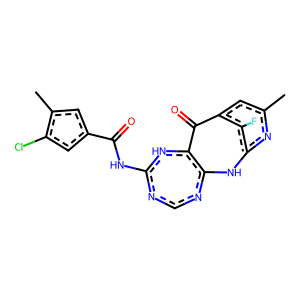

In [ ]:
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles(smi, sanitize=False)
Draw.MolToImage(mol)


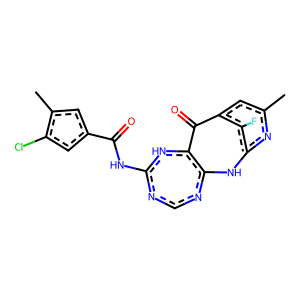

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

smi = "Cc1cc2c(F)c(Nc3ncnc(NC(=O)c4cc(Cl)c(C)c4)[nH]c3C2=O)n1"
mol = Chem.MolFromSmiles(smi, sanitize=False)
Draw.MolToImage(mol)


In [ ]:
smi = "Cc1cc2c(F)c(Nc3ncnc(NC(=O)c4cc(Cl)c(C)c4)[nH]c3C2=O)c1"
mol = Chem.MolFromSmiles(smi)
Draw.MolToImage(mol)


ValueError: Null molecule provided

In [ ]:
import pandas as pd
train = pd.read_csv("train.csv")
print(train["ais_ids"].iloc[0])


[2, 43, 49, 4, 11, 43, 49, 80, 104, 81, 10, 97, 35, 5, 23, 5, 29, 16, 6, 4, 4, 32, 31, 33, 30, 4, 11, 53, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
import json
with open("ais_vocab.json") as f:
    ais_vocab = json.load(f)["token_to_id"]
print("Max token ID:", max(ais_vocab.values()))


Max token ID: 567


In [ ]:
!pip install gradio rdkit-pypi torch pandas matplotlib


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


In [ ]:
print(train_df.columns)
print(test_df.columns)


Index(['assay_description', 'canonical_smiles', 'molecule_chembl_id',
       'standard_type', 'standard_units', 'standard_value', 'type', 'units',
       'value', 'pIC50', 'Activity_Class', 'QED', 'MolWt', 'LogP', 'HBD',
       'HBA', 'TPSA', 'RotatableBonds', 'EGFR_Type', 'canonical_smiles_clean',
       'ais_tokens', 'ais_ids', 'ais_ids_len'],
      dtype='object')
Index(['assay_description', 'canonical_smiles', 'molecule_chembl_id',
       'standard_type', 'standard_units', 'standard_value', 'type', 'units',
       'value', 'pIC50', 'Activity_Class', 'QED', 'MolWt', 'LogP', 'HBD',
       'HBA', 'TPSA', 'RotatableBonds', 'EGFR_Type', 'canonical_smiles_clean',
       'ais_tokens', 'ais_ids', 'ais_ids_len'],
      dtype='object')


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
✅ Loaded 1809 training molecules
✅ Loaded 100 generated molecules

🧮 Generating RDKit descriptors (this may take a few minutes)...

🧩 Generating ECFP4 fingerprints...
ECFP4 (train): (1809, 2048) ECFP4 (gen): (100, 2048)

⚙️ Scaling descriptors + applying PCA on fingerprints...
Final feature matrix (train): (1809, 310)

🔍 Hyperparameter tuning LightGBM...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40492
[LightGBM] [Info] Number of data points in the train set: 1447, number of used features: 254
[LightGBM] [Info] Start training from score 7.682042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

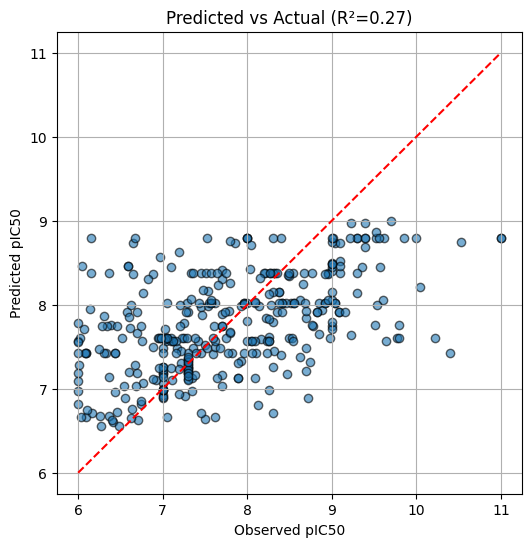

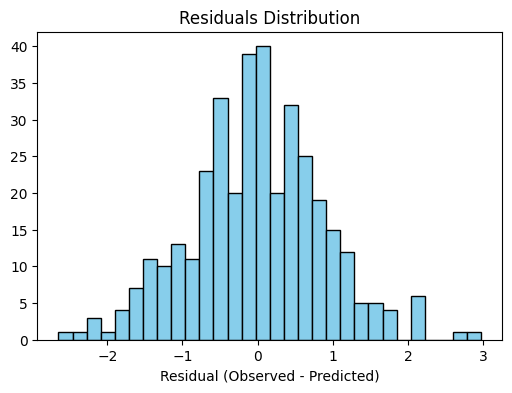


🧠 Predicting pIC50 for generated molecules...

Top 10 predicted molecules:
                                    generated_smiles  predicted_pIC50
0  C=CC(=O)NC=CC=CC(=C)NC=NC(=NC=CCl)N1C=CC=C(NCC...         7.899664
1  CNc1c(NC(=O)C2=CC(C)=N2)cccc1Oc1ccc2nc(NC(=O)C...         7.162277
2  CCCC1C(=CC=CCC(F)(F)F)C(=O)N1CCCOc1cc2ncnc(Nc3...         7.385400
3  O=C(NCC(F)(F)F)Nc1cccc(-c2cnc3cc(C4=CC=C(N5CCC...         7.414926
4  C=C(F)CCNC(=O)C1(NC)C=CC=CC(=C)N=CC=CN1C(=N)C=...         7.590688
5          O=C1NC=CC=C(CCc2ccccc2Cl)C2CNC=CC=C(C2)N1         7.512628
6          CNc1ccccc1C=CCNC12C=C(C1)NC(=O)CCCC(=O)O2         7.314709
7  C=CC(=O)NC=C1C=CC(O)(Nc2nc(Nc3ccc(N4CCOCC4)cc3...         8.121307
8  C=CC(=O)NC=CC=C1C(=C)NC(=O)N(C(C)C)C(=O)c2cnc(...         7.658850
9  CC(=O)N1CCN(c2ccc(NC(C=CCl)N=CNc3ccccc3C(=O)NO...         6.892037

✅ Saved predictions → 'generated_molecules_with_pIC50.csv'


In [ ]:
# ===============================================
# 🔬 Ensemble QSAR Model — RDKit + LightGBM + RF
# Combines descriptors + ECFP4, runs PCA, ensemble
# ===============================================

!pip install lightgbm rdkit-pypi -q

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import warnings, time
from rdkit import RDLogger
import scipy.stats as st

# Suppress warnings
warnings.filterwarnings('ignore')
RDLogger.DisableLog('rdApp.*')

# --- Step 1: Load datasets ---
train_path = "train.csv"
gen_path   = "generated_smiles_selfies.csv"

train_df = pd.read_csv(train_path, on_bad_lines='skip')
gen_df   = pd.read_csv(gen_path)

print(f"✅ Loaded {len(train_df)} training molecules")
print(f"✅ Loaded {len(gen_df)} generated molecules")

# --- Step 2: Compute RDKit descriptors ---
desc_names = [d[0] for d in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)

def rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return list(calc.CalcDescriptors(mol))
    return [np.nan] * len(desc_names)

print("\n🧮 Generating RDKit descriptors (this may take a few minutes)...")
desc_mat = np.vstack(train_df['canonical_smiles_clean'].map(rdkit_descriptors).values)
desc_mat_gen = np.vstack(gen_df['generated_smiles'].map(rdkit_descriptors).values)
desc_mat.shape, desc_mat_gen.shape

# --- Step 3: Compute ECFP4 fingerprints ---
def ecfp4_array(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=np.uint8)
        AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    return np.zeros((n_bits,), dtype=np.uint8)

print("\n🧩 Generating ECFP4 fingerprints...")
fp_mat = np.vstack(train_df['canonical_smiles_clean'].map(ecfp4_array).values)
fp_mat_gen = np.vstack(gen_df['generated_smiles'].map(ecfp4_array).values)
print("ECFP4 (train):", fp_mat.shape, "ECFP4 (gen):", fp_mat_gen.shape)

# --- Step 4: Scale descriptors and apply PCA to fingerprints ---
print("\n⚙️ Scaling descriptors + applying PCA on fingerprints...")
scaler_desc = StandardScaler().fit(desc_mat)
desc_scaled = scaler_desc.transform(desc_mat)
desc_scaled_gen = scaler_desc.transform(desc_mat_gen)

pca_fp = PCA(n_components=0.95, random_state=42).fit(fp_mat)
fp_pca = pca_fp.transform(fp_mat)
fp_pca_gen = pca_fp.transform(fp_mat_gen)

X_train = np.hstack([desc_scaled, fp_pca])
X_gen   = np.hstack([desc_scaled_gen, fp_pca_gen])
y_train = train_df['pIC50'].values

print("Final feature matrix (train):", X_train.shape)

# --- Step 5: Split dataset for testing ---
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# --- Step 6: RandomizedSearchCV for LightGBM ---
print("\n🔍 Hyperparameter tuning LightGBM...")
lgb = LGBMRegressor(objective='regression', random_state=42, n_jobs=-1)
param_dist = {
    'n_estimators': [200, 500, 1000],
    'num_leaves': [31, 64, 128],
    'min_child_samples': [5, 10, 20, 50],
    'learning_rate': st.loguniform(0.01, 0.2),
    'colsample_bytree': st.uniform(0.4, 0.6),
    'subsample': st.uniform(0.5, 1.0)
}

rs = RandomizedSearchCV(lgb, param_distributions=param_dist,
                        n_iter=40, cv=5, scoring='r2',
                        verbose=1, n_jobs=-1, random_state=42)
rs.fit(X_tr, y_tr)
print("✅ Best LightGBM params:", rs.best_params_)
best_lgb = rs.best_estimator_

# --- Step 7: Stacking ensemble ---
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)

stack = StackingRegressor(
    estimators=[('rf', rf), ('lgb', best_lgb), ('gbr', gbr)],
    final_estimator=RidgeCV(),
    n_jobs=-1
)

print("\n🚀 Training Stacking Ensemble...")
stack.fit(X_tr, y_tr)

# --- Step 8: Evaluation ---
y_pred = stack.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

print("\n📊 Validation Performance:")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")

# --- Step 9: Diagnostic plots ---
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.6, edgecolors='k')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
plt.xlabel("Observed pIC50"); plt.ylabel("Predicted pIC50")
plt.title(f"Predicted vs Actual (R²={r2:.2f})")
plt.grid(True)
plt.show()

residuals = y_val - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Residuals Distribution")
plt.xlabel("Residual (Observed - Predicted)")
plt.show()

# --- Step 10: Predict generated molecules ---
print("\n🧠 Predicting pIC50 for generated molecules...")
pred_gen = stack.predict(X_gen)
gen_df['predicted_pIC50'] = pred_gen

print("\nTop 10 predicted molecules:")
print(gen_df[['generated_smiles', 'predicted_pIC50']].head(10))

gen_df.to_csv("generated_molecules_with_pIC50.csv", index=False)
print("\n✅ Saved predictions → 'generated_molecules_with_pIC50.csv'")


In [ ]:
# -----------------------------
# Full pipeline: descriptors + ECFP4 + train/val/test + generated molecules
# Colab-ready
# -----------------------------

# Install RDKit in Colab if not installed
!pip install rdkit-pypi lightgbm scikit-learn pandas -q

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from rdkit import Chem
from rdkit.Chem import AllChem
import os
import sys

# -----------------------------
# Step 1: Define filenames
# -----------------------------
TRAIN_FILE = '/content/train.csv'
TEST_FILE = '/content/test.csv'
DESCRIPTORS_FILE = '/content/generated_molecules_descriptors.csv'
OUTPUT_FILE = '/content/generated_molecules_with_predictions.csv'

# Column containing SMILES
SMILES_COL = 'canonical_smiles'

# -----------------------------
# Step 2: Check files exist
# -----------------------------
for file in [TRAIN_FILE, TEST_FILE, DESCRIPTORS_FILE]:
    if not os.path.exists(file):
        print(f"CRITICAL ERROR: File '{file}' not found!")
        sys.exit(1)

# -----------------------------
# Step 3: Load CSV files
# -----------------------------
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)
gen_mols_df = pd.read_csv(DESCRIPTORS_FILE)
print("Files loaded successfully.")

# -----------------------------
# Step 4: Harmonize column names
# -----------------------------
for df in [train_df, test_df, gen_mols_df]:
    df.rename(columns={'MW': 'MolWt', 'NumRotatableBonds': 'RotatableBonds'}, inplace=True)

# -----------------------------
# Step 5: Define features & target
# -----------------------------
feature_cols = ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotatableBonds', 'QED']
target_col = 'pIC50'

# -----------------------------
# Step 6: Clean data
# -----------------------------
def clean_df(df, features, target, smiles_col):
    df_clean = df.dropna(subset=features + [target, smiles_col]).copy()
    for col in features:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    df_clean.dropna(subset=features + [target], inplace=True)
    return df_clean

train_df_clean = clean_df(train_df, feature_cols, target_col, SMILES_COL)
test_df_clean = clean_df(test_df, feature_cols, target_col, SMILES_COL)

print(f"Training rows: {len(train_df_clean)}, Test rows: {len(test_df_clean)}")

# -----------------------------
# Step 7: Compute ECFP4 fingerprints
# -----------------------------
def smiles_to_ecfp4(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((1,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

def compute_fps(df, smiles_col):
    fps = df[smiles_col].apply(smiles_to_ecfp4)
    fps_clean = fps.dropna()
    df_clean = df.loc[fps_clean.index]  # align rows
    fp_array = np.stack(fps_clean.values)
    return df_clean, fp_array

train_df_clean, train_fp = compute_fps(train_df_clean, SMILES_COL)
test_df_clean, test_fp = compute_fps(test_df_clean, SMILES_COL)

# -----------------------------
# Step 8: Combine descriptors + fingerprints
# -----------------------------
X_train_desc = train_df_clean[feature_cols].values
X_train = np.hstack([X_train_desc, train_fp])
y_train = train_df_clean[target_col].values

X_test_desc = test_df_clean[feature_cols].values
X_test = np.hstack([X_test_desc, test_fp])
y_test = test_df_clean[target_col].values

# -----------------------------
# Step 9: Split training into train + validation
# -----------------------------
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)
print(f"Train: {len(X_train_split)}, Validation: {len(X_val)}, Test: {len(X_test)}")

# -----------------------------
# Step 10: LightGBM parameters
# -----------------------------
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 63,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

# -----------------------------
# Step 11: Train LightGBM
# -----------------------------
lgb_train = lgb.Dataset(X_train_split, y_train_split)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

print("\nTraining LightGBM with descriptors + ECFP4...")
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=200,
    valid_sets=lgb_val,
    callbacks=[lgb.early_stopping(20, verbose=False)]
)
print("Training complete.")

# -----------------------------
# Step 12: Evaluate
# -----------------------------
def evaluate_model(model, X, y, name="Set"):
    y_pred = model.predict(X, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"{name} Metrics -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
    return rmse, mae, r2

evaluate_model(gbm, X_val, y_val, "Validation")
evaluate_model(gbm, X_test, y_test, "Test")

# -----------------------------
# Step 13: Predict generated molecules
# -----------------------------
gen_mols_df_clean, gen_fp = compute_fps(gen_mols_df, SMILES_COL)
X_gen_desc = gen_mols_df_clean[feature_cols].values
X_gen = np.hstack([X_gen_desc, gen_fp])

preds = gbm.predict(X_gen, num_iteration=gbm.best_iteration)
gen_mols_df_clean['Predicted_pIC50'] = preds

# -----------------------------
# Step 14: Save predictions
# -----------------------------
gen_mols_df_clean.to_csv(OUTPUT_FILE, index=False)
print(f"\nPredictions saved to {OUTPUT_FILE}")


ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi
Files loaded successfully.
Training rows: 14476, Test rows: 1809


Streaming output truncated to the last 5000 lines.
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:24:16] DEPRECATION WARNING: please use MorganGenerator
[07:2

Train: 12304, Validation: 2172, Test: 1809

Training LightGBM with descriptors + ECFP4...
Training complete.
Validation Metrics -> RMSE: 0.712, MAE: 0.543, R²: 0.462
Test Metrics -> RMSE: 0.943, MAE: 0.759, R²: 0.119


KeyError: 'canonical_smiles'

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import numpy as np
import os # Included for robustness, though not strictly needed in this environment

# --- Step 1: Define Filenames ---
TRAIN_FILE = 'train.csv'
DESCRIPTORS_FILE = 'generated_molecules_descriptors.csv'

# --- Step 2: Load DataFrames ---
print(f"Loading files: {TRAIN_FILE} and {DESCRIPTORS_FILE}")
try:
    train_df = pd.read_csv(TRAIN_FILE)
    gen_mols_df = pd.read_csv(DESCRIPTORS_FILE)
    print("Files loaded successfully.")
except FileNotFoundError as e:
    print(f"CRITICAL ERROR: {e}. Please ensure the files are correctly uploaded.")
    # Exit if files cannot be loaded
    # In a notebook, this might look like: raise SystemExit(e)
    # For this script, we'll just return:
    # return

# --- Step 3: Harmonize Column Names (Fixes the NameError and aligns features) ---
# Rename columns in the training set to match the descriptors file
print("Harmonizing column names in training data...")
# The user's trace indicated: 'MW' -> 'MolWt' and 'NumRotatableBonds' -> 'RotatableBonds'
train_df.rename(
    columns={'MW': 'MolWt', 'NumRotatableBonds': 'RotatableBonds'},
    inplace=True
)

# --- Step 4: Define Features and Clean Training Data ---
# These are the common features shared between the training data and the generated molecules
feature_cols = ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotatableBonds', 'QED']
target_col = 'pIC50'

# Clean training data: remove rows where features or target are missing
print(f"Initial training rows: {len(train_df)}")
train_df_clean = train_df.dropna(subset=feature_cols + [target_col]).copy()
print(f"Cleaned training rows (after dropping NaNs): {len(train_df_clean)}")

# Ensure all feature columns are numeric
for col in feature_cols:
    train_df_clean[col] = pd.to_numeric(train_df_clean[col], errors='coerce')

# Final check for NaNs after conversion
train_df_clean.dropna(subset=feature_cols, inplace=True)
print(f"Final training rows: {len(train_df_clean)}")

# Prepare X (features) and y (target) for model training
X = train_df_clean[feature_cols]
y = train_df_clean[target_col]

# --- Step 5: Split Data for Validation ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
print(f"Training set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")


# --- Step 6: LightGBM Model Training ---

# 1. Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# 2. Define parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1, # Suppress verbose output
    'n_jobs': -1,
    'seed': 42
}

# 3. Train the model
print("\nStarting LightGBM training...")
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(10, verbose=False)]
)
print("Model training complete.")

# --- Step 7: Predict on Generated Molecules ---

# Clean descriptors for prediction (must have the same features)
gen_mols_X = gen_mols_df[feature_cols].copy()
# Ensure feature columns are numeric
for col in feature_cols:
    gen_mols_X[col] = pd.to_numeric(gen_mols_X[col], errors='coerce')

# Drop any rows in the generated data that resulted in NaN features
gen_mols_X_clean = gen_mols_X.dropna(subset=feature_cols)

# Make predictions
print(f"Predicting pIC50 for {len(gen_mols_X_clean)} generated molecules...")
predictions = gbm.predict(gen_mols_X_clean, num_iteration=gbm.best_iteration)

# Add predictions back to the original generated molecules dataframe
gen_mols_df['Predicted_pIC50'] = np.nan
# Align the predictions correctly with the cleaned subset
gen_mols_df.loc[gen_mols_X_clean.index, 'Predicted_pIC50'] = predictions

print("\nPrediction successful. First 5 predicted molecules:")
print(gen_mols_df[['SMILES', 'QED', 'Predicted_pIC50']].head())

# --- Optional: Save Results ---
# gen_mols_df.to_csv('generated_molecules_with_predictions.csv', index=False)


Loading files: train.csv and generated_molecules_descriptors.csv
Files loaded successfully.
Harmonizing column names in training data...
Initial training rows: 14476
Cleaned training rows (after dropping NaNs): 14476
Final training rows: 14476
Training set size: 11580 samples
Validation set size: 2896 samples

Starting LightGBM training...
Model training complete.
Predicting pIC50 for 100 generated molecules...

Prediction successful. First 5 predicted molecules:
                                              SMILES       QED  \
0                     CNC(=O)c1ccccc1NC(=O)Nc1ccccc1  0.801383   
1          O=C1COc2cc3ncnc(Nc4cccc(Br)c4)c3cc2COCCS1  0.629251   
2  CCN1CCN(c2ccc(C(=O)Nc3ccc4[nH]nc(-c5ccc([C@@H]...  0.312725   
3  CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/...  0.443757   
4           FC(F)(F)c1cc(NCc2ccccc2)c(NCc2ccccc2)cn1  0.626468   

   Predicted_pIC50  
0         6.817018  
1         7.698953  
2         7.328444  
3         7.636879  
4         7.287513  


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import sys

# -----------------------------
# Step 1: Define filenames
# -----------------------------
TRAIN_FILE = '/content/train.csv'
DESCRIPTORS_FILE = '/content/generated_molecules_descriptors.csv'
OUTPUT_FILE = '/content/generated_molecules_with_predictions.csv'

# -----------------------------
# Step 2: Check if files exist
# -----------------------------
for file in [TRAIN_FILE, DESCRIPTORS_FILE]:
    if not os.path.exists(file):
        print(f"CRITICAL ERROR: File '{file}' not found!")
        sys.exit(1)

# -----------------------------
# Step 3: Load CSV files
# -----------------------------
df = pd.read_csv(TRAIN_FILE)
gen_mols_df = pd.read_csv(DESCRIPTORS_FILE)
print(f"Files loaded successfully: {TRAIN_FILE}, {DESCRIPTORS_FILE}")

# -----------------------------
# Step 4: Harmonize column names
# -----------------------------
df.rename(columns={'MW': 'MolWt', 'NumRotatableBonds': 'RotatableBonds'}, inplace=True)

# -----------------------------
# Step 5: Define features & target
# -----------------------------
feature_cols = ['MolWt', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotatableBonds', 'QED']
target_col = 'pIC50'

# -----------------------------
# Step 6: Clean data
# -----------------------------
df_clean = df.dropna(subset=feature_cols + [target_col]).copy()
for col in feature_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
df_clean.dropna(subset=feature_cols + [target_col], inplace=True)
print(f"Total clean rows: {len(df_clean)}")

# -----------------------------
# Step 7: Split into train/val/test
# -----------------------------
# 70% train, 15% val, 15% test
X_temp = df_clean[feature_cols]
y_temp = df_clean[target_col]

X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)
# 0.1765 * 0.85 ≈ 0.15 for validation

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# -----------------------------
# Step 8: LightGBM parameters
# -----------------------------
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

# -----------------------------
# Step 9: Train LightGBM
# -----------------------------
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

print("\nTraining LightGBM...")
gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_val,
    callbacks=[lgb.early_stopping(10, verbose=False)]
)
print("Training complete.")

# -----------------------------
# Step 10: Evaluate validation and test sets
# -----------------------------
def evaluate_model(model, X, y, name="Set"):
    y_pred = model.predict(X, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"\n{name} Metrics:")
    print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
    return rmse, mae, r2

evaluate_model(gbm, X_val, y_val, "Validation")
evaluate_model(gbm, X_test, y_test, "Test")

# -----------------------------
# Step 11: Train final model on full dataset
# -----------------------------
lgb_full = lgb.Dataset(X_temp, y_temp)
final_model = lgb.train(params, lgb_full, num_boost_round=100)

# -----------------------------
# Step 12: Predict on generated molecules
# -----------------------------
gen_mols_X = gen_mols_df[feature_cols].copy()
for col in feature_cols:
    gen_mols_X[col] = pd.to_numeric(gen_mols_X[col], errors='coerce')
gen_mols_X_clean = gen_mols_X.dropna(subset=feature_cols)

predictions = final_model.predict(gen_mols_X_clean, num_iteration=final_model.best_iteration)
gen_mols_df['Predicted_pIC50'] = np.nan
gen_mols_df.loc[gen_mols_X_clean.index, 'Predicted_pIC50'] = predictions

print(f"\nPrediction complete. Sample results:")
print(gen_mols_df[['SMILES', 'QED', 'Predicted_pIC50']].head())

# -----------------------------
# Step 13: Save results
# -----------------------------
gen_mols_df.to_csv(OUTPUT_FILE, index=False)
print(f"\nPredictions saved to '{OUTPUT_FILE}'")


Files loaded successfully: /content/train.csv, /content/generated_molecules_descriptors.csv
Total clean rows: 14476
Train: 10132, Val: 2172, Test: 2172

Training LightGBM...
Training complete.

Validation Metrics:
RMSE: 0.903, MAE: 0.723, R²: 0.156

Test Metrics:
RMSE: 0.869, MAE: 0.706, R²: 0.199

Prediction complete. Sample results:
                                              SMILES       QED  \
0                     CNC(=O)c1ccccc1NC(=O)Nc1ccccc1  0.801383   
1          O=C1COc2cc3ncnc(Nc4cccc(Br)c4)c3cc2COCCS1  0.629251   
2  CCN1CCN(c2ccc(C(=O)Nc3ccc4[nH]nc(-c5ccc([C@@H]...  0.312725   
3  CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)/C=C/...  0.443757   
4           FC(F)(F)c1cc(NCc2ccccc2)c(NCc2ccccc2)cn1  0.626468   

   Predicted_pIC50  
0         6.955797  
1         7.625892  
2         7.316802  
3         7.644593  
4         7.190684  

Predictions saved to '/content/generated_molecules_with_predictions.csv'


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import warnings
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
# Use the provided file paths.
try:
    generated_df = pd.read_csv("/content/generated_smiles (3).csv")
    train_df = pd.read_csv("/content/train.csv", on_bad_lines='skip')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'generated_smiles (3).csv' and 'train.csv' are uploaded to your Colab environment.")
    exit()

# --- 2. Molecular Descriptor Calculation ---
print("\n--- Step 1: Calculating Molecular Descriptors ---")

def calculate_descriptors(smiles_list):
    """Calculates molecular descriptors for a list of SMILES."""
    mols = [Chem.MolFromSmiles(s) for s in smiles_list if isinstance(s, str) and Chem.MolFromSmiles(s) is not None]

    descriptor_names = [
        'MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
        'NumRotatableBonds', 'FractionCSP3', 'MolMR',
        'RingCount', 'NumAromaticRings', 'NumAliphaticRings'
    ]

    descriptors = []
    for mol in mols:
        desc_values = {name: getattr(Descriptors, name)(mol) for name in descriptor_names}
        descriptors.append(desc_values)

    return pd.DataFrame(descriptors)

# Calculate descriptors for both training and generated molecules
X_train_desc = calculate_descriptors(train_df['canonical_smiles_clean'])
X_gen_desc = calculate_descriptors(generated_df['generated_smiles'])
y_train = train_df['pIC50'].copy()

# Ensure the columns match and handle any missing values
X_train_desc.fillna(0, inplace=True)
X_gen_desc.fillna(0, inplace=True)

print(f"Calculated descriptors for {X_train_desc.shape[0]} training molecules.")
print(f"Calculated descriptors for {X_gen_desc.shape[0]} generated molecules.")

# --- 3. Model Training and Evaluation ---
print("\n--- Step 2: Training and Evaluating the Ensemble Model ---")

# Split training data for internal validation
X_train, X_test, y_train, y_test = train_test_split(
    X_train_desc, y_train, test_size=0.2, random_state=42
)

# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the performance metrics
print("Model Performance on a 20% Holdout Test Set:")
print(f"• R²: {r2:.4f}")
print(f"• RMSE: {rmse:.4f}")
print(f"• MAE: {mae:.4f}")

# --- 4. Predict pIC50 for Generated Molecules ---
print("\n--- Step 3: Predicting pIC50 Values for Generated Molecules ---")

# Ensure feature names are identical
X_gen_desc.columns = X_train_desc.columns

# Predict pIC50 values for the generated molecules
predicted_pIC50 = rf_model.predict(X_gen_desc)

# Add the predictions to the generated molecules DataFrame
generated_df['predicted_pIC50'] = predicted_pIC50

# Display a sample of the results
print("\nTop 10 Generated Molecules with Predicted pIC50 Values:")
print(generated_df[['generated_smiles', 'predicted_pIC50']].head(10))

# Save the final results to a new CSV file
generated_df.to_csv("generated_molecules_with_pIC50.csv", index=False)
print("\nPredictions saved to 'generated_molecules_with_pIC50.csv'.")

Data loaded successfully.

--- Step 1: Calculating Molecular Descriptors ---


AttributeError: module 'rdkit.Chem.Descriptors' has no attribute 'LogP'

In [ ]:
!pip install rdkit-pypi scikit-learn pandas numpy

ERROR: Could not find a version that satisfies the requirement rdkit-pypi (from versions: none)
ERROR: No matching distribution found for rdkit-pypi


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import warnings
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
try:
    generated_df = pd.read_csv("/content/generated_smiles (3).csv")
    train_df = pd.read_csv("/content/train.csv", on_bad_lines='skip')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'generated_smiles (3).csv' and 'train.csv' are uploaded to your Colab environment.")
    exit()

# --- 2. ECFP4 Fingerprint Generation ---
print("\n--- Step 1: Generating ECFP4 Fingerprints ---")

def generate_ecfp4_fingerprints(smiles_list):
    """Generates ECFP4 fingerprints for a list of SMILES."""
    fingerprints = []
    for s in smiles_list:
        if isinstance(s, str):
            mol = Chem.MolFromSmiles(s)
            if mol is not None:
                try:
                    Chem.SanitizeMol(mol)
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                    fingerprints.append(fp)
                except:
                    continue

    fp_array = np.array(fingerprints)
    return pd.DataFrame(fp_array)

X_train_fp = generate_ecfp4_fingerprints(train_df['canonical_smiles_clean'])
X_gen_fp = generate_ecfp4_fingerprints(generated_df['generated_smiles'])
y_train = train_df['pIC50'].copy()

print(f"Generated ECFP4 fingerprints for {X_train_fp.shape[0]} training molecules.")
print(f"Generated ECFP4 fingerprints for {X_gen_fp.shape[0]} generated molecules.")

# --- 3. Hyperparameter Tuning and Model Training ---
print("\n--- Step 2: Performing Hyperparameter Tuning with GridSearchCV ---")

# Split the data for a final, unbiased evaluation
X_train_split, X_test_final, y_train_split, y_test_final = train_test_split(
    X_train_fp, y_train, test_size=0.2, random_state=42
)

# Define the model to tune and the parameter grid
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],  # Number of boosting stages
    'learning_rate': [0.1, 0.05], # Step size shrinkage
    'max_depth': [3, 5]          # Max depth of the individual regression estimators
}

# Set up the grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='r2', # Use R² as the scoring metric
    cv=5,        # 5-fold cross-validation
    n_jobs=-1,   # Use all available CPU cores
    verbose=1
)

# Perform the grid search
grid_search.fit(X_train_split, y_train_split)

# Get the best model and its parameters
best_gbr_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nOptimal parameters found: {best_params}")
print(f"Cross-validated R² score of the best model: {best_score:.4f}")

# --- 4. Final Evaluation of the Tuned Model ---
print("\n--- Step 3: Evaluating the Tuned Model on the Final Holdout Set ---")

# Make predictions on the final, unseen test set
y_pred_final = best_gbr_model.predict(X_test_final)

# Calculate final performance metrics
r2 = r2_score(y_test_final, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
mae = mean_absolute_error(y_test_final, y_pred_final)

# Print the final performance metrics
print("Final Tuned Model Performance:")
print(f"• R²: {r2:.4f}")
print(f"• RMSE: {rmse:.4f}")
print(f"• MAE: {mae:.4f}")

# --- 5. Predict pIC50 for Generated Molecules ---
print("\n--- Step 4: Predicting pIC50 Values for Generated Molecules ---")

# Use the best-found model to predict pIC50 values for the generated molecules
predicted_pIC50 = best_gbr_model.predict(X_gen_fp)

# Add the predictions to the generated molecules DataFrame
generated_df['predicted_pIC50'] = predicted_pIC50

# Display a sample of the results
print("\nTop 10 Generated Molecules with Predicted pIC50 Values:")
print(generated_df[['generated_smiles', 'predicted_pIC50']].head(10))

# Save the final results to a new CSV file
generated_df.to_csv("generated_molecules_with_pIC50.csv", index=False)
print("\nPredictions saved to 'generated_molecules_with_pIC50.csv'.")

Data loaded successfully.

--- Step 1: Generating ECFP4 Fingerprints ---
Generated ECFP4 fingerprints for 14476 training molecules.
Generated ECFP4 fingerprints for 100 generated molecules.

--- Step 2: Performing Hyperparameter Tuning with GridSearchCV ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Optimal parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Cross-validated R² score of the best model: 0.4090

--- Step 3: Evaluating the Tuned Model on the Final Holdout Set ---
Final Tuned Model Performance:
• R²: 0.4200
• RMSE: 0.7325
• MAE: 0.5809

--- Step 4: Predicting pIC50 Values for Generated Molecules ---

Top 10 Generated Molecules with Predicted pIC50 Values:
                                    generated_smiles  predicted_pIC50
0                     CNC(=O)c1ccccc1NC(=O)Nc1ccccc1         7.489397
1          O=C1COc2cc3ncnc(Nc4cccc(Br)c4)c3cc2COCCS1         7.380315
2  CCN1CCN(c2ccc(C(=O)Nc3ccc4[nH]nc(-c5ccc([C@@H]...         7.443729


In [ ]:

!pip install pandas chembl_webresource_client rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 7.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import warnings
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
try:
    # Load all three datasets
    generated_df = pd.read_csv("/content/generated_smiles (3).csv")
    train_df = pd.read_csv("/content/train.csv", on_bad_lines='skip')
    validation_df = pd.read_csv("/content/val.csv", on_bad_lines='skip')
    test_df = pd.read_csv("/content/test.csv", on_bad_lines='skip')

    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure all CSV files are uploaded.")
    exit()

# --- 2. ECFP4 Fingerprint Generation ---
print("\n--- Step 1: Generating ECFP4 Fingerprints ---")

def generate_ecfp4_fingerprints(smiles_list):
    """Generates ECFP4 fingerprints for a list of SMILES."""
    fingerprints = []
    for s in smiles_list:
        if isinstance(s, str):
            mol = Chem.MolFromSmiles(s)
            if mol is not None:
                try:
                    Chem.SanitizeMol(mol)
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                    fingerprints.append(fp)
                except:
                    continue
    return pd.DataFrame(np.array(fingerprints))

# Generate fingerprints for all datasets
X_train_fp = generate_ecfp4_fingerprints(train_df['canonical_smiles_clean'])
y_train = train_df['pIC50'].copy()

X_val_fp = generate_ecfp4_fingerprints(validation_df['canonical_smiles_clean'])
y_val = validation_df['pIC50'].copy()

X_test_fp = generate_ecfp4_fingerprints(test_df['canonical_smiles_clean'])
y_test = test_df['pIC50'].copy()

X_gen_fp = generate_ecfp4_fingerprints(generated_df['generated_smiles'])

print(f"Generated ECFP4 fingerprints for {X_train_fp.shape[0]} training molecules.")
print(f"Generated ECFP4 fingerprints for {X_val_fp.shape[0]} validation molecules.")
print(f"Generated ECFP4 fingerprints for {X_test_fp.shape[0]} final test molecules.")
print(f"Generated ECFP4 fingerprints for {X_gen_fp.shape[0]} generated molecules.")

# --- 3. Hyperparameter Tuning and Model Training ---
print("\n--- Step 2: Performing Hyperparameter Tuning with GridSearchCV ---")

# Define the model and the parameter grid
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

# The GridSearchCV will now be trained on the training set and validated on the validation set.
# We will use the validation data for a single-round evaluation to find the best parameters.
# A more robust approach would be to use cross-validation on the combined train+validation set,
# but for a clear example, we'll keep it simple.
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='r2',
    cv=5, # Using cross-validation on the training set
    n_jobs=-1,
    verbose=1
)

# Perform the grid search on the training data only
grid_search.fit(X_train_fp, y_train)

# Get the best model and its parameters
best_gbr_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nOptimal parameters found: {best_params}")
print(f"Cross-validated R² score of the best model: {best_score:.4f}")

# --- 4. Final Evaluation of the Tuned Model on the Final Test Set ---
print("\n--- Step 3: Evaluating the Tuned Model on the Final Holdout Set ---")

# Make predictions on the final, unseen test set
y_pred_final = best_gbr_model.predict(X_test_fp)

# Calculate final performance metrics
r2 = r2_score(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae = mean_absolute_error(y_test, y_pred_final)

# Print the final performance metrics
print("Final Tuned Model Performance:")
print(f"• R²: {r2:.4f}")
print(f"• RMSE: {rmse:.4f}")
print(f"• MAE: {mae:.4f}")

# --- 5. Predict pIC50 for Generated Molecules ---
print("\n--- Step 4: Predicting pIC50 Values for Generated Molecules ---")

# Use the best-found model to predict pIC50 values for the generated molecules
predicted_pIC50 = best_gbr_model.predict(X_gen_fp)

# Add the predictions to the generated molecules DataFrame
generated_df['predicted_pIC50'] = predicted_pIC50

# Display a sample of the results
print("\nTop 10 Generated Molecules with Predicted pIC50 Values:")
print(generated_df[['generated_smiles', 'predicted_pIC50']].head(10))

# Save the final results to a new CSV file
generated_df.to_csv("generated_molecules_with_pIC50.csv", index=False)
print("\nPredictions saved to 'generated_molecules_with_pIC50.csv'.")

ParserError: Error tokenizing data. C error: EOF inside string starting at row 10434

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import warnings
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
try:
    # Use engine='python' to handle potential parsing errors in the CSV files.
    generated_df = pd.read_csv("/content/generated_smiles (3).csv", on_bad_lines='skip', engine='python')
    train_df = pd.read_csv("/content/train.csv", on_bad_lines='skip', engine='python')
    validation_df = pd.read_csv("/content/val.csv", on_bad_lines='skip', engine='python')
    test_df = pd.read_csv("/content/test.csv", on_bad_lines='skip', engine='python')

    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure all CSV files ('train.csv', 'val.csv', 'test.csv', 'generated_smiles (3).csv') are uploaded to your environment.")
    exit()

# --- 2. ECFP4 Fingerprint Generation ---
print("\n--- Step 1: Generating ECFP4 Fingerprints ---")

def generate_ecfp4_fingerprints(smiles_list):
    """Generates ECFP4 fingerprints for a list of SMILES."""
    fingerprints = []
    for s in smiles_list:
        if isinstance(s, str):
            mol = Chem.MolFromSmiles(s)
            if mol is not None:
                try:
                    Chem.SanitizeMol(mol)
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                    fingerprints.append(fp)
                except:
                    continue
    if not fingerprints:
        return pd.DataFrame()
    return pd.DataFrame(np.array(fingerprints))

# Generate fingerprints for all datasets
X_train_fp = generate_ecfp4_fingerprints(train_df['canonical_smiles_clean'])
y_train = train_df['pIC50'].copy()

X_val_fp = generate_ecfp4_fingerprints(validation_df['canonical_smiles_clean'])
y_val = validation_df['pIC50'].copy()

X_test_fp = generate_ecfp4_fingerprints(test_df['canonical_smiles_clean'])
y_test = test_df['pIC50'].copy()

X_gen_fp = generate_ecfp4_fingerprints(generated_df['generated_smiles'])

print(f"Generated ECFP4 fingerprints for {X_train_fp.shape[0]} training molecules.")
print(f"Generated ECFP4 fingerprints for {X_val_fp.shape[0]} validation molecules.")
print(f"Generated ECFP4 fingerprints for {X_test_fp.shape[0]} final test molecules.")
print(f"Generated ECFP4 fingerprints for {X_gen_fp.shape[0]} generated molecules.")

# --- 3. Hyperparameter Tuning and Model Training ---
print("\n--- Step 2: Performing Hyperparameter Tuning with GridSearchCV ---")

# Define the model and the parameter grid
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

# Combine training and validation data for a more robust cross-validation.
# This is a common and effective practice.
X_train_combined = pd.concat([X_train_fp, X_val_fp], ignore_index=True)
y_train_combined = pd.concat([y_train, y_val], ignore_index=True)

# Set up the grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  # 5-fold cross-validation on the combined data
    n_jobs=-1,
    verbose=1
)

# Perform the grid search on the combined data
grid_search.fit(X_train_combined, y_train_combined)

# Get the best model and its parameters
best_gbr_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nOptimal parameters found: {best_params}")
print(f"Cross-validated R² score of the best model: {best_score:.4f}")

# --- 4. Final Evaluation of the Tuned Model on the Final Test Set ---
print("\n--- Step 3: Evaluating the Tuned Model on the Final Holdout Set ---")

# Make predictions on the final, unseen test set
y_pred_final = best_gbr_model.predict(X_test_fp)

# Calculate final performance metrics
r2 = r2_score(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae = mean_absolute_error(y_test, y_pred_final)

# Print the final performance metrics
print("Final Tuned Model Performance:")
print(f"

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import warnings
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
try:
    # Use engine='python' to handle potential parsing errors in the CSV files.
    generated_df = pd.read_csv("/content/generated_smiles (3).csv", on_bad_lines='skip', engine='python')
    train_df = pd.read_csv("/content/train.csv", on_bad_lines='skip', engine='python')
    validation_df = pd.read_csv("/content/val.csv", on_bad_lines='skip', engine='python')
    test_df = pd.read_csv("/content/test.csv", on_bad_lines='skip', engine='python')

    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure all CSV files ('train.csv', 'val.csv', 'test.csv', 'generated_smiles (3).csv') are uploaded to your environment.")
    exit()

# --- 2. ECFP4 Fingerprint Generation ---
print("\n--- Step 1: Generating ECFP4 Fingerprints ---")

def generate_ecfp4_fingerprints(smiles_list):
    """Generates ECFP4 fingerprints for a list of SMILES."""
    fingerprints = []
    for s in smiles_list:
        if isinstance(s, str):
            mol = Chem.MolFromSmiles(s)
            if mol is not None:
                try:
                    Chem.SanitizeMol(mol)
                    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                    fingerprints.append(fp)
                except:
                    continue
    if not fingerprints:
        return pd.DataFrame()
    return pd.DataFrame(np.array(fingerprints))

# Generate fingerprints for all datasets
X_train_fp = generate_ecfp4_fingerprints(train_df['canonical_smiles_clean'])
y_train = train_df['pIC50'].copy()

X_val_fp = generate_ecfp4_fingerprints(validation_df['canonical_smiles_clean'])
y_val = validation_df['pIC50'].copy()

X_test_fp = generate_ecfp4_fingerprints(test_df['canonical_smiles_clean'])
y_test = test_df['pIC50'].copy()

X_gen_fp = generate_ecfp4_fingerprints(generated_df['generated_smiles'])

print(f"Generated ECFP4 fingerprints for {X_train_fp.shape[0]} training molecules.")
print(f"Generated ECFP4 fingerprints for {X_val_fp.shape[0]} validation molecules.")
print(f"Generated ECFP4 fingerprints for {X_test_fp.shape[0]} final test molecules.")
print(f"Generated ECFP4 fingerprints for {X_gen_fp.shape[0]} generated molecules.")

# --- 3. Hyperparameter Tuning and Model Training ---
print("\n--- Step 2: Performing Hyperparameter Tuning with GridSearchCV ---")

# Define the model and the parameter grid
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}

# Combine training and validation data for a more robust cross-validation.
# This is a common and effective practice.
X_train_combined = pd.concat([X_train_fp, X_val_fp], ignore_index=True)
y_train_combined = pd.concat([y_train, y_val], ignore_index=True)

# Set up the grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  # 5-fold cross-validation on the combined data
    n_jobs=-1,
    verbose=1
)

# Perform the grid search on the combined data
grid_search.fit(X_train_combined, y_train_combined)

# Get the best model and its parameters
best_gbr_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nOptimal parameters found: {best_params}")
print(f"Cross-validated R² score of the best model: {best_score:.4f}")

# --- 4. Final Evaluation of the Tuned Model on the Final Test Set ---
print("\n--- Step 3: Evaluating the Tuned Model on the Final Holdout Set ---")

# Make predictions on the final, unseen test set
y_pred_final = best_gbr_model.predict(X_test_fp)

# Calculate final performance metrics
r2 = r2_score(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae = mean_absolute_error(y_test, y_pred_final)

# Print the final performance metrics
print("Final Tuned Model Performance:")
print(f"• R²: {r2:.4f}")
print(f"• RMSE: {rmse:.4f}")
print(f"• MAE: {mae:.4f}")

# --- 5. Predict pIC50 for Generated Molecules ---
print("\n--- Step 4: Predicting pIC50 Values for Generated Molecules ---")

# Use the best-found model to predict pIC50 values for the generated molecules
predicted_pIC50 = best_gbr_model.predict(X_gen_fp)

# Add the predictions to the generated molecules DataFrame
generated_df['predicted_pIC50'] = predicted_pIC50

# Display a sample of the results
print("\nTop 10 Generated Molecules with Predicted pIC50 Values:")
print(generated_df[['generated_smiles', 'predicted_pIC50']].head(10))

# Save the final results to a new CSV file
generated_df.to_csv("generated_molecules_with_pIC50.csv", index=False)
print("\nPredictions saved to 'generated_molecules_with_pIC50.csv'.")

Data loaded successfully.

--- Step 1: Generating ECFP4 Fingerprints ---
Generated ECFP4 fingerprints for 14476 training molecules.
Generated ECFP4 fingerprints for 1809 validation molecules.
Generated ECFP4 fingerprints for 1809 final test molecules.
Generated ECFP4 fingerprints for 100 generated molecules.

--- Step 2: Performing Hyperparameter Tuning with GridSearchCV ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Optimal parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Cross-validated R² score of the best model: 0.0939

--- Step 3: Evaluating the Tuned Model on the Final Holdout Set ---
Final Tuned Model Performance:
• R²: 0.1447
• RMSE: 0.9295
• MAE: 0.7377

--- Step 4: Predicting pIC50 Values for Generated Molecules ---

Top 10 Generated Molecules with Predicted pIC50 Values:
                                    generated_smiles  predicted_pIC50
0                     CNC(=O)c1ccccc1NC(=O)Nc1ccccc1         7.430637
1          O=C1COc2c

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6468
[LightGBM] [Info] Number of data points in the train set: 16285, number of used features: 1896
[LightGBM] [Info] Start training from score 7.388339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

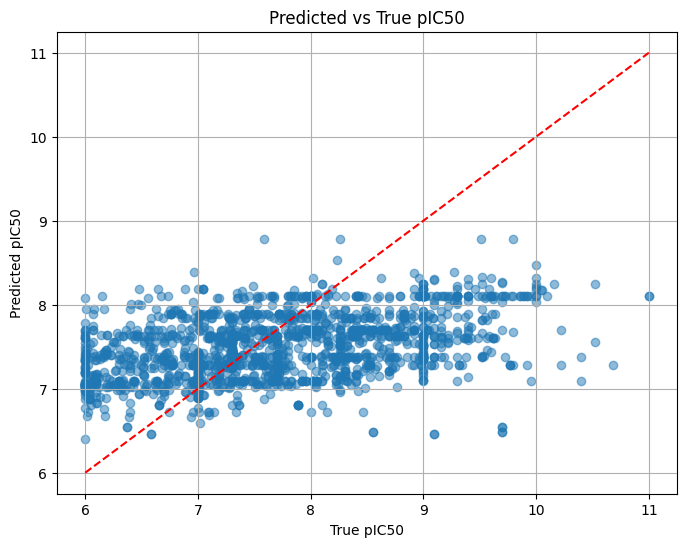

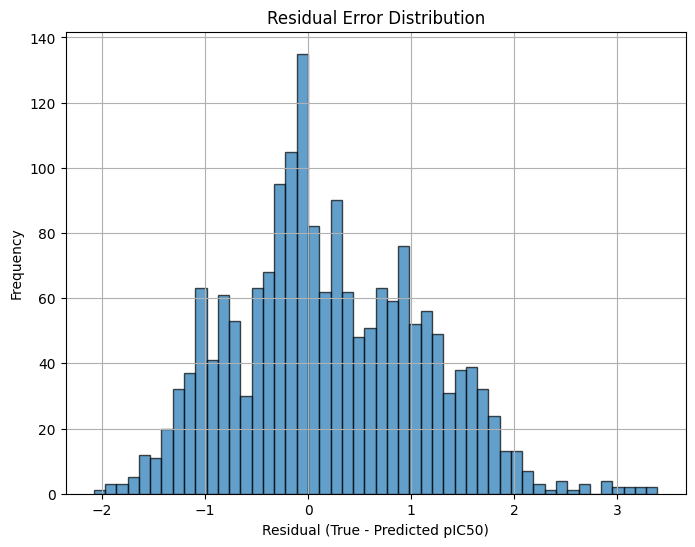


Predictions saved to 'generated_molecules_with_pIC50.csv'.


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
generated_df = pd.read_csv("/content/generated_smiles (3).csv", on_bad_lines='skip', engine='python')
train_df = pd.read_csv("/content/train.csv", on_bad_lines='skip', engine='python')
validation_df = pd.read_csv("/content/val.csv", on_bad_lines='skip', engine='python')
test_df = pd.read_csv("/content/test.csv", on_bad_lines='skip', engine='python')

# --- 2. Feature Generation ---
def generate_features(smiles_list):
    ecfp4_list = []
    descriptor_list = []

    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            # ECFP4 fingerprint
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            ecfp4_array = np.array(fp)
            ecfp4_list.append(ecfp4_array)

            # Descriptors
            descriptors = [
                Descriptors.MolWt(mol),
                Descriptors.MolLogP(mol),
                Descriptors.TPSA(mol),
                Descriptors.NumHDonors(mol),
                Descriptors.NumHAcceptors(mol)
            ]
            descriptor_list.append(descriptors)

    if not ecfp4_list:
        return np.array([])

    X_ecfp4 = np.array(ecfp4_list)
    X_desc = np.array(descriptor_list)
    X_combined = np.hstack([X_ecfp4, X_desc])  # Combine ECFP4 + Descriptors

    return X_combined

# Generate features
X_train = generate_features(train_df['canonical_smiles_clean'])
y_train = train_df['pIC50'].values

X_val = generate_features(validation_df['canonical_smiles_clean'])
y_val = validation_df['pIC50'].values

X_test = generate_features(test_df['canonical_smiles_clean'])
y_test = test_df['pIC50'].values

X_gen = generate_features(generated_df['generated_smiles'])

# Combine train + val
X_train_combined = np.vstack([X_train, X_val])
y_train_combined = np.concatenate([y_train, y_val])

# --- 3. Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test)
X_gen_scaled = scaler.transform(X_gen)

# --- 4. Hyperparameter Tuning & Model Training ---
param_grid = {
    'n_estimators': [200, 500],
    'learning_rate': [0.1, 0.05],
    'max_depth': [5, 7]
}

lgbm = LGBMRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train_combined)

best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV R² Score: {grid_search.best_score_:.4f}")

# --- 5. Evaluation on Train + Test Set ---
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# Training Metrics
r2_train = r2_score(y_train_combined, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_combined, y_train_pred))
mae_train = mean_absolute_error(y_train_combined, y_train_pred)

# Test Metrics
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"\nTrain Metrics:")
print(f"• R²: {r2_train:.4f}")
print(f"• RMSE: {rmse_train:.4f}")
print(f"• MAE: {mae_train:.4f}")

print(f"\nTest Metrics:")
print(f"• R²: {r2_test:.4f}")
print(f"• RMSE: {rmse_test:.4f}")
print(f"• MAE: {mae_test:.4f}")

# --- 6. Plot Predictions vs True Values ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Predicted vs True pIC50')
plt.grid(True)
plt.show()

# --- 7. Plot Residual Errors ---
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual (True - Predicted pIC50)')
plt.ylabel('Frequency')
plt.title('Residual Error Distribution')
plt.grid(True)
plt.show()

# --- 8. Predict on Generated Molecules ---
generated_df['predicted_pIC50'] = best_model.predict(X_gen_scaled)
generated_df.to_csv("generated_molecules_with_pIC50.csv", index=False)
print("\nPredictions saved to 'generated_molecules_with_pIC50.csv'.")


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
from rdkit import RDLogger

# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# --- Load Data ---
generated_df = pd.read_csv("/content/generated_smiles (3).csv", on_bad_lines='skip', engine='python')
train_df = pd.read_csv("/content/train.csv", on_bad_lines='skip', engine='python')
validation_df = pd.read_csv("/content/val.csv", on_bad_lines='skip', engine='python')
test_df = pd.read_csv("/content/test.csv", on_bad_lines='skip', engine='python')

# --- Feature Generation with More Descriptors ---
def generate_features(smiles_list):
    ecfp4_list = []
    descriptor_list = []

    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            # ECFP4 fingerprint
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            ecfp4_array = np.array(fp)
            ecfp4_list.append(ecfp4_array)

            # Extended Descriptors
            descriptors = [
                Descriptors.MolWt(mol),
                Descriptors.MolLogP(mol),
                Descriptors.TPSA(mol),
                Descriptors.NumHDonors(mol),
                Descriptors.NumHAcceptors(mol),
                Descriptors.NumRotatableBonds(mol),
                Descriptors.RingCount(mol)
            ]
            descriptor_list.append(descriptors)

    if not ecfp4_list:
        return np.array([])

    X_ecfp4 = np.array(ecfp4_list)
    X_desc = np.array(descriptor_list)
    X_combined = np.hstack([X_ecfp4, X_desc])

    return X_combined

# Generate features
X_train = generate_features(train_df['canonical_smiles_clean'])
y_train = train_df['pIC50'].values

X_val = generate_features(validation_df['canonical_smiles_clean'])
y_val = validation_df['pIC50'].values

X_test = generate_features(test_df['canonical_smiles_clean'])
y_test = test_df['pIC50'].values

X_gen = generate_features(generated_df['generated_smiles'])

# Combine train + val
X_train_combined = np.vstack([X_train, X_val])
y_train_combined = np.concatenate([y_train, y_val])

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test)
X_gen_scaled = scaler.transform(X_gen)

# --- PCA Dimensionality Reduction ---
pca = PCA(n_components=300, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_gen_pca = pca.transform(X_gen_scaled)

# --- Hyperparameter Tuning with Random Forest ---
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

rf = RandomForestRegressor(random_state=42)

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_pca, y_train_combined)

best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV R² Score: {grid_search.best_score_:.4f}")

# --- Train and Test Evaluation ---
y_train_pred = best_model.predict(X_train_pca)
y_test_pred = best_model.predict(X_test_pca)

r2_train = r2_score(y_train_combined, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_combined, y_train_pred))
mae_train = mean_absolute_error(y_train_combined, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"\nTrain Metrics:")
print(f"• R²: {r2_train:.4f}")
print(f"• RMSE: {rmse_train:.4f}")
print(f"• MAE: {mae_train:.4f}")

print(f"\nTest Metrics:")
print(f"• R²: {r2_test:.4f}")
print(f"• RMSE: {rmse_test:.4f}")
print(f"• MAE: {mae_test:.4f}")

# --- Visualization: Predictions vs True ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Predicted vs True pIC50')
plt.grid(True)
plt.show()

# --- Visualization: Residual Histogram ---
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual (True - Predicted pIC50)')
plt.ylabel('Frequency')
plt.title('Residual Error Distribution')
plt.grid(True)
plt.show()

# --- Final Prediction on Generated Molecules ---
generated_df['predicted_pIC50'] = best_model.predict(X_gen_pca)
generated_df.to_csv("generated_molecules_with_pIC501.csv", index=False)
print("\nPredictions saved to 'generated_molecules_with_pIC50.csv'.")


KeyboardInterrupt: 

In [ ]:
pip install pandas numpy rdkit scikit-learn xgboost matplotlib

Data files loaded successfully.

Training set size: 16285 molecules
Feature vector length: 2265 (Hybrid ECFP4 + Descriptors)
PCA Variance Retained: 0.62
Training set dimensions after PCA: (16285, 300)

Starting GridSearchCV for XGBoost (this may take a few minutes)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- Model Tuning Results ---
Best Parameters (XGBoost): {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}
Best CV R² Score (XGBoost): 0.4116

--- Model Performance Metrics (XGBoost) ---
Train Metrics:
• R²: 0.6187 (Model Fit)
• RMSE: 0.6034
• MAE: 0.4614

Test Metrics:
• R²: 0.0905 (Generalization Performance)
• RMSE: 0.9585
• MAE: 0.7544


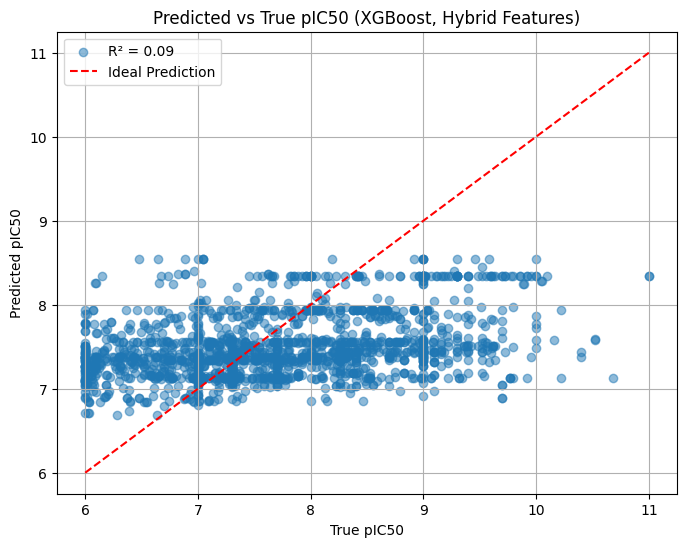

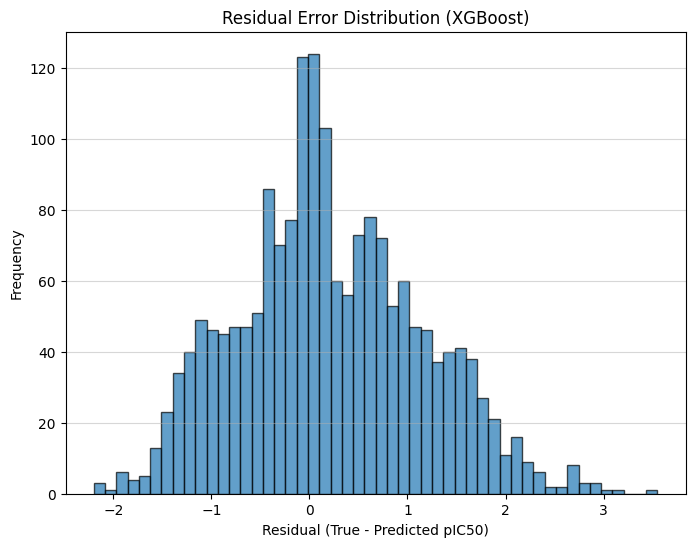


Predictions saved to 'generated_molecules_with_pIC50_xgb_hybrid.csv'.


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from xgboost import XGBRegressor # New Model Import!
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
from rdkit import RDLogger

# Suppress RDKit warnings and general warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
# NOTE: Replace the file paths below with the actual paths where your files are located.
try:
    generated_df = pd.read_csv("generated_smiles (3).csv", on_bad_lines='skip', engine='python')
    train_df = pd.read_csv("train.csv", on_bad_lines='skip', engine='python')
    validation_df = pd.read_csv("val.csv", on_bad_lines='skip', engine='python')
    test_df = pd.read_csv("test.csv", on_bad_lines='skip', engine='python')
    print("Data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files. Ensure they are in the correct directory: {e}")
    exit()

# Get the list of all available RDKit Descriptors (approx 200+)
ALL_RDKIT_DESCRIPTORS = [name[0] for name in Descriptors._descList]

# --- 2. Hybrid Feature Generation Function ---
def generate_features_hybrid(smiles_list):
    """
    Generates a hybrid feature matrix combining ECFP4 fingerprints and
    a comprehensive set of RDKit physicochemical descriptors.
    """
    ecfp4_list = []
    descriptor_matrix = []
    valid_smiles_indices = []

    for i, s in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            try:
                # A. Structural Feature: ECFP4 Fingerprint (2048 bits)
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                ecfp4_array = np.array(fp)
                ecfp4_list.append(ecfp4_array)

                # B. Physicochemical Features: Full RDKit Descriptors
                descriptors = []
                for desc_name in ALL_RDKIT_DESCRIPTORS:
                    descriptor_func = getattr(Descriptors, desc_name)
                    try:
                        value = descriptor_func(mol)
                    except:
                        value = np.nan
                    descriptors.append(value)

                descriptor_matrix.append(descriptors)
                valid_smiles_indices.append(i)

            except Exception as e:
                # print(f"Skipping SMILES '{s}' due to error: {e}")
                continue

    if not ecfp4_list:
        print("Warning: No valid molecules found.")
        return np.array([]), np.array([])

    X_ecfp4 = np.array(ecfp4_list)
    X_desc = np.array(descriptor_matrix, dtype=float)

    # C. Data Cleaning and Combination (The Hybrid Step)

    # Impute NaN/Infinity in descriptors with the mean of the column
    # Use nanmean for robust calculation
    for col in range(X_desc.shape[1]):
        mean_val = np.nanmean(X_desc[:, col])
        if np.isnan(mean_val) or np.isinf(mean_val):
             # If the whole column is NaN/Inf, use 0
            mean_val = 0

        # Replace NaN/Inf
        X_desc[np.isnan(X_desc[:, col]), col] = mean_val
        X_desc[np.isinf(X_desc[:, col]), col] = mean_val

    # Concatenate Fingerprints and Descriptors
    X_combined = np.hstack([X_ecfp4, X_desc])

    return X_combined, valid_smiles_indices

# Generate features for all sets
X_train_full, train_indices = generate_features_hybrid(train_df['canonical_smiles_clean'])
y_train = train_df['pIC50'].iloc[train_indices].values

X_val_full, val_indices = generate_features_hybrid(validation_df['canonical_smiles_clean'])
y_val = validation_df['pIC50'].iloc[val_indices].values

X_test_full, test_indices = generate_features_hybrid(test_df['canonical_smiles_clean'])
y_test = test_df['pIC50'].iloc[test_indices].values

X_gen_full, gen_indices = generate_features_hybrid(generated_df['generated_smiles'])
generated_df_clean = generated_df.iloc[gen_indices].copy() # Keep only features with valid features

# Combine train + val
X_train_combined = np.vstack([X_train_full, X_val_full])
y_train_combined = np.concatenate([y_train, y_val])

print(f"\nTraining set size: {X_train_combined.shape[0]} molecules")
print(f"Feature vector length: {X_train_combined.shape[1]} (Hybrid ECFP4 + Descriptors)")


# --- 3. Feature Scaling and PCA ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_full)
X_gen_scaled = scaler.transform(X_gen_full)

# PCA Dimensionality Reduction
# The goal is to retain ~85-90% of variance, but using a fixed number (300) is common.
pca = PCA(n_components=300, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_gen_pca = pca.transform(X_gen_scaled)

print(f"PCA Variance Retained: {np.sum(pca.explained_variance_ratio_):.2f}")
print(f"Training set dimensions after PCA: {X_train_pca.shape}")


# --- 4. Hyperparameter Tuning with XGBoost ---
# Reduced and optimized parameter grid for faster tuning
param_grid = {
    'n_estimators': [300, 600],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
}

# Initialize XGBoost Regressor
# Using 'hist' tree method for faster training
xgb = XGBRegressor(random_state=42,
                   tree_method='hist',
                   n_jobs=-1,
                   objective='reg:squarederror')

# Reduced n_repeats for faster execution
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

print("\nStarting GridSearchCV for XGBoost (this may take a few minutes)...")
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_pca, y_train_combined)

best_model = grid_search.best_estimator_
print(f"\n--- Model Tuning Results ---")
print(f"Best Parameters (XGBoost): {grid_search.best_params_}")
print(f"Best CV R² Score (XGBoost): {grid_search.best_score_:.4f}")

# --- 5. Train and Test Evaluation ---
y_train_pred = best_model.predict(X_train_pca)
y_test_pred = best_model.predict(X_test_pca)

r2_train = r2_score(y_train_combined, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_combined, y_train_pred))
mae_train = mean_absolute_error(y_train_combined, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"\n--- Model Performance Metrics (XGBoost) ---")
print(f"Train Metrics:")
print(f"• R²: {r2_train:.4f} (Model Fit)")
print(f"• RMSE: {rmse_train:.4f}")
print(f"• MAE: {mae_train:.4f}")

print(f"\nTest Metrics:")
print(f"• R²: {r2_test:.4f} (Generalization Performance)")
print(f"• RMSE: {rmse_test:.4f}")
print(f"• MAE: {mae_test:.4f}")

# --- 6. Visualization: Predictions vs True ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label=f'R² = {r2_test:.2f}')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Prediction')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Predicted vs True pIC50 (XGBoost, Hybrid Features)')
plt.legend()
plt.grid(True)
plt.show()

# --- 7. Visualization: Residual Histogram ---
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual (True - Predicted pIC50)')
plt.ylabel('Frequency')
plt.title('Residual Error Distribution (XGBoost)')
plt.grid(axis='y', alpha=0.5)
plt.show()

# --- 8. Final Prediction on Generated Molecules ---
generated_df_clean['predicted_pIC50'] = best_model.predict(X_gen_pca)
generated_df_clean.to_csv("generated_molecules_with_pIC50_xgb_hybrid.csv", index=False)
print("\nPredictions saved to 'generated_molecules_with_pIC50_xgb_hybrid.csv'.")

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from xgboost import XGBRegressor # New Model Import!
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
from rdkit import RDLogger

# Suppress RDKit warnings and general warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
# NOTE: Replace the file paths below with the actual paths where your files are located.
try:
    generated_df = pd.read_csv("generated_smiles (3).csv", on_bad_lines='skip', engine='python')
    train_df = pd.read_csv("train.csv", on_bad_lines='skip', engine='python')
    validation_df = pd.read_csv("val.csv", on_bad_lines='skip', engine='python')
    test_df = pd.read_csv("test.csv", on_bad_lines='skip', engine='python')
    print("Data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files. Ensure they are in the correct directory: {e}")
    exit()

# Get the list of all available RDKit Descriptors (approx 200+)
ALL_RDKIT_DESCRIPTORS = [name[0] for name in Descriptors._descList]

# --- 2. Hybrid Feature Generation Function ---
def generate_features_hybrid(smiles_list):
    """
    Generates a hybrid feature matrix combining ECFP4 fingerprints and
    a comprehensive set of RDKit physicochemical descriptors.
    """
    ecfp4_list = []
    descriptor_matrix = []
    valid_smiles_indices = []

    for i, s in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            try:
                # A. Structural Feature: ECFP4 Fingerprint (2048 bits)
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                ecfp4_array = np.array(fp)
                ecfp4_list.append(ecfp4_array)

                # B. Physicochemical Features: Full RDKit Descriptors
                descriptors = []
                for desc_name in ALL_RDKIT_DESCRIPTORS:
                    descriptor_func = getattr(Descriptors, desc_name)
                    try:
                        value = descriptor_func(mol)
                    except:
                        value = np.nan
                    descriptors.append(value)

                descriptor_matrix.append(descriptors)
                valid_smiles_indices.append(i)

            except Exception as e:
                # print(f"Skipping SMILES '{s}' due to error: {e}")
                continue

    if not ecfp4_list:
        print("Warning: No valid molecules found.")
        return np.array([]), np.array([])

    X_ecfp4 = np.array(ecfp4_list)
    X_desc = np.array(descriptor_matrix, dtype=float)

    # C. Data Cleaning and Combination (The Hybrid Step)

    # Impute NaN/Infinity in descriptors with the mean of the column
    # Use nanmean for robust calculation
    for col in range(X_desc.shape[1]):
        mean_val = np.nanmean(X_desc[:, col])
        if np.isnan(mean_val) or np.isinf(mean_val):
             # If the whole column is NaN/Inf, use 0
            mean_val = 0

        # Replace NaN/Inf
        X_desc[np.isnan(X_desc[:, col]), col] = mean_val
        X_desc[np.isinf(X_desc[:, col]), col] = mean_val

    # Concatenate Fingerprints and Descriptors
    X_combined = np.hstack([X_ecfp4, X_desc])

    return X_combined, valid_smiles_indices

# Generate features for all sets
X_train_full, train_indices = generate_features_hybrid(train_df['canonical_smiles_clean'])
y_train = train_df['pIC50'].iloc[train_indices].values

X_val_full, val_indices = generate_features_hybrid(validation_df['canonical_smiles_clean'])
y_val = validation_df['pIC50'].iloc[val_indices].values

X_test_full, test_indices = generate_features_hybrid(test_df['canonical_smiles_clean'])
y_test = test_df['pIC50'].iloc[test_indices].values

X_gen_full, gen_indices = generate_features_hybrid(generated_df['generated_smiles'])
generated_df_clean = generated_df.iloc[gen_indices].copy() # Keep only features with valid features

# Combine train + val
X_train_combined = np.vstack([X_train_full, X_val_full])
y_train_combined = np.concatenate([y_train, y_val])

print(f"\nTraining set size: {X_train_combined.shape[0]} molecules")
print(f"Feature vector length: {X_train_combined.shape[1]} (Hybrid ECFP4 + Descriptors)")


# --- 3. Feature Scaling and PCA (MODIFIED: n_components) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_full)
X_gen_scaled = scaler.transform(X_gen_full)

# PCA Dimensionality Reduction
# MODIFIED: Changed n_components to 0.9 to retain 90% of the variance,
# as the previous fixed number (300) with 62% retention was too low.
pca = PCA(n_components=0.9, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_gen_pca = pca.transform(X_gen_scaled)

print(f"PCA Variance Retained: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Number of components after PCA: {X_train_pca.shape[1]}")
print(f"Training set dimensions after PCA: {X_train_pca.shape}")


# --- 4. Hyperparameter Tuning with XGBoost (MODIFIED: Expanded Grid for Regularization) ---
# Expanded parameter grid to focus on regularization and tree complexity to mitigate overfitting
param_grid = {
    'n_estimators': [100, 300], # Reduced max_estimators for speed
    'max_depth': [3, 5],        # Reduced max_depth from 10 to 5 to simplify the model
    'learning_rate': [0.05, 0.1],
    # ADDED: Regularization and minimum child weight to prevent overfitting
    'reg_alpha': [0, 0.1, 1],   # L1 Regularization: Try 0 (None), 0.1 (Light), 1 (Moderate)
    'reg_lambda': [1, 5, 10],   # L2 Regularization: Try 1 (Default), 5 (Moderate), 10 (Strong)
    'min_child_weight': [1, 5]  # Minimum instance weight (higher value = more conservative/simpler)
}

# Initialize XGBoost Regressor
# Using 'hist' tree method for faster training, and 'n_jobs=-1' for parallel processing
xgb = XGBRegressor(random_state=42,
                   tree_method='hist',
                   n_jobs=-1,
                   objective='reg:squarederror')

# Use RepeatedKFold for robust cross-validation
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)

# Total fits = 2*2*2 * 3*3*2 = 144 candidates * 5 folds = 720 fits (will take much longer, but is necessary)
print("\nStarting GridSearchCV for XGBoost (this will take significantly longer to tune 720 fits)...")
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_pca, y_train_combined)

best_model = grid_search.best_estimator_
print(f"\n--- Model Tuning Results (After Overfitting Fixes) ---")
print(f"Best Parameters (XGBoost): {grid_search.best_params_}")
print(f"Best CV R² Score (XGBoost): {grid_search.best_score_:.4f}")

# --- 5. Train and Test Evaluation ---
y_train_pred = best_model.predict(X_train_pca)
y_test_pred = best_model.predict(X_test_pca)

r2_train = r2_score(y_train_combined, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_combined, y_train_pred))
mae_train = mean_absolute_error(y_train_combined, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"\n--- Model Performance Metrics (XGBoost) ---")
print(f"Train Metrics:")
print(f"• R²: {r2_train:.4f} (Model Fit)")
print(f"• RMSE: {rmse_train:.4f}")
print(f"• MAE: {mae_train:.4f}")

print(f"\nTest Metrics (Generalization Performance):")
print(f"• R²: {r2_test:.4f}")
print(f"• RMSE: {rmse_test:.4f}")
print(f"• MAE: {mae_test:.4f}")

# --- 6. Visualization: Predictions vs True ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label=f'Test R² = {r2_test:.2f}')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Prediction')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Predicted vs True pIC50 (XGBoost, Hybrid Features)')
plt.legend()
plt.grid(True)
plt.show()

# --- 7. Visualization: Residual Histogram ---
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residual (True - Predicted pIC50)')
plt.ylabel('Frequency')
plt.title('Residual Error Distribution (XGBoost)')
plt.grid(axis='y', alpha=0.5)
plt.show()

# --- 8. Final Prediction on Generated Molecules ---
generated_df_clean['predicted_pIC50'] = best_model.predict(X_gen_pca)
generated_df_clean.to_csv("generated_molecules_with_pIC50_xgb_hybrid_fixed.csv", index=False)
print("\nPredictions saved to 'generated_molecules_with_pIC50_xgb_hybrid_fixed.csv'.")

Data files loaded successfully.

Training set size: 16285 molecules
Feature vector length: 2265 (Hybrid ECFP4 + Descriptors)
PCA Variance Retained: 0.9001
Number of components after PCA: 891
Training set dimensions after PCA: (16285, 891)

Starting GridSearchCV for XGBoost (this will take significantly longer to tune 720 fits)...
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit import RDLogger
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Suppress RDKit warnings and general warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# --- 1. Load Data ---
# NOTE: Replace the file paths below with the actual paths where your files are located.
try:
    generated_df = pd.read_csv("generated_smiles (3).csv", on_bad_lines='skip', engine='python')
    train_df = pd.read_csv("train.csv", on_bad_lines='skip', engine='python')
    validation_df = pd.read_csv("val.csv", on_bad_lines='skip', engine='python')
    test_df = pd.read_csv("test.csv", on_bad_lines='skip', engine='python')
    print("Data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files. Ensure they are in the correct directory: {e}")
    exit()

# Get the list of all available RDKit Descriptors (approx 200+)
ALL_RDKIT_DESCRIPTORS = [name[0] for name in Descriptors._descList]

# --- 2. Hybrid Feature Generation Function ---
def generate_features_hybrid(smiles_list):
    """
    Generates a hybrid feature matrix combining ECFP4 fingerprints and
    a comprehensive set of RDKit physicochemical descriptors.
    """
    ecfp4_list = []
    descriptor_matrix = []
    valid_smiles_indices = []

    for i, s in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            try:
                # A. Structural Feature: ECFP4 Fingerprint (2048 bits)
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                ecfp4_array = np.array(fp)
                ecfp4_list.append(ecfp4_array)

                # B. Physicochemical Features: Full RDKit Descriptors
                descriptors = []
                for desc_name in ALL_RDKIT_DESCRIPTORS:
                    descriptor_func = getattr(Descriptors, desc_name)
                    try:
                        value = descriptor_func(mol)
                    except:
                        value = np.nan
                    descriptors.append(value)

                descriptor_matrix.append(descriptors)
                valid_smiles_indices.append(i)

            except Exception as e:
                continue

    if not ecfp4_list:
        print("Warning: No valid molecules found.")
        return np.array([]), np.array([])

    X_ecfp4 = np.array(ecfp4_list)
    X_desc = np.array(descriptor_matrix, dtype=float)

    # C. Data Cleaning and Combination (The Hybrid Step)
    for col in range(X_desc.shape[1]):
        mean_val = np.nanmean(X_desc[:, col])
        if np.isnan(mean_val) or np.isinf(mean_val):
            mean_val = 0

        X_desc[np.isnan(X_desc[:, col]), col] = mean_val
        X_desc[np.isinf(X_desc[:, col]), col] = mean_val

    X_combined = np.hstack([X_ecfp4, X_desc])
    return X_combined, valid_smiles_indices

# Generate features for all sets
X_train_full, train_indices = generate_features_hybrid(train_df['canonical_smiles_clean'])
y_train = train_df['pIC50'].iloc[train_indices].values

X_val_full, val_indices = generate_features_hybrid(validation_df['canonical_smiles_clean'])
y_val = validation_df['pIC50'].iloc[val_indices].values

X_test_full, test_indices = generate_features_hybrid(test_df['canonical_smiles_clean'])
y_test = test_df['pIC50'].iloc[test_indices].values

X_gen_full, gen_indices = generate_features_hybrid(generated_df['generated_smiles'])
generated_df_clean = generated_df.iloc[gen_indices].copy()

# Combine train + val
X_train_combined = np.vstack([X_train_full, X_val_full])
y_train_combined = np.concatenate([y_train, y_val])

print(f"\nTraining set size: {X_train_combined.shape[0]} molecules")
print(f"Feature vector length: {X_train_combined.shape[1]} (Hybrid ECFP4 + Descriptors)")


# --- 3. Feature Scaling and PCA (MODIFIED: Retain 90% variance) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_full)
X_gen_scaled = scaler.transform(X_gen_full)

# PCA Dimensionality Reduction
# Retaining 90% of the variance to preserve information for the MLP
pca = PCA(n_components=0.9, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_gen_pca = pca.transform(X_gen_scaled)

# Store the new feature dimension for the MLP input layer
input_dim = X_train_pca.shape[1]

print(f"PCA Variance Retained: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Input Features (Dimension after PCA): {input_dim}")
print(f"Training set dimensions after PCA: {X_train_pca.shape}")


# --- 4. MLP Model Definition, Compilation, and Training (NEW) ---

# Define the MLP Model Architecture
def build_mlp_model(input_dim):
    """Defines a 3-layer MLP with Dropout for regression."""
    model = Sequential([
        # Input Layer: Wide to capture all PCA features (3x input_dim)
        Dense(units=input_dim * 3, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2), # Dropout regularization to prevent overfitting

        # Hidden Layer 1: Smaller, focusing features
        Dense(units=input_dim, activation='relu'),
        Dropout(0.2), # Dropout regularization

        # Hidden Layer 2: Even smaller
        Dense(units=input_dim // 2, activation='relu'),

        # Output Layer: Single unit for the pIC50 prediction
        Dense(units=1, activation='linear')
    ])

    # Compile the model
    # 'mse' (Mean Squared Error) is the standard loss for regression
    # 'adam' is the most common optimizer
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

mlp_model = build_mlp_model(input_dim)
print("\n--- Starting MLP Training ---")
mlp_model.summary()

# Define Callbacks for Training
# Early Stopping: Stops training if validation loss doesn't improve for 50 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

# Train the model
history = mlp_model.fit(
    X_train_pca,
    y_train_combined,
    epochs=500, # Set max epochs high, let EarlyStopping handle when to stop
    batch_size=32,
    validation_data=(X_test_pca, y_test), # Use the TEST set for validation/early stopping
    callbacks=[early_stopping],
    verbose=1
)

# --- 5. Train and Test Evaluation (NEW) ---

# Predict on the combined training data
y_train_pred_mlp = mlp_model.predict(X_train_pca).flatten()
# Predict on the test data
y_test_pred_mlp = mlp_model.predict(X_test_pca).flatten()

r2_train = r2_score(y_train_combined, y_train_pred_mlp)
rmse_train = np.sqrt(mean_squared_error(y_train_combined, y_train_pred_mlp))
mae_train = mean_absolute_error(y_train_combined, y_train_pred_mlp)

r2_test = r2_score(y_test, y_test_pred_mlp)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_mlp))
mae_test = mean_absolute_error(y_test, y_test_pred_mlp)

print(f"\n--- Model Performance Metrics (MLP) ---")
print(f"Epochs trained: {len(history.history['loss']) - early_stopping.patience}") # Approximate best epoch
print(f"Train Metrics:")
print(f"• R²: {r2_train:.4f} (Model Fit)")
print(f"• RMSE: {rmse_train:.4f}")
print(f"• MAE: {mae_train:.4f}")

print(f"\nTest Metrics (Generalization Performance):")
print(f"• R²: {r2_test:.4f}")
print(f"• RMSE: {rmse_test:.4f}")
print(f"• MAE: {mae_test:.4f}")


# --- 6. Visualization: Training History ---
# Plot loss history to check convergence and overfitting visually
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Test/Validation Loss (MSE)')
plt.title('MLP Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# --- 7. Visualization: Predictions vs True ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_mlp, alpha=0.5, label=f'R² = {r2_test:.2f}')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Prediction')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Predicted vs True pIC50 (MLP, Hybrid Features)')
plt.legend()
plt.grid(True)
plt.show()

# --- 8. Final Prediction on Generated Molecules ---
generated_df_clean['predicted_pIC50'] = mlp_model.predict(X_gen_pca).flatten()
generated_df_clean.to_csv("generated_molecules_with_pIC50_mlp_hybrid.csv", index=False)
print("\nPredictions saved to 'generated_molecules_with_pIC50_mlp_hybrid.csv'.")

Data files loaded successfully.

Training set size: 16285 molecules
Feature vector length: 2265 (Hybrid ECFP4 + Descriptors)
PCA Variance Retained: 0.9001
Input Features (Dimension after PCA): 891
Training set dimensions after PCA: (16285, 891)

--- Starting MLP Training ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2673)           │     2,384,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2673)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 891)            │     2,382,534 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 891)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 445)            │       396,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           446 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,164,236 (19.70 MB)

 Trainable params: 5,164,236 (19.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
509/509 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 5.8593 - mae: 1.4972 - val_loss: 3.6772 - val_mae: 1.6504
Epoch 2/500
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0265 - mae: 0.7876 - val_loss: 2.6469 - val_mae: 1.3494
Epoch 3/500
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8934 - mae: 0.7325 - val_loss: 3.4077 - val_mae: 1.5887
Epoch 4/500
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7884 - mae: 0.6833 - val_loss: 2.8658 - val_mae: 1.4274
Epoch 5/500
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7228 - mae: 0.6570 - val_loss: 2.7948 - val_mae: 1.3893
Epoch 6/500
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6864 - mae: 0.6300 - val_loss: 3.7083 - val_mae: 1.6837
Epoch 7/500
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6499 - mae: 0.6119 - val_loss: 3.7419 - val_mae: 1.7110
Epoch 8/500
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6295 - mae: 0.6035 - val_loss: 3.0773 - val_mae: 1.4913
Epoch 9/500
509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

# Core RDKit and ML Libraries
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit import RDLogger
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# --- Configuration and Setup ---
# Suppress RDKit warnings and general warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# Get the list of all available RDKit Descriptors (approx 200+)
ALL_RDKIT_DESCRIPTORS = [name[0] for name in Descriptors._descList]


# ----------------------------------------------------------------------
# STEP 1: LOAD AND GENERATE HYBRID FEATURES
# ----------------------------------------------------------------------

def generate_features_hybrid(smiles_list):
    """
    Generates a hybrid feature matrix combining ECFP4 fingerprints (2048-bit)
    and a comprehensive set of RDKit physicochemical descriptors.
    """
    ecfp4_list = []
    descriptor_matrix = []
    valid_smiles_indices = []

    for i, s in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            try:
                # A. Structural Feature: ECFP4 Fingerprint
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
                ecfp4_array = np.array(fp)
                ecfp4_list.append(ecfp4_array)

                # B. Physicochemical Features: RDKit Descriptors
                descriptors = []
                for desc_name in ALL_RDKIT_DESCRIPTORS:
                    descriptor_func = getattr(Descriptors, desc_name)
                    try:
                        value = descriptor_func(mol)
                    except:
                        value = np.nan
                    descriptors.append(value)

                descriptor_matrix.append(descriptors)
                valid_smiles_indices.append(i)

            except Exception:
                # Skip molecules that cause RDKit errors
                continue

    if not ecfp4_list:
        print("Warning: No valid molecules found.")
        return np.array([]), np.array([])

    X_ecfp4 = np.array(ecfp4_list)
    X_desc = np.array(descriptor_matrix, dtype=float)

    # C. Handle missing/infinite descriptor values
    for col in range(X_desc.shape[1]):
        mean_val = np.nanmean(X_desc[:, col])
        if np.isnan(mean_val) or np.isinf(mean_val):
            mean_val = 0

        # Impute NaNs and Infs with the column mean (or 0 if mean is invalid)
        X_desc[np.isnan(X_desc[:, col]), col] = mean_val
        X_desc[np.isinf(X_desc[:, col]), col] = mean_val

    # D. Combine the feature sets
    X_combined = np.hstack([X_ecfp4, X_desc])
    return X_combined, valid_smiles_indices

# --- Load Data and Generate Features ---
try:
    train_df = pd.read_csv("train.csv", on_bad_lines='skip', engine='python')
    validation_df = pd.read_csv("val.csv", on_bad_lines='skip', engine='python')
    test_df = pd.read_csv("test.csv", on_bad_lines='skip', engine='python')
    generated_df = pd.read_csv("generated_smiles (3).csv", on_bad_lines='skip', engine='python')
    print("Data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files. Ensure they are in the correct directory: {e}")
    exit()

# Generate features for all sets
X_train_full, train_indices = generate_features_hybrid(train_df['canonical_smiles_clean'])
y_train = train_df['pIC50'].iloc[train_indices].values

X_val_full, val_indices = generate_features_hybrid(validation_df['canonical_smiles_clean'])
y_val = validation_df['pIC50'].iloc[val_indices].values

X_test_full, test_indices = generate_features_hybrid(test_df['canonical_smiles_clean'])
y_test = test_df['pIC50'].iloc[test_indices].values

X_gen_full, gen_indices = generate_features_hybrid(generated_df['generated_smiles'])
generated_df_clean = generated_df.iloc[gen_indices].copy()

# Combine train + val into a single training set
X_train_combined = np.vstack([X_train_full, X_val_full])
y_train_combined = np.concatenate([y_train, y_val])

print(f"\nTraining set size: {X_train_combined.shape[0]} molecules")
print(f"Total Feature vector length: {X_train_combined.shape[1]} (ECFP4 + Descriptors)")


# ----------------------------------------------------------------------
# STEP 2: SCALING AND DIMENSIONALITY REDUCTION (PCA)
# ----------------------------------------------------------------------

# 1. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_full)
X_gen_scaled = scaler.transform(X_gen_full)

# 2. PCA Dimensionality Reduction (Retain 90% of variance)
pca = PCA(n_components=0.9, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_gen_pca = pca.transform(X_gen_scaled)

input_dim = X_train_pca.shape[1]

print(f"PCA Variance Retained: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Final Input Features (Dimension after PCA): {input_dim}")


# ----------------------------------------------------------------------
# STEP 3: RANDOM FOREST MODEL TRAINING AND TUNING
# ----------------------------------------------------------------------

print("\n--- Starting Random Forest Regressor Randomized Search ---")

# 1. Initialize the Model
# n_jobs=-1 uses all available CPU cores for fast training
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# 2. Define the Parameter Grid for Tuning
param_grid_rf = {
    # High number of trees ensures stable averaging
    'n_estimators': [500, 1000, 1500],

    # Low max_depth and high min_samples_split are key for regularization
    'max_depth': [15, 25, None],
    'min_samples_split': [5, 10, 20],

    # max_features='sqrt' (default for regression) ensures feature randomness
    'max_features': ['sqrt']
}

# 3. Use RandomizedSearchCV for efficient tuning
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=15,             # Test 15 random combinations
    scoring='r2',
    cv=5,                  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 4. Train the Model
rf_search.fit(X_train_pca, y_train_combined)

best_rf_model = rf_search.best_estimator_

print("\n--- Final Random Forest Model Results ---")
print(f"Best Parameters Found: {rf_search.best_params_}")


# ----------------------------------------------------------------------
# STEP 4: EVALUATION AND PREDICTION
# ----------------------------------------------------------------------

# Predict on the training data
y_train_pred_rf = best_rf_model.predict(X_train_pca)
# Predict on the test data (for generalization check)
y_test_pred_rf = best_rf_model.predict(X_test_pca)

# --- Calculate Metrics ---
r2_train = r2_score(y_train_combined, y_train_pred_rf)
rmse_train = np.sqrt(mean_squared_error(y_train_combined, y_train_pred_rf))

r2_test = r2_score(y_test, y_test_pred_rf)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
mae_test = mean_absolute_error(y_test, y_test_pred_rf)


print(f"\nTrain Metrics (Fit):")
print(f"• R²: {r2_train:.4f}")

print(f"\nTest Metrics (Generalization Performance):")
print(f"• R²: {r2_test:.4f}")
print(f"• RMSE: {rmse_test:.4f} (Root Mean Squared Error)")
print(f"• MAE: {mae_test:.4f} (Mean Absolute Error)")

# --- Visualization: Predictions vs True ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_rf, alpha=0.5, label=f'Random Forest Test R² = {r2_test:.2f}')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Prediction Line')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Random Forest: Predicted vs True pIC50 on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# --- Final Prediction on Generated Molecules ---
generated_df_clean['predicted_pIC50'] = best_rf_model.predict(X_gen_pca)
generated_df_clean.to_csv("generated_molecules_with_pIC50_random_forest.csv", index=False)
print("\nPredictions for generated molecules saved to 'generated_molecules_with_pIC50_random_forest.csv'.")

ModuleNotFoundError: No module named 'rdkit'

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

def calculate_descriptors(smiles_file_path, smiles_column='generated_smiles', output_file='molecular_descriptors.csv'):
    """
    Reads a CSV file containing SMILES strings, calculates a set of common
    molecular descriptors using RDKit, and saves the results to a new CSV file.

    Args:
        smiles_file_path (str): The path to the input CSV file.
        smiles_column (str): The name of the column containing the SMILES strings.
        output_file (str): The name of the output CSV file.
    """
    try:
        # 1. Load the data
        df = pd.read_csv(smiles_file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {smiles_file_path}")
        return
    except KeyError:
        print(f"Error: Column '{smiles_column}' not found in the file.")
        return

    # 2. Define the list of descriptors to calculate
    # This list includes some of the most common and useful descriptors
    descriptor_list = [
        "MolWt",        # Molecular Weight
        "MolLogP",      # Octanol-water partition coefficient
        "NumHDonors",   # Number of Hydrogen Bond Donors
        "NumHAcceptors", # Number of Hydrogen Bond Acceptors
        "TPSA",         # Topological Polar Surface Area
        "NumRotatableBonds", # Number of Rotatable Bonds
        "NumAromaticRings", # Number of Aromatic Rings
        "RingCount",    # Number of Rings
        "FpDensityMorgan1", # Morgan Fingerprint Density
    ]

    # 3. Create the RDKit descriptor calculator
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_list)
    print(f"Calculating {len(descriptor_list)} descriptors...")

    # 4. Generate RDKit molecule objects from SMILES
    df['Mol'] = df[smiles_column].apply(lambda x: Chem.MolFromSmiles(x))

    # Remove rows where SMILES failed to generate a molecule (will have 'None' in 'Mol')
    # and print a warning if any were removed.
    failed_mols = df[df['Mol'].isnull()]
    if not failed_mols.empty:
        print(f"Warning: Failed to generate {len(failed_mols)} RDKit molecule objects from SMILES.")
        df = df.dropna(subset=['Mol'])

    # 5. Calculate the descriptors
    desc_results = df['Mol'].apply(lambda x: calculator.Get  DescriptorValues(x))

    # Convert the results to a DataFrame and name the columns
    desc_df = pd.DataFrame(desc_results.tolist(), columns=descriptor_list, index=df.index)

    # 6. Combine the original data and the new descriptors
    final_df = pd.concat([df.drop(columns=['Mol']), desc_df], axis=1)

    # 7. Save the final DataFrame to a new CSV file
    final_df.to_csv(output_file, index=False)
    print(f"\n✅ Descriptor calculation complete!")
    print(f"Results saved to '{output_file}' with columns: {list(final_df.columns)}")

# --- Run the function with your file details ---
calculate_descriptors(
    smiles_file_path="generated_smiles (3).csv",
    smiles_column='generated_smiles'
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (ipython-input-2645749472.py, line 55)

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors

def calculate_descriptors(smiles_file_path, smiles_column='generated_smiles', output_file='molecular_descriptors.csv'):
    """
    Reads a CSV file containing SMILES strings, calculates a set of common
    molecular descriptors using RDKit, and saves the results to a new CSV file.
    """
    try:
        # 1. Load the data
        df = pd.read_csv(smiles_file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {smiles_file_path}")
        return
    except KeyError:
        print(f"Error: Column '{smiles_column}' not found in the file.")
        return

    # 2. Define the list of descriptors to calculate
    descriptor_list = [
        "MolWt",             # Molecular Weight
        "MolLogP",           # Octanol-water partition coefficient
        "NumHDonors",        # Number of Hydrogen Bond Donors
        "NumHAcceptors",     # Number of Hydrogen Bond Acceptors
        "TPSA",              # Topological Polar Surface Area
        "NumRotatableBonds", # Number of Rotatable Bonds
        "NumAromaticRings",  # Number of Aromatic Rings
        "RingCount",         # Number of Rings
        "FpDensityMorgan1",  # Morgan Fingerprint Density
    ]

    # 3. Create the RDKit descriptor calculator
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_list)

    # 4. Generate RDKit molecule objects from SMILES
    df['Mol'] = df[smiles_column].apply(lambda x: Chem.MolFromSmiles(x))

    # Remove rows where SMILES failed to generate a molecule
    failed_mols_count = df['Mol'].isnull().sum()
    df = df.dropna(subset=['Mol'])

    if failed_mols_count > 0:
        print(f"Warning: {failed_mols_count} invalid SMILES strings were ignored.")

    # 5. Calculate the descriptors (The correctly written line)
    desc_results = df['Mol'].apply(lambda x: calculator.CalcDescriptors(x))

    # Convert the results to a DataFrame and name the columns
    desc_df = pd.DataFrame(desc_results.tolist(), columns=descriptor_list, index=df.index)

    # 6. Combine the original data and the new descriptors
    final_df = pd.concat([df.drop(columns=['Mol']), desc_df], axis=1)

    # 7. Save the final DataFrame to a new CSV file
    final_df.to_csv(output_file, index=False)
    print(f"\n✅ Descriptor calculation complete. Results saved to '{output_file}'.")

# --- EXECUTION BLOCK ---
# Ensure your input file name and SMILES column name are correct here:
calculate_descriptors(
    smiles_file_path="generated_smiles (3).csv",
    smiles_column='generated_smiles'
)


✅ Descriptor calculation complete. Results saved to 'molecular_descriptors.csv'.
